# Time Molecule

Paper is here: https://iopscience.iop.org/article/10.1088/2058-9565/abffbc

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
def spines(ax=None):
    if ax is None:
        ax = plt.gca()
    dict(ax.spines.items())["left"].set_position(('outward', 10))
    dict(ax.spines.items())["bottom"].set_position(('outward', 10))
    dict(ax.spines.items())["top"].set_position(('outward', 10))
    dict(ax.spines.items())["right"].set_position(('outward', 10))
    
def annotate_distance(ax, text, point1, point2, linestyle, fontsize, textoffset = (0.1,0)):
    ax.annotate('', point1, point2, \
            arrowprops={'arrowstyle':'<->', 'linestyle':linestyle, "facecolor":"black"}, fontsize=fontsize);
    ax.annotate(text, point1, (0.5*(point1[0]+point2[0])+textoffset[0], 0.5*(point1[1]+point2[1])+textoffset[1]),
                fontsize=fontsize)

In [3]:
#mpl.style.use('classic')
#mpl.style.use('seaborn')
mpl.style.use('default')

In [4]:
from scipy import *
from scipy.constants import e, h, hbar
from qutip import *
from IPython.display import HTML
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy import *
import random
import scipy.linalg as la
from scipy.linalg import expm, sinm, cosm
import pandas
import numpy
from mpl_toolkits.mplot3d.axes3d import Axes3D
import numpy as np
import matplotlib

In [5]:
from ipywidgets import IntProgress
from IPython.display import display
import time

In [6]:
font = {"size":15}
matplotlib.rc("font", **font)

In [7]:
def PauliMatrix (n):
    if n == 0:
        return  [[1, 0], [0, 1]]
    if n == 1:
        return  [[0, 1], [1, 0]]
    if n == 2:
        return  [[0, -1j], [1j, 0]]
    if n == 3:
        return  [[1, 0], [0, -1]]
    if n == 4:
        return  [[1, 0], [0, 1]]
    return print ('WRONG Pauli Matrix ID')

In [8]:
def tensorize1SiteMatrixKroneker(nSites, nSite, nPauli):
    A = zeros(nSites - nSite) 
    B = zeros(nSite - 1)
    C = []
    for i in B:
        C.append(int(i))
    C.append(nPauli)
    for i in A:
        C.append(int(i)) 
    D = []    
    for i in C:
        D.append(PauliMatrix(i))   
    D1=D[0]
    for i in range(1, nSites,1):
        D1=kron(D1,D[i])
    return D1

def fixedLineKK(nSites, k):
    E = []
    for i in range(0, nSites - 1,1):
        E.append(np.dot(tensorize1SiteMatrixKroneker(nSites, i+1, k),tensorize1SiteMatrixKroneker(nSites, i+2, k)))
    return E

def fixedLocalK(nSites, k):
    F = []
    for i in range(0, nSites,1):
        F.append(tensorize1SiteMatrixKroneker(nSites, i+1, k))
    return F
def disorderedLocalK(nSites, k):
    G = []
    for i in range(0, nSites,1):
        G.append(random.random()*tensorize1SiteMatrixKroneker(nSites, i+1, k))
    return G
def deltaF (w, sitesN):
    H = []
    for i in range(0, sitesN,1):
        H.append(w*(random.random()*2-1))
    return H

def deltaS (w, sitesN):
    H = []
    H.append(0)
    for i in range(1, sitesN,1):
        H.append(i*w/(sitesN-1))
    return H

def deltaF3D (w, sitesN):
    H = []
    for j in range (0, size(w)-1,1):
        HH=[]
        for i in range(0, sitesN,1):
            HH.append(w[j]*(random.random()*2-1))
        H.append(HH)
    return H

def Ufunc(nSites,alpha,g,T,delta):
    X = tensorize1SiteMatrixKroneker(nSites, 1, 1)                        # spins rotation
    Z = delta[0]*tensorize1SiteMatrixKroneker(nSites, 1, 3)               # spins with disorder
    for i in range(2, nSites+1,1):
        X = X + tensorize1SiteMatrixKroneker(nSites, i, 1)
        Z = Z + delta[i-1]*tensorize1SiteMatrixKroneker(nSites, i, 3)
    
    xxyy = np.dot(tensorize1SiteMatrixKroneker(nSites, 1, 1),tensorize1SiteMatrixKroneker(nSites, 2, 1)) + \
           np.dot(tensorize1SiteMatrixKroneker(nSites, 1, 2),tensorize1SiteMatrixKroneker(nSites, 2, 2))            #interaction
    for i in range(2, nSites,1):
        xxyy = xxyy+np.dot(tensorize1SiteMatrixKroneker(nSites, i, 1),tensorize1SiteMatrixKroneker(nSites, i+1, 1)) + \
                    np.dot(tensorize1SiteMatrixKroneker(nSites, i, 2),tensorize1SiteMatrixKroneker(nSites, i+1, 2))
    
    return np.dot(expm(-1j*alpha*X),expm((-1j*T*(Z+g*xxyy)))) 

def Ufunc_all_to_all(nSites,alpha,g,T,delta):
    X = tensorize1SiteMatrixKroneker(nSites, 1, 1)                        # spins rotation
    Z = delta[0]*tensorize1SiteMatrixKroneker(nSites, 1, 3)               # spins with disorder
    for i in range(2, nSites+1,1):
        X = X + tensorize1SiteMatrixKroneker(nSites, i, 1)
        Z = Z + delta[i-1]*tensorize1SiteMatrixKroneker(nSites, i, 3)
    
    xxyy = np.dot(tensorize1SiteMatrixKroneker(nSites, 1, 1),tensorize1SiteMatrixKroneker(nSites, 2, 1)) - \
           np.dot(tensorize1SiteMatrixKroneker(nSites, 1, 1),tensorize1SiteMatrixKroneker(nSites, 2, 1))            #interaction
    for i in range(1, nSites+1,1):
        for j in range(1,nSites+1,1):
            if i<j:
                #print(i,j)
                xxyy = xxyy + np.dot(tensorize1SiteMatrixKroneker(nSites, i, 1),tensorize1SiteMatrixKroneker(nSites, j, 1)) + \
                    np.dot(tensorize1SiteMatrixKroneker(nSites, i, 2),tensorize1SiteMatrixKroneker(nSites, j, 2))
    
    return np.dot(expm(-1j*alpha*X),expm((-1j*T*(Z+g*xxyy)))) 

def Ufunc_all_to_all_Ising(nSites,alpha,g,T,delta):
    X = tensorize1SiteMatrixKroneker(nSites, 1, 1)                        # spins rotation
    Z = delta[0]*tensorize1SiteMatrixKroneker(nSites, 1, 3)               # spins with disorder
    for i in range(2, nSites+1,1):
        X = X + tensorize1SiteMatrixKroneker(nSites, i, 1)
        Z = Z + delta[i-1]*tensorize1SiteMatrixKroneker(nSites, i, 3)
    
    xxyy = np.dot(tensorize1SiteMatrixKroneker(nSites, 1, 3),tensorize1SiteMatrixKroneker(nSites, 2, 3)) - \
           np.dot(tensorize1SiteMatrixKroneker(nSites, 1, 3),tensorize1SiteMatrixKroneker(nSites, 2, 3))            #interaction
    for i in range(1, nSites+1,1):
        for j in range(1,nSites+1,1):
            if i<j:
                xxyy = xxyy + np.dot(tensorize1SiteMatrixKroneker(nSites, i, 3),tensorize1SiteMatrixKroneker(nSites, j, 3))
    
    return np.dot(expm(-1j*alpha*X),expm((-1j*T*(Z+g*xxyy)))) 


def Ufunc_alpha(nSites,alpha,g,T,delta):
    X = alpha[0]*tensorize1SiteMatrixKroneker(nSites, 1, 1)                        # spins rotation
    Z = delta[0]*tensorize1SiteMatrixKroneker(nSites, 1, 3)               # spins with disorder
    for i in range(2, nSites+1,1):
        X = X + alpha[i-1]*tensorize1SiteMatrixKroneker(nSites, i, 1)
        Z = Z + delta[i-1]*tensorize1SiteMatrixKroneker(nSites, i, 3)
    
    xxyy = np.dot(tensorize1SiteMatrixKroneker(nSites, 1, 1),tensorize1SiteMatrixKroneker(nSites, 2, 1)) + \
           np.dot(tensorize1SiteMatrixKroneker(nSites, 1, 2),tensorize1SiteMatrixKroneker(nSites, 2, 2))            #interaction
    for i in range(2, nSites,1):
        xxyy = xxyy+np.dot(tensorize1SiteMatrixKroneker(nSites, i, 1),tensorize1SiteMatrixKroneker(nSites, i+1, 1)) + \
                    np.dot(tensorize1SiteMatrixKroneker(nSites, i, 2),tensorize1SiteMatrixKroneker(nSites, i+1, 2))
    
    return np.dot(expm(-1j*X),expm((-1j*T*(Z+g*xxyy))))

def Gfunc(nSites,alpha,g,T,delta):
    X = tensorize1SiteMatrixKroneker(nSites, 1, 1)                        # spins rotation
    Z = delta[0]*tensorize1SiteMatrixKroneker(nSites, 1, 3)               # spins with disorder
    for i in range(2, nSites+1,1):
        X = X + tensorize1SiteMatrixKroneker(nSites, i, 1)
        Z = Z + delta[i-1]*tensorize1SiteMatrixKroneker(nSites, 1, 3)
    
    xxyy = np.dot(tensorize1SiteMatrixKroneker(nSites, 1, 1),tensorize1SiteMatrixKroneker(nSites, 2, 1)) + \
           np.dot(tensorize1SiteMatrixKroneker(nSites, 1, 2),tensorize1SiteMatrixKroneker(nSites, 2, 2))            #interaction
    for i in range(2, nSites,1):
        xxyy = xxyy+np.dot(tensorize1SiteMatrixKroneker(nSites, i, 1),tensorize1SiteMatrixKroneker(nSites, i+1, 1)) + \
                    np.dot(tensorize1SiteMatrixKroneker(nSites, i, 2),tensorize1SiteMatrixKroneker(nSites, i+1, 2))
    
    return np.dot(expm(-1j*0*X),expm((-1j*T*(Z+g*xxyy)))) 

def states(phiInitFull, Time):
    A = np.array([phiInitFull])
    for i in range(0, Time-1,1):
        A = np.append(A, [np.dot(U,A[i])], 0)
    return A

def states_crop(phiInitFull, Time, N):
    A = np.array([phiInitFull])
    for i in range(0, Time-2,1):
        A = np.append(A, [np.dot(U,A[i])], 0)
        G = Gfunc(nSites,alpha,g,T/N,delta)
    for i in range(1,N):
        A = np.append(A, [np.dot(G,A[-1])], 0)
    return A

def UfuncZZ(nSites,alpha,g,T,delta):
    X = tensorize1SiteMatrixKroneker(nSites, 1, 1)                        # spins rotation
    Z = delta[0]*tensorize1SiteMatrixKroneker(nSites, 1, 3)               # spins with disorder
    for i in range(2, nSites+1,1):
        X = X + tensorize1SiteMatrixKroneker(nSites, i, 1)
        Z = Z + delta[i-1]*tensorize1SiteMatrixKroneker(nSites, 1, 3)
    
    xxyy = np.dot(tensorize1SiteMatrixKroneker(nSites, 1, 1),tensorize1SiteMatrixKroneker(nSites, 2, 1)) + \
           np.dot(tensorize1SiteMatrixKroneker(nSites, 1, 2),tensorize1SiteMatrixKroneker(nSites, 2, 2)) - \
           np.dot(tensorize1SiteMatrixKroneker(nSites, 1, 3),tensorize1SiteMatrixKroneker(nSites, 2, 3)) #interaction
    for i in range(2, nSites,1):
        xxyy = xxyy+np.dot(tensorize1SiteMatrixKroneker(nSites, i, 1),tensorize1SiteMatrixKroneker(nSites, i+1, 1)) + \
                    np.dot(tensorize1SiteMatrixKroneker(nSites, i, 2),tensorize1SiteMatrixKroneker(nSites, i+1, 2)) - \
                    np.dot(tensorize1SiteMatrixKroneker(nSites, i, 3),tensorize1SiteMatrixKroneker(nSites, i+1, 3))
    
    return np.dot(expm(-1j*alpha*X),expm((-1j*T*(Z+g*xxyy)))) 

def GfuncZZ(nSites,alpha,g,T,delta):
    X = tensorize1SiteMatrixKroneker(nSites, 1, 1)                        # spins rotation
    Z = delta[0]*tensorize1SiteMatrixKroneker(nSites, 1, 3)               # spins with disorder
    for i in range(2, nSites+1,1):
        X = X + tensorize1SiteMatrixKroneker(nSites, i, 1)
        Z = Z + delta[i-1]*tensorize1SiteMatrixKroneker(nSites, 1, 3)
    
    xxyy = np.dot(tensorize1SiteMatrixKroneker(nSites, 1, 1),tensorize1SiteMatrixKroneker(nSites, 2, 1)) + \
           np.dot(tensorize1SiteMatrixKroneker(nSites, 1, 2),tensorize1SiteMatrixKroneker(nSites, 2, 2)) - \
           np.dot(tensorize1SiteMatrixKroneker(nSites, 1, 3),tensorize1SiteMatrixKroneker(nSites, 2, 3))          #interaction
    for i in range(2, nSites,1):
        xxyy = xxyy+np.dot(tensorize1SiteMatrixKroneker(nSites, i, 1),tensorize1SiteMatrixKroneker(nSites, i+1, 1)) + \
                    np.dot(tensorize1SiteMatrixKroneker(nSites, i, 2),tensorize1SiteMatrixKroneker(nSites, i+1, 2)) - \
                    np.dot(tensorize1SiteMatrixKroneker(nSites, i, 3),tensorize1SiteMatrixKroneker(nSites, i+1, 3))
    
    return np.dot(expm(-1j*0*X),expm((-1j*T*(Z+g*xxyy)))) 

def states_cropZZ(phiInitFull, Time, N):
    A = np.array([phiInitFull])
    for i in range(0, Time-2,1):
        A = np.append(A, [np.dot(U,A[i])], 0)
        G = GfuncZZ(nSites,alpha,g,T/N,delta)
    for i in range(1,N):
        A = np.append(A, [np.dot(G,A[-1])], 0)
    return A

def UfuncXX(nSites,alpha,g,T,delta):
    X = tensorize1SiteMatrixKroneker(nSites, 1, 1)                        # spins rotation
    Z = delta[0]*tensorize1SiteMatrixKroneker(nSites, 1, 3)               # spins with disorder
    for i in range(2, nSites+1,1):
        X = X + tensorize1SiteMatrixKroneker(nSites, i, 1)
        Z = Z + delta[i-1]*tensorize1SiteMatrixKroneker(nSites, 1, 3)
    
    xxyy = np.dot(tensorize1SiteMatrixKroneker(nSites, 1, 1),tensorize1SiteMatrixKroneker(nSites, 2, 1))
           
    for i in range(2, nSites,1):
        xxyy = xxyy+np.dot(tensorize1SiteMatrixKroneker(nSites, i, 1),tensorize1SiteMatrixKroneker(nSites, i+1, 1))
                    
    
    return np.dot(expm(-1j*alpha*X),expm((-1j*T*(Z+g*xxyy)))) 

def GfuncXX(nSites,alpha,g,T,delta):
    X = tensorize1SiteMatrixKroneker(nSites, 1, 1)                        # spins rotation
    Z = delta[0]*tensorize1SiteMatrixKroneker(nSites, 1, 3)               # spins with disorder
    for i in range(2, nSites+1,1):
        X = X + tensorize1SiteMatrixKroneker(nSites, i, 1)
        Z = Z + delta[i-1]*tensorize1SiteMatrixKroneker(nSites, 1, 3)
    
    xxyy = np.dot(tensorize1SiteMatrixKroneker(nSites, 1, 1),tensorize1SiteMatrixKroneker(nSites, 2, 1)) 
           
    for i in range(2, nSites,1):
        xxyy = xxyy+np.dot(tensorize1SiteMatrixKroneker(nSites, i, 1),tensorize1SiteMatrixKroneker(nSites, i+1, 1))
    
    return np.dot(expm(-1j*0*X),expm((-1j*T*(Z+g*xxyy)))) 

def states_cropXX(phiInitFull, Time, N):
    A = np.array([phiInitFull])
    for i in range(0, Time-2,1):
        A = np.append(A, [np.dot(U,A[i])], 0)
        G = GfuncXX(nSites,alpha,g,T/N,delta)
    for i in range(1,N):
        A = np.append(A, [np.dot(G,A[-1])], 0)
    return A

def transponiren(vector):
    a = np.zeros((size(vector)), dtype=np.complex)[newaxis, :]
    a = a.T
    a=a-a
    for i in range(0, size(vector),1):
        a[i] = np.complex128(vector[i])
    return a

In [9]:
def density_Matrix(phiInitFull):
    return np.kron(phiInitFull, conjugate(phiInitFull)).reshape(size(phiInitFull),size(phiInitFull))

def entropy(phiInitFull):
    X=density_Matrix(phiInitFull)
    return -(X*log(X)).trace()

In [10]:
def Partial_Entropy(Vector):
    RHO = density_Matrix(Vector)
    #print(RHO)
    Reduced_matrix = [[RHO[0][0]+RHO[1][1], RHO[0][2]+RHO[1][3]], [RHO[2][0]+RHO[3][1], RHO[2][2]+RHO[3][3]]]
    #print(Reduced_matrix)
    eigvals, eigvecs = la.eig(Reduced_matrix)
    eigvals = real(eigvals)
    nzvals = eigvals[eigvals != 0]
    #print(nzvals)
    logvals = []
    for i in nzvals:
        #print(i)
        logvals.append(log(sqrt(i**2)))
    #print(logvals)
    T = float(real(-sum(nzvals * logvals)))
    return T

In [11]:
def Floquet_eigenvalues(U):
    evals, evecs = la.eig(U)
    eargs = angle(evals)

    eargs += (eargs <= -pi) * (2 * pi) + (eargs > pi) * (-2 * pi)
    e_quasi = -eargs / T

    if sort:
        order = np.argsort(-e_quasi)
    else:
        order = list(range(len(evals)))

    kets_order = [np.matrix(evecs[:, o]).T for o in order]

    return kets_order, e_quasi[order]

In [12]:
def matrix_chop(matrix):
    T = []
    for i in matrix:
        T.append(chop(i))
    return T


In [13]:
def chop(expr, *, max=0.0001):
    return [round(i,3) if abs(i) > max else 0 for i in expr]

In [14]:
def concurrence(RHO):
    rhot = np.dot(np.dot(kron(PauliMatrix(2),PauliMatrix(2)),conj(RHO)),kron(PauliMatrix(2),PauliMatrix(2)))
    eigs = la.fractional_matrix_power(np.dot(np.dot(la.fractional_matrix_power(RHO, 1/2),rhot),la.fractional_matrix_power(RHO, 1/2)),1/2)
    evals, evecs = la.eig(eigs) 
    evals = chop(sort(evals))
    return (max(0,evals[3]-evals[2]-evals[1]-evals[0]))

In [15]:
def matual_variance(A, B, psi):
    """
    Return the matual variance of the A and B operators and state vector psi.
    """
    return 1/2*(expect(commutator(A,B, kind="anti") , psi)) - expect(A, psi)*expect(B, psi)

def SR_uncertainty(A, B, psi):
    """
    Return the right-hand side part of the Robertson–Schrödinger uncertainty relation for
    two operators A and B and state vector psi.
    """
    return abs(1/2*(expect(commutator(A,B, kind="anti") , psi)) - expect(A, psi)*expect(B, psi))**2  + abs(1/2/1j*(expect(commutator(A,B, kind="normal") , psi)))**2 

def correlation_coefficient(A, B, psi):
    """
    Return the correlation coefficient of the A and B operators and state vector psi.
    """
    if matual_variance(A, B, psi) == 0:
        return 0
    else:
        return matual_variance(A, B, psi)/sqrt(variance(A, psi))/sqrt(variance(B, psi))
    
def correlation_efficiency(r):
    """
    Return the correlation coefficient of the A and B operators and state vector psi.
    """
    if r == 1:
        return np.inf
    else:
        return  1/(1-r**2)
    
def SR_uncertainty_ebobo(A, B, psi):
    """
    Return the right-hand side part of the Robertson–Schrödinger uncertainty relation for
    two operators A and B and state vector psi but in the strange representation of Visotsky.
    """
    #if correlation_coefficient(A, B, psi) == 1:
        #return 
    #else:
    return abs(expect(commutator(A,B, kind="normal") , psi))**2/4/(1-correlation_coefficient(A, B, psi)**2)

def SR_uncertainty_no_corr(A, B, psi):
    """
    Return the right-hand side part of the Robertson–Schrödinger uncertainty relation for
    two operators A and B and state vector psi but in the strange representation of Visotsky.
    """
    #if correlation_coefficient(A, B, psi) == 1:
        #return 
    #else:
    return abs(expect(commutator(A,B, kind="normal") , psi))**2/4


def correlation_coefficient_new(A, B, psi):
    """
    Return the anti correlation coefficient of the A and B operators and state vector psi.
    """
    return expect(A, psi)*expect(B, psi)/(sqrt(variance(A, psi))*sqrt(variance(B, psi)))

def correlation_efficiency_new(rp):
    """
    Return the anti correlation coefficient of the A and B operators and state vector psi.
    """
    return 1/(1+rp)

In [90]:
def stationary_times(rho, H, n):
    '''
    rho - the density matrix of the state
    H - Hamiltonian of the system
    n - number of the stationarity times to resolve   (depends on the number of first integrals/integral of motion)
    '''
    #drhodt = hbar/1j*commutator(H, rho, kind='normal')
    drhodt = 1/1j*(H*rho-rho*H)/hbar
    times = []
    for i in arange(n):
        if trace(rho**i * drhodt**2) == 0 :
            times.append(inf)
        else:
            times.append(sqrt(1/trace(rho**i * drhodt**2)))
    return times

In [17]:
nSites = 2

eps=0.6                 #unperfection of pulses
alpha = np.pi/2-eps
w = 0.0                   #disorder
delta = deltaF(w, nSites)
g = 0.5                  #Interaction
T = 1                     # Period

timess=101
times = np.linspace(1, timess, timess)

In [18]:
U=Ufunc_all_to_all(nSites,alpha, g, T, delta)

evals, evecs = la.eig(U)
Fl_eig = chop(real(-1j*log(evals)))
Fl_vec = evecs

print(Fl_eig)
#print(matrix_chop(Fl_vec))

[-2.394, 0, 1.394, 1.0]


# Variable Parameters  - eps

In [126]:
phiInitFull = np.full((2**nSites), 0, dtype = complex)  
phiInitFull[0] = 1                                         ##initial state


#phiInitFull = np.full((2**nSites), 0, dtype = complex)  
#phiInitFull[3] = 1/np.sqrt(2)                                         ##initial state
#phiInitFull[0] = 1/np.sqrt(2)


#phiInitFull = np.full((2**nSites), 0, dtype = complex)  
#phiInitFull[1] = 1/np.sqrt(2)                                         ##initial state
#phiInitFull[2] = 1/np.sqrt(2)

#phiInitFull = ((basis(4, 0) + basis(4, 1)).unit()+(basis(4, 2) + basis(4, 3)).unit()).unit()

#phiInitFull = np.full((2**nSites), 0, dtype = complex)  
#phiInitFull[0] = 0.5                                        ##initial state
#phiInitFull[1] = 0.5
#phiInitFull[2] = 0.5
#phiInitFull[3] = 0.5

In [92]:
Qobj(phiInitFull)

Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]]

In [127]:
nSites = 2

eps_steps = 600
eps=np.linspace(0.00, 0.2, eps_steps)        #unperfection of pulses
alpha = np.pi/2-eps
w = 0.00                                        #disorder
delta = deltaF(w, nSites)
g = 0.05                             #Interaction
T = 1  
time_steps = 150
times = np.linspace(1, time_steps, time_steps)

In [128]:
Observables = np.zeros((eps_steps,time_steps), dtype=float)
PEntropy = np.zeros((eps_steps,time_steps), dtype=float)
RHO = np.zeros((eps_steps,time_steps,2**nSites,2**nSites), dtype=list)
Statess = np.zeros((eps_steps,time_steps,2**nSites), dtype=list)
Stationary_Times = np.zeros((eps_steps, time_steps, nSites), dtype=complex)

f = IntProgress(min=0, max=eps_steps) # instantiate the bar
display(f) # display the bar

sigZOp = tensorize1SiteMatrixKroneker(nSites, 1, 3)
for i in range(2, nSites+1,1):
    sigZOp = sigZOp + tensorize1SiteMatrixKroneker(nSites, i, 3)
    
for alpha_id, alpha_value in enumerate(alpha): 
    U=Ufunc_all_to_all(nSites,alpha_value,g,T,delta)
    Final = states(phiInitFull,time_steps)                         ## Evolution of states

    observables = []
    vectorrs = []
    rho_s = [] 
    stat_times = []
      
    for i in Final:
        rho_s.append(density_Matrix(i))
        observables.append(np.dot(np.dot(np.conjugate(i).T,sigZOp),i).real)
        vectorrs.append(Partial_Entropy(i))
        stat_times.append(stationary_times(Qobj(density_Matrix((i))), U, nSites))
        
    Statess[alpha_id] = Final
    f.value += 1
    Observables[alpha_id] = observables 
    PEntropy[alpha_id] = vectorrs
    RHO[alpha_id] = rho_s
    Stationary_Times[alpha_id] = stat_times
    #Correlation_Coefficient[alpha_id] = correlation_coefficient

IntProgress(value=0, max=600)

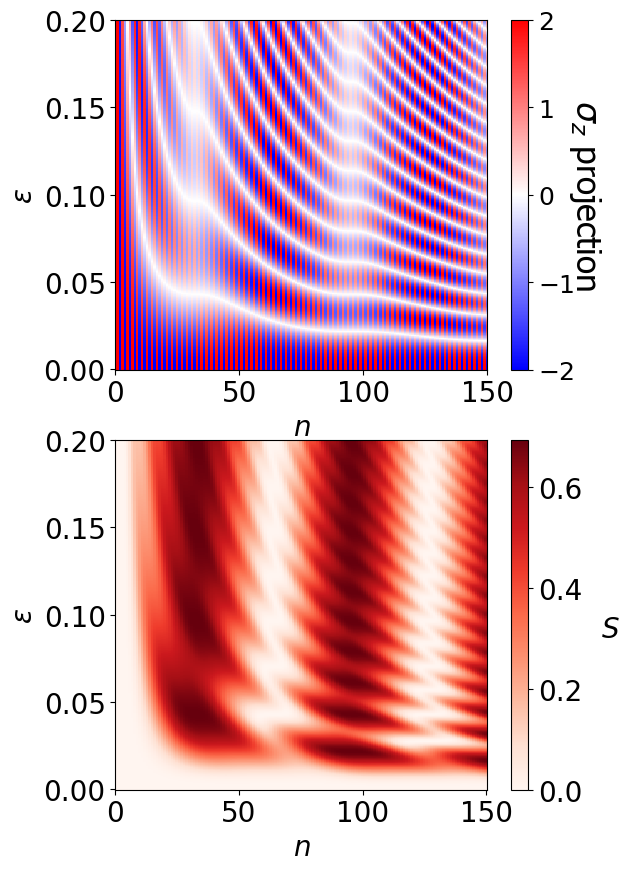

In [129]:
hfont = {'fontname':'Tahoma'}
fig, axes = plt.subplots(2,1,figsize=(6, 10))
p = axes[0].pcolor(times, eps, Observables, cmap=cm.bwr, shading='auto')
axes[0].tick_params(axis='x', labelsize=20)
axes[0].tick_params(axis='y', labelsize=20)
axes[0].set_xlabel(r'$n$', fontsize=20, **hfont)
axes[0].set_ylabel(r'$\epsilon$', fontsize=20, **hfont)
axes[0].set_xlim((1, time_steps))
cb = fig.colorbar(p, ax=axes[0])
cb.set_label(r'$\sigma_z$ projection', labelpad=20, rotation=270, fontsize=24, **hfont)
cb.ax.tick_params(labelsize=18)
ymin, ymax = axes[0].get_ylim()
axes[0].set_yticks(np.round(np.linspace(ymin, ymax, 5), 2))
xmin, xmax = axes[0].get_xlim()
axes[0].set_xticks(np.round(np.linspace(xmin-1, xmax, 4), 2))

p = axes[1].pcolor(times, eps, PEntropy, cmap=cm.Reds, shading='auto')
axes[1].tick_params(axis='x', labelsize=20)
axes[1].tick_params(axis='y', labelsize=20)
axes[1].set_xlabel(r'$n$', fontsize=20, **hfont)
axes[1].set_ylabel(r'$\epsilon$', fontsize=20, **hfont)
cb = fig.colorbar(p, ax=axes[1])
cb.set_label(r'$S$', labelpad=20, rotation=0, fontsize=20, **hfont)
cb.ax.tick_params(labelsize=20)
ymin, ymax = axes[1].get_ylim()
axes[1].set_yticks(np.round(np.linspace(ymin, ymax, 5), 2))
xmin, xmax = axes[1].get_xlim()
axes[1].set_xticks(np.round(np.linspace(xmin-0.5, xmax-0.5, 4), 2))

(0.0, 150.0)

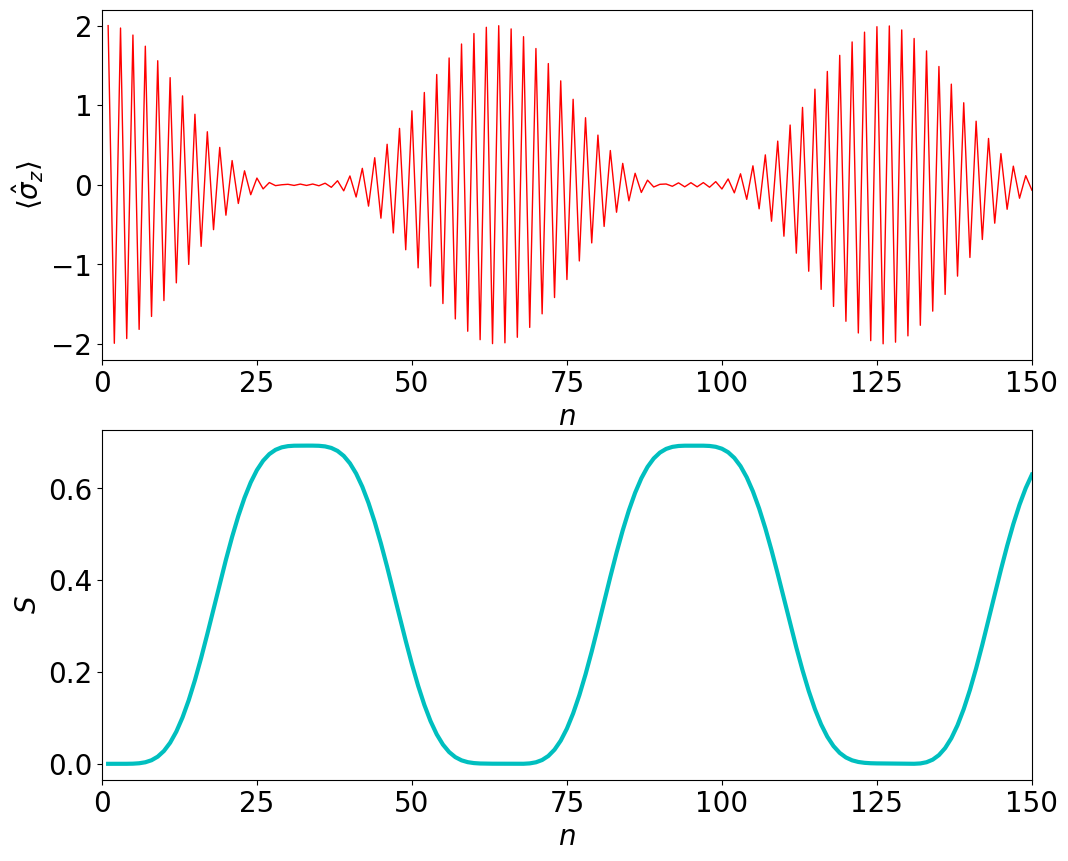

In [31]:
number =  65 #65*2 #222 #65  # 55, 109, 154 , 244
hfont = {'fontname':'Tahoma'}
fig, axes = plt.subplots(2,1,figsize=(12, 10))
p = axes[0].plot(times, Observables[number], 'r', linewidth=1.0)
axes[0].set_xlabel(r'$n$', fontsize=20, **hfont)
axes[0].set_ylabel(r'$\langle \hat{\sigma}_z \rangle$', fontsize=20, rotation=90, **hfont)
axes[0].tick_params(axis='x', labelsize=20)
axes[0].tick_params(axis='y', labelsize=20)
axes[0].set_xticks(np.round(np.linspace(0, time_steps, 7), 2))
axes[0].set_xlim(0.0,time_steps)

p = axes[1].plot(times, PEntropy[number], 'c', linewidth=3.0)
axes[1].set_xlabel(r'$n$', fontsize=20, **hfont)
axes[1].set_ylabel(r'$S$', fontsize=20, **hfont)
axes[1].tick_params(axis='x', labelsize=20)
axes[1].tick_params(axis='y', labelsize=20)
xmin, xmax = axes[1].get_xlim()
axes[1].set_xticks(np.round(np.linspace(0, time_steps, 7), 2))
axes[1].set_yticks(np.round(np.linspace(0, 0.6, 4), 2))
axes[1].set_xlim(0.0,time_steps)

### Matual variance and Robertson–Schrödinger uncertainty calculation

In [347]:
sx1  = Qobj(tensor(sigmax(), qeye(2)).full())    # \sigma_x operator of the 1t qubit
sx2  = Qobj(tensor(qeye(2), sigmax()).full())    # \sigma_x operator of the 2d qubit

sy1  = Qobj(tensor(sigmay(), qeye(2)).full())    # \sigma_y operator of the 1t qubit
sy2  = Qobj(tensor(qeye(2), sigmay()).full())    # \sigma_y operator of the 2d qubit

sz1  = Qobj(tensor(sigmaz(), qeye(2)).full())    # \sigma_z operator of the 1t qubit
sz2  = Qobj(tensor(qeye(2), sigmaz()).full())    # \sigma_z operator of the 2d qubit

In [348]:
phi_test = Qobj(Statess[number][0])
phi_test

Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[0.70710678]
 [0.        ]
 [0.        ]
 [0.70710678]]

In [349]:
commutator(sz1,sz2, kind="normal")

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

In [350]:
expect(commutator(sz1,sz2, kind="normal") , phi_test)

0.0

In [351]:
commutator(sz1,sz2, kind="anti")

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 2.  0.  0.  0.]
 [ 0. -2.  0.  0.]
 [ 0.  0. -2.  0.]
 [ 0.  0.  0.  2.]]

In [352]:
expect(commutator(sz1,sz2, kind="anti") , phi_test) - expect(sz1, phi_test)*expect(sz2, phi_test)

1.9999999999999996

In [353]:
2*expect(sz1*sz2 , phi_test) - expect(sz1, phi_test)*expect(sz2, phi_test)

1.9999999999999996

In [354]:
print('Expectation value of the  first qubit \sigma_z: ', round(expect(sz1, phi_test), 4))
print('Expectation value of the second qubit \sigma_z: ', round(expect(sz2, phi_test), 4))
print('Variance of the  first qubit \sigma_z: ', round(sqrt(variance(sz1, phi_test)), 4))
print('Variance of the second qubit \sigma_z: ', round(sqrt(variance(sz2, phi_test)), 4))

print('Matual variance of two qubits: ', matual_variance(sz1, sz2, phi_test))
print('Robertson–Schrödinger uncertainty of two qubits: ', SR_uncertainty(sz1, sz2, phi_test))
print('Correlation coefficient for two qubits: ', correlation_coefficient(sz1, sz2, phi_test))
print('Correlation efficiency for two qubits: ', correlation_efficiency(correlation_coefficient(sz1, sz2, phi_test)))

print('Robertson–Schrödinger uncertainty of two qubits Ebobo: ', SR_uncertainty_ebobo(sz1, sz2, phi_test))
print('Robertson–Schrödinger uncertainty of two qubits no correlation: ', SR_uncertainty_no_corr(sz1, sz2, phi_test))

Expectation value of the  first qubit \sigma_z:  0.0
Expectation value of the second qubit \sigma_z:  0.0
Variance of the  first qubit \sigma_z:  1.0
Variance of the second qubit \sigma_z:  1.0
Matual variance of two qubits:  0.9999999999999998
Robertson–Schrödinger uncertainty of two qubits:  0.9999999999999996
Correlation coefficient for two qubits:  1.0
Correlation efficiency for two qubits:  inf
Robertson–Schrödinger uncertainty of two qubits Ebobo:  nan
Robertson–Schrödinger uncertainty of two qubits no correlation:  0.0


<ipython-input-259-c469b5131ba9>:40: RuntimeWarning: invalid value encountered in double_scalars
  return abs(expect(commutator(A,B, kind="normal") , psi))**2/4/(1-correlation_coefficient(A, B, psi)**2)


In [355]:
operator1 = sz1
operator2 = sz2

Exp1 = []
Exp2 = []
Var1 = []
Var2 = []
RS_left = []
Mat_Var = []
RS_unc = []
Cor_coeff = []
Cor_eff = []

#RS_unc_ebobo = []
#RS_unc_no_corr = []

New_cor_coeff = []
New_Cor_eff = []
RS_left_sqrt = []
RS_right_new_coeff = []

Anticommmute = []
Commmute = []


for i in Statess[number]:
    phi_test = Qobj(i)
    Exp1.append(expect(operator1, phi_test))
    Exp2.append(expect(operator2, phi_test))
    Var1.append(sqrt(variance(operator1, phi_test)))
    Var2.append(sqrt(variance(operator2, phi_test)))
    RS_left.append(variance(operator1, phi_test)*variance(operator2, phi_test))
    Mat_Var.append(matual_variance(operator1, operator2, phi_test))
    RS_unc.append(SR_uncertainty(operator1, operator2, phi_test))
    Cor_coeff.append(correlation_coefficient(operator1, operator2, phi_test))
    Cor_eff.append(correlation_efficiency(correlation_coefficient(operator1, operator2, phi_test)))
    #RS_unc_ebobo.append(SR_uncertainty_ebobo(operator1, operator2, phi_test))
    #RS_unc_no_corr.append(SR_uncertainty_no_corr(operator1, operator2, phi_test))
    
    New_cor_coeff.append(correlation_coefficient_new(operator1, operator2, phi_test))
    New_Cor_eff.append(correlation_efficiency_new(correlation_coefficient_new(operator1, operator2, phi_test)))
    
    RS_left_sqrt.append(sqrt(variance(operator1, phi_test))*sqrt(variance(operator2, phi_test)))
    RS_right_new_coeff.append(1/2*correlation_efficiency_new(correlation_coefficient_new(operator1, operator2, phi_test))* expect(commutator(operator1,operator2, kind="anti") , phi_test))    
    
    Anticommmute.append(expect(commutator(sz1,sz2, kind="anti"), Qobj(i)))
    Commmute.append(expect(commutator(sz1,sz2, kind="normal"), Qobj(i)))

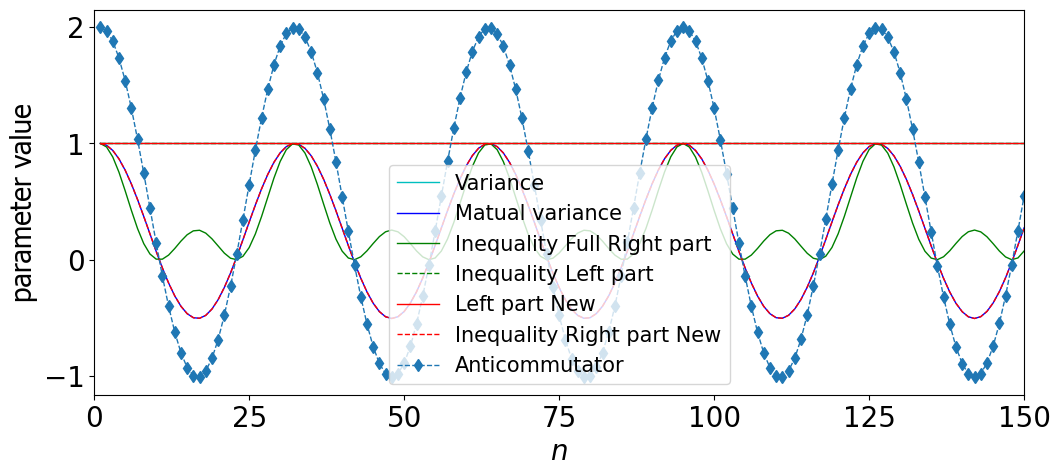

In [356]:
hfont = {'fontname':'Tahoma'}
fig, axes = plt.subplots(1,1,figsize=(12, 5))

#p = axes.plot(times, Exp1, 'r', linewidth=1.0, label="Expectation value")
p = axes.plot(times, Var1, 'c', linewidth=1.0, label="Variance")
p = axes.plot(times, Mat_Var, 'b', linewidth=1.0, label="Matual variance")

p = axes.plot(times, RS_unc, 'g', linewidth=1.0, label="Inequality Full Right part")
p = axes.plot(times, RS_left, 'g--', linewidth=1.0, label="Inequality Left part")

p = axes.plot(times, RS_left_sqrt, 'r', linewidth=1.0, label="Left part New")
p = axes.plot(times, RS_right_new_coeff, 'r--', linewidth=1.0, label="Inequality Right part New")

p = axes.plot(times, Anticommmute, 'd--', linewidth=1.0, label="Anticommutator")


axes.set_xlabel(r'$n$', fontsize=20, **hfont)
axes.set_ylabel(r'parameter value', fontsize=20, rotation=90, **hfont)
axes.tick_params(axis='x', labelsize=20)
axes.tick_params(axis='y', labelsize=20)
axes.set_xticks(np.round(np.linspace(0, time_steps, 7), 2))
axes.set_xlim(0.0,time_steps)
axes.legend()

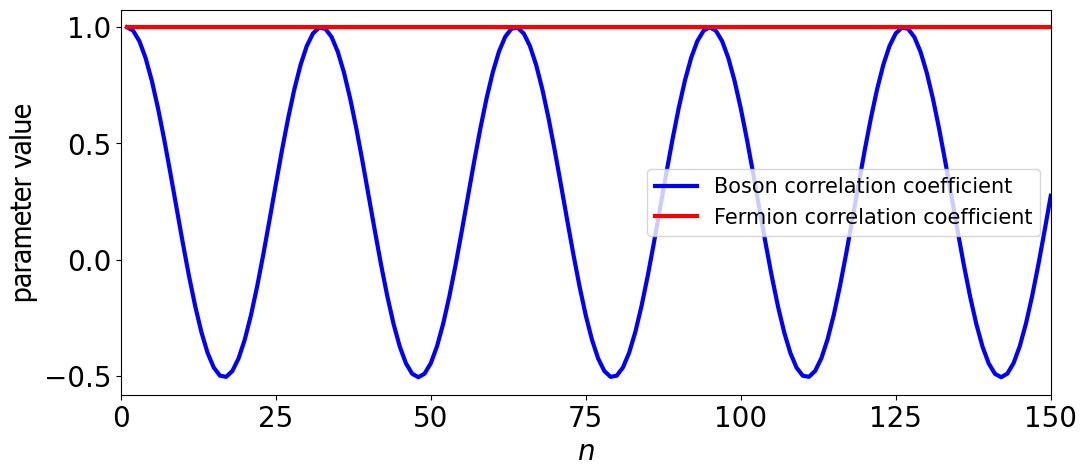

In [357]:
hfont = {'fontname':'Tahoma'}
fig, axes = plt.subplots(1,1,figsize=(12, 5))

p = axes.plot(times, Cor_coeff, 'b', linewidth=3.0, label="Boson correlation coefficient")
p = axes.plot(times, New_Cor_eff, 'r', linewidth=3.0, label="Fermion correlation coefficient")

axes.set_xlabel(r'$n$', fontsize=20, **hfont)
axes.set_ylabel(r'parameter value', fontsize=20, rotation=90, **hfont)
axes.tick_params(axis='x', labelsize=20)
axes.tick_params(axis='y', labelsize=20)
axes.set_xticks(np.round(np.linspace(0, time_steps, 7), 2))
axes.set_xlim(0.0,time_steps)
axes.legend()

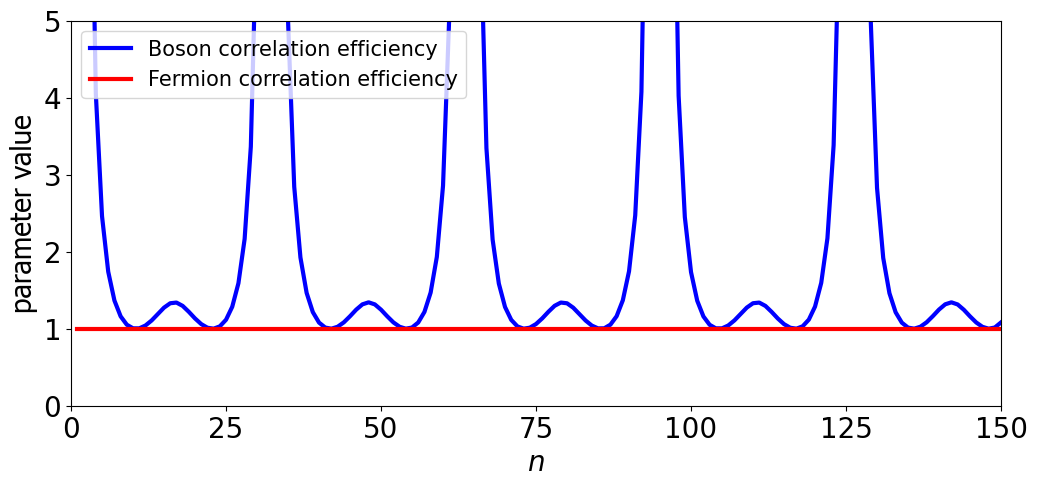

In [358]:
hfont = {'fontname':'Tahoma'}
fig, axes = plt.subplots(1,1,figsize=(12, 5))

p = axes.plot(times, Cor_eff, 'b', linewidth=3.0, label="Boson correlation efficiency")

p = axes.plot(times, New_Cor_eff, 'r', linewidth=3.0, label="Fermion correlation efficiency")

axes.set_xlabel(r'$n$', fontsize=20, **hfont)
axes.set_ylabel(r'parameter value', fontsize=20, rotation=90, **hfont)
axes.tick_params(axis='x', labelsize=20)
axes.tick_params(axis='y', labelsize=20)
axes.set_xticks(np.round(np.linspace(0, time_steps, 7), 2))
axes.set_xlim(0.0,time_steps)
axes.set_ylim(0.0,5)
axes.legend()

Fermion $\frac{1}{1+r^+},  r^+ = \frac{ \langle A \rangle  \langle B \rangle}{\sigma_A \sigma_B}$

Boson $\frac{1}{1-r^2},  r = \frac{ \sigma_{AB}}{\sigma_A \sigma_B}$

(0.0, 150.0)

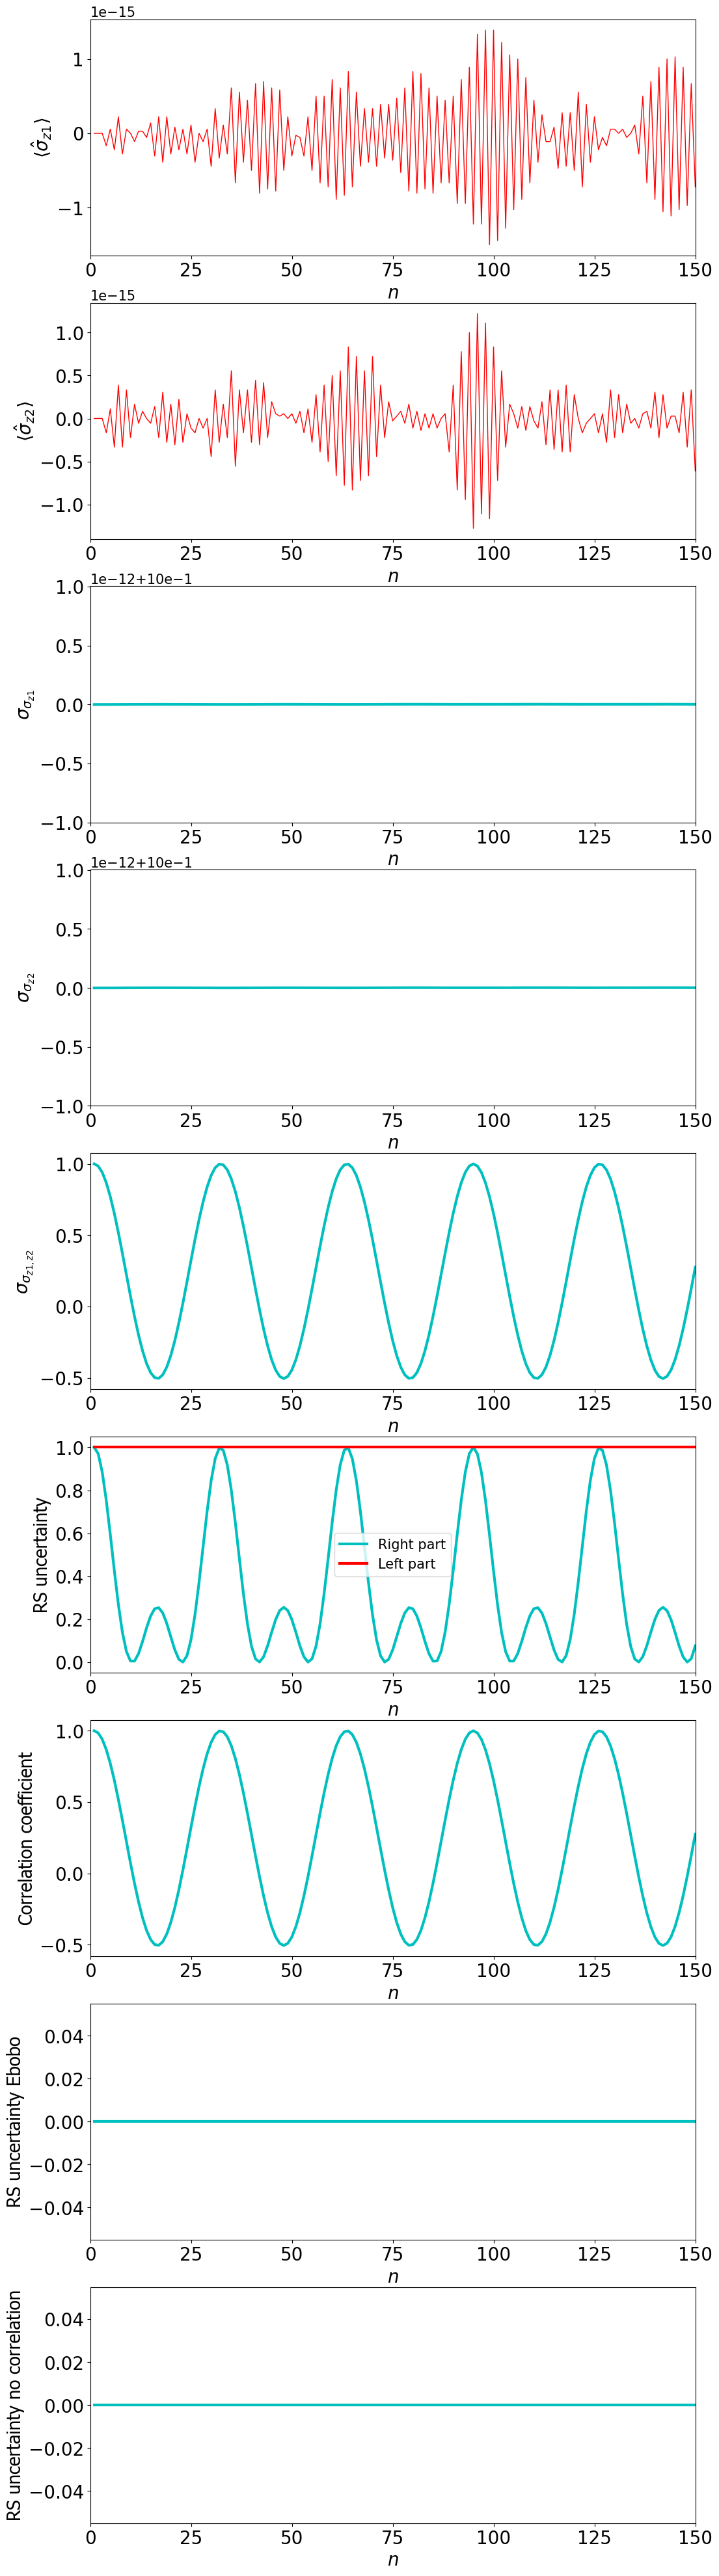

In [359]:
hfont = {'fontname':'Tahoma'}
fig, axes = plt.subplots(9,1,figsize=(12, 50))
p = axes[0].plot(times, Exp1, 'r', linewidth=1.0)
axes[0].set_xlabel(r'$n$', fontsize=20, **hfont)
axes[0].set_ylabel(r'$\langle \hat{\sigma}_{z1} \rangle$', fontsize=20, rotation=90, **hfont)
axes[0].tick_params(axis='x', labelsize=20)
axes[0].tick_params(axis='y', labelsize=20)
axes[0].set_xticks(np.round(np.linspace(0, time_steps, 7), 2))
axes[0].set_xlim(0.0,time_steps)

p = axes[1].plot(times, Exp2, 'r', linewidth=1.0)
axes[1].set_xlabel(r'$n$', fontsize=20, **hfont)
axes[1].set_ylabel(r'$\langle \hat{\sigma}_{z2} \rangle$', fontsize=20, rotation=90, **hfont)
axes[1].tick_params(axis='x', labelsize=20)
axes[1].tick_params(axis='y', labelsize=20)
axes[1].set_xticks(np.round(np.linspace(0, time_steps, 7), 2))
axes[1].set_xlim(0.0,time_steps)

p = axes[2].plot(times, Var1, 'c', linewidth=3.0)
axes[2].set_xlabel(r'$n$', fontsize=20, **hfont)
axes[2].set_ylabel(r'$\sigma_{\sigma_{z1}}$', fontsize=20, **hfont)
axes[2].tick_params(axis='x', labelsize=20)
axes[2].tick_params(axis='y', labelsize=20)
xmin, xmax = axes[2].get_xlim()
axes[2].set_xticks(np.round(np.linspace(0, time_steps, 7), 2))
#axes[2].set_yticks(np.round(np.linspace(0, 0.6, 4), 2))
axes[2].set_xlim(0.0,time_steps)

p = axes[3].plot(times, Var2, 'c', linewidth=3.0)
axes[3].set_xlabel(r'$n$', fontsize=20, **hfont)
axes[3].set_ylabel(r'$\sigma_{\sigma_{z2}}$', fontsize=20, **hfont)
axes[3].tick_params(axis='x', labelsize=20)
axes[3].tick_params(axis='y', labelsize=20)
xmin, xmax = axes[3].get_xlim()
axes[3].set_xticks(np.round(np.linspace(0, time_steps, 7), 2))
#axes[3].set_yticks(np.round(np.linspace(0, 0.6, 4), 2))
axes[3].set_xlim(0.0,time_steps)

p = axes[4].plot(times, Mat_Var, 'c', linewidth=3.0)
axes[4].set_xlabel(r'$n$', fontsize=20, **hfont)
axes[4].set_ylabel(r'$\sigma_{\sigma_{z1,z2}}$', fontsize=20, **hfont)
axes[4].tick_params(axis='x', labelsize=20)
axes[4].tick_params(axis='y', labelsize=20)
xmin, xmax = axes[4].get_xlim()
axes[4].set_xticks(np.round(np.linspace(0, time_steps, 7), 2))
#axes[4].set_yticks(np.round(np.linspace(0, 0.6, 4), 2))
axes[4].set_xlim(0.0,time_steps)

p = axes[5].plot(times, RS_unc, 'c', linewidth=3.0, label="Right part")
p = axes[5].plot(times, RS_left, 'r', linewidth=3.0, label="Left part")
axes[5].set_xlabel(r'$n$', fontsize=20, **hfont)
axes[5].set_ylabel(r'RS uncertainty', fontsize=20, **hfont)
axes[5].tick_params(axis='x', labelsize=20)
axes[5].tick_params(axis='y', labelsize=20)
xmin, xmax = axes[5].get_xlim()
axes[5].set_xticks(np.round(np.linspace(0, time_steps, 7), 2))
#axes[5].set_yticks(np.round(np.linspace(0, 0.6, 4), 2))
axes[5].set_xlim(0.0,time_steps)
axes[5].legend()

p = axes[6].plot(times, Cor_coeff, 'c', linewidth=3.0)
axes[6].set_xlabel(r'$n$', fontsize=20, **hfont)
axes[6].set_ylabel(r'Correlation coefficient', fontsize=20, **hfont)
axes[6].tick_params(axis='x', labelsize=20)
axes[6].tick_params(axis='y', labelsize=20)
xmin, xmax = axes[6].get_xlim()
axes[6].set_xticks(np.round(np.linspace(0, time_steps, 7), 2))
#axes[6].set_yticks(np.round(np.linspace(0, 0.6, 4), 2))
axes[6].set_xlim(0.0,time_steps)

p = axes[7].plot(times, RS_unc_ebobo, 'c', linewidth=3.0)
axes[7].set_xlabel(r'$n$', fontsize=20, **hfont)
axes[7].set_ylabel(r'RS uncertainty Ebobo', fontsize=20, **hfont)
axes[7].tick_params(axis='x', labelsize=20)
axes[7].tick_params(axis='y', labelsize=20)
xmin, xmax = axes[7].get_xlim()
axes[7].set_xticks(np.round(np.linspace(0, time_steps, 7), 2))
#axes[5].set_yticks(np.round(np.linspace(0, 0.6, 4), 2))
axes[7].set_xlim(0.0,time_steps)

p = axes[8].plot(times, RS_unc_no_corr, 'c', linewidth=3.0)
axes[8].set_xlabel(r'$n$', fontsize=20, **hfont)
axes[8].set_ylabel(r'RS uncertainty no correlation', fontsize=20, **hfont)
axes[8].tick_params(axis='x', labelsize=20)
axes[8].tick_params(axis='y', labelsize=20)
xmin, xmax = axes[8].get_xlim()
axes[8].set_xticks(np.round(np.linspace(0, time_steps, 7), 2))
#axes[5].set_yticks(np.round(np.linspace(0, 0.6, 4), 2))
axes[8].set_xlim(0.0,time_steps)

In [360]:
Correlation_Coefficient = np.zeros((eps_steps,time_steps), dtype=float)
AntiCorrelation_Coefficient = np.zeros((eps_steps,time_steps), dtype=float)
AntiCommutator = np.zeros((eps_steps,time_steps), dtype=float)

Left_part = np.zeros((eps_steps,time_steps), dtype=float)
Right_part_full = np.zeros((eps_steps,time_steps), dtype=float)
Right_part_anti = np.zeros((eps_steps,time_steps), dtype=float)

In [361]:
for i_id, i_value in enumerate(Statess):
    for j_id, j_value in enumerate(i_value): 
        Correlation_Coefficient[i_id][j_id] = correlation_coefficient(operator1, operator2, Qobj(j_value))
        AntiCorrelation_Coefficient[i_id][j_id] = correlation_coefficient_new(operator1, operator2, Qobj(j_value))
        
        AntiCommutator[i_id][j_id] = expect(commutator(operator1,operator2, kind="anti"), Qobj(j_value))
        
        Left_part[i_id][j_id] = np.sqrt(variance(operator1, Qobj(j_value)))*np.sqrt(variance(operator2, Qobj(j_value)))
        Right_part_full[i_id][j_id] = np.sqrt(SR_uncertainty(operator1, operator2, Qobj(j_value)))
        Right_part_anti[i_id][j_id] = 1/4*correlation_efficiency_new(correlation_coefficient_new(operator1, operator2, Qobj(j_value)))**2 * expect(commutator(operator1,operator2, kind="anti")**2 , Qobj(j_value))    

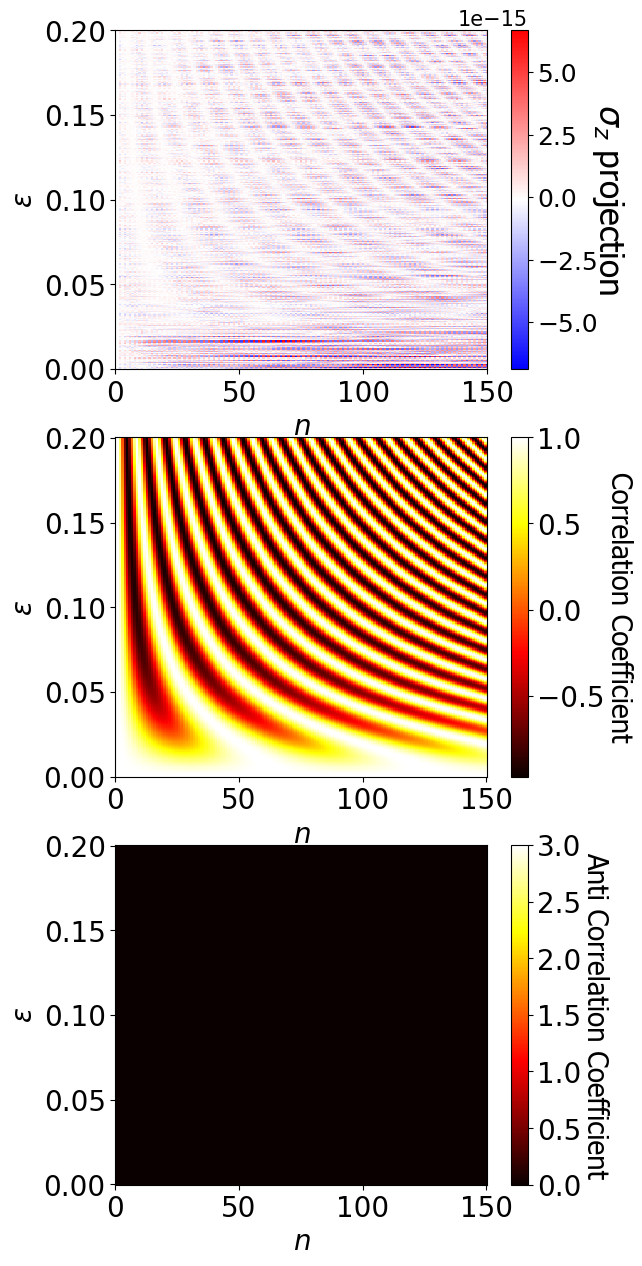

In [362]:
hfont = {'fontname':'Tahoma'}
fig, axes = plt.subplots(3,1,figsize=(6, 15))
p = axes[0].pcolor(times, eps, Observables, cmap=cm.bwr, shading='auto')
axes[0].tick_params(axis='x', labelsize=20)
axes[0].tick_params(axis='y', labelsize=20)
axes[0].set_xlabel(r'$n$', fontsize=20, **hfont)
axes[0].set_ylabel(r'$\epsilon$', fontsize=20, **hfont)
axes[0].set_xlim((1, time_steps))
cb = fig.colorbar(p, ax=axes[0])
cb.set_label(r'$\sigma_z$ projection', labelpad=20, rotation=270, fontsize=24, **hfont)
cb.ax.tick_params(labelsize=18)
ymin, ymax = axes[0].get_ylim()
axes[0].set_yticks(np.round(np.linspace(ymin, ymax, 5), 2))
xmin, xmax = axes[0].get_xlim()
axes[0].set_xticks(np.round(np.linspace(xmin-1, xmax, 4), 2))

p = axes[1].pcolor(times, eps, Correlation_Coefficient, cmap=cm.hot, shading='auto')
axes[1].tick_params(axis='x', labelsize=20)
axes[1].tick_params(axis='y', labelsize=20)
axes[1].set_xlabel(r'$n$', fontsize=20, **hfont)
axes[1].set_ylabel(r'$\epsilon$', fontsize=20, **hfont)
cb = fig.colorbar(p, ax=axes[1])
cb.set_label(r'Correlation Coefficient', labelpad=20, rotation=270, fontsize=20, **hfont)
cb.ax.tick_params(labelsize=20)
ymin, ymax = axes[1].get_ylim()
axes[1].set_yticks(np.round(np.linspace(ymin, ymax, 5), 2))
xmin, xmax = axes[1].get_xlim()
axes[1].set_xticks(np.round(np.linspace(xmin-0.5, xmax-0.5, 4), 2))

p = axes[2].pcolor(times, eps, AntiCorrelation_Coefficient, cmap=cm.hot, shading='auto', vmin=0, vmax=3)
axes[2].tick_params(axis='x', labelsize=20)
axes[2].tick_params(axis='y', labelsize=20)
axes[2].set_xlabel(r'$n$', fontsize=20, **hfont)
axes[2].set_ylabel(r'$\epsilon$', fontsize=20, **hfont)
cb = fig.colorbar(p, ax=axes[2])
cb.set_label(r'Anti Correlation Coefficient', labelpad=20, rotation=270, fontsize=20, **hfont)
cb.ax.tick_params(labelsize=20)
ymin, ymax = axes[2].get_ylim()
axes[2].set_yticks(np.round(np.linspace(ymin, ymax, 5), 2))
xmin, xmax = axes[2].get_xlim()
axes[2].set_xticks(np.round(np.linspace(xmin-0.5, xmax-0.5, 4), 2))

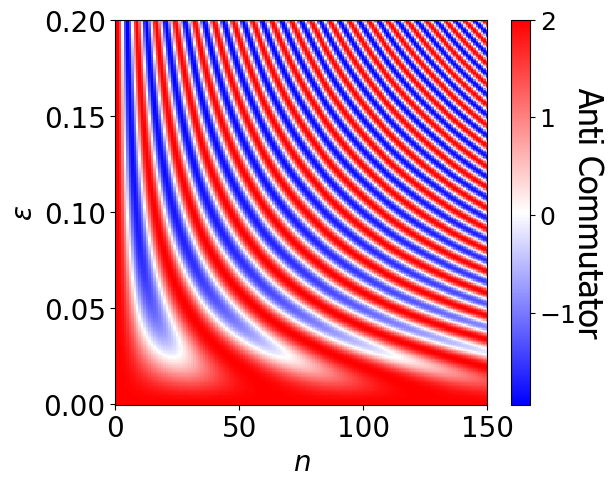

In [363]:
hfont = {'fontname':'Tahoma'}
fig, axes = plt.subplots(1,1,figsize=(6, 5))
p = axes.pcolor(times, eps, AntiCommutator, cmap=cm.bwr, shading='auto')
axes.tick_params(axis='x', labelsize=20)
axes.tick_params(axis='y', labelsize=20)
axes.set_xlabel(r'$n$', fontsize=20, **hfont)
axes.set_ylabel(r'$\epsilon$', fontsize=20, **hfont)
axes.set_xlim((1, time_steps))
cb = fig.colorbar(p, ax=axes)
cb.set_label(r'Anti Commutator', labelpad=20, rotation=270, fontsize=24, **hfont)
cb.ax.tick_params(labelsize=18)
ymin, ymax = axes.get_ylim()
axes.set_yticks(np.round(np.linspace(ymin, ymax, 5), 2))
xmin, xmax = axes.get_xlim()
axes.set_xticks(np.round(np.linspace(xmin-1, xmax, 4), 2))

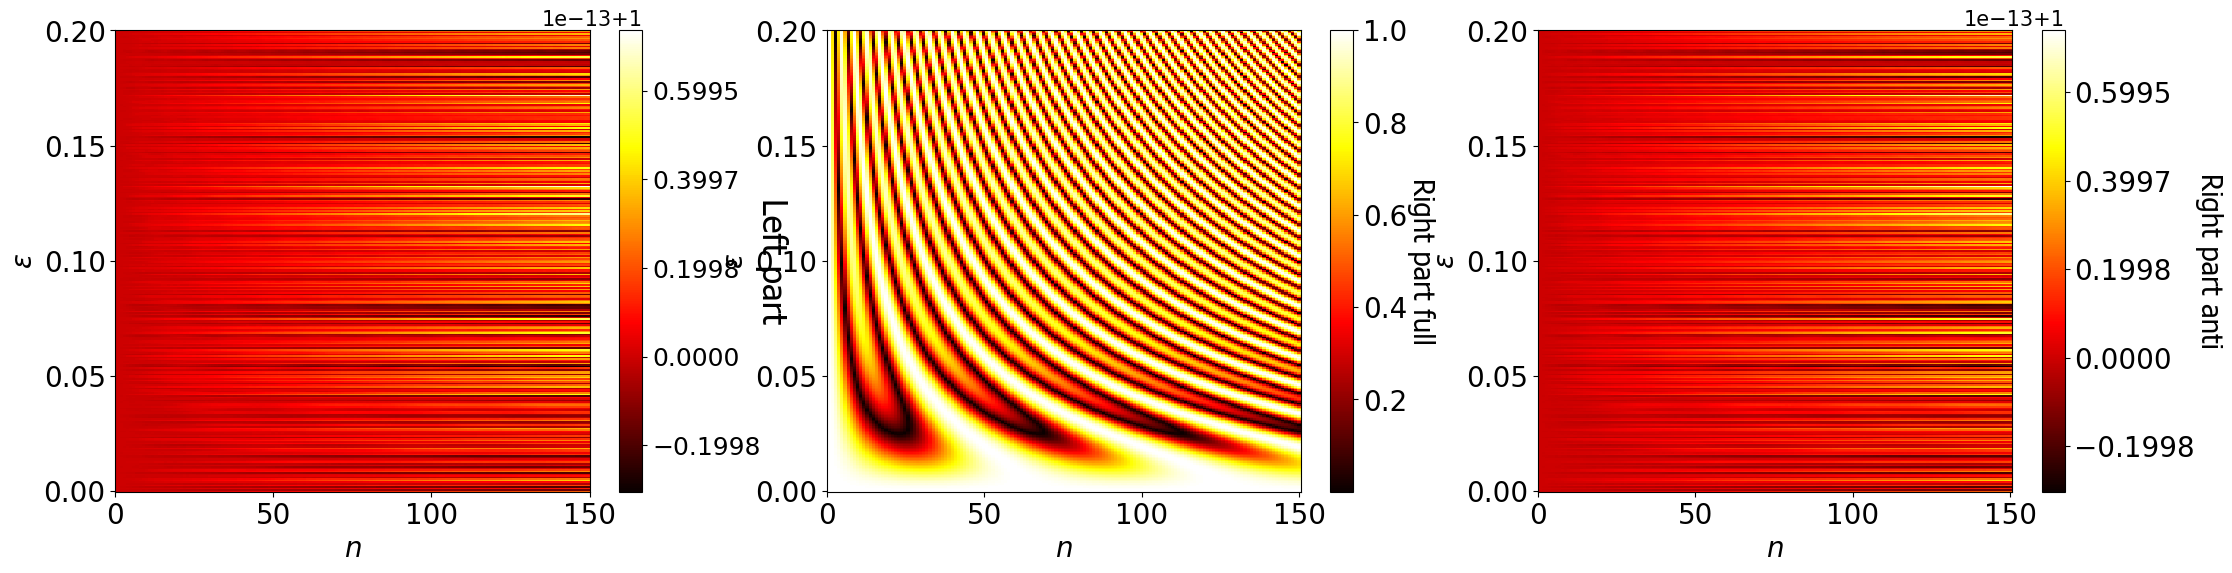

In [364]:
hfont = {'fontname':'Tahoma'}
fig, axes = plt.subplots(1,3,figsize=(26, 6))
p = axes[0].pcolor(times, eps, Left_part, cmap=cm.hot, shading='auto')
axes[0].tick_params(axis='x', labelsize=20)
axes[0].tick_params(axis='y', labelsize=20)
axes[0].set_xlabel(r'$n$', fontsize=20, **hfont)
axes[0].set_ylabel(r'$\epsilon$', fontsize=20, **hfont)
axes[0].set_xlim((1, time_steps))
cb = fig.colorbar(p, ax=axes[0])
cb.set_label(r'Left part', labelpad=20, rotation=270, fontsize=24, **hfont)
cb.ax.tick_params(labelsize=18)
ymin, ymax = axes[0].get_ylim()
axes[0].set_yticks(np.round(np.linspace(ymin, ymax, 5), 2))
xmin, xmax = axes[0].get_xlim()
axes[0].set_xticks(np.round(np.linspace(xmin-1, xmax, 4), 2))

p = axes[1].pcolor(times, eps, Right_part_full, cmap=cm.hot, shading='auto')
axes[1].tick_params(axis='x', labelsize=20)
axes[1].tick_params(axis='y', labelsize=20)
axes[1].set_xlabel(r'$n$', fontsize=20, **hfont)
axes[1].set_ylabel(r'$\epsilon$', fontsize=20, **hfont)
cb = fig.colorbar(p, ax=axes[1])
cb.set_label(r'Right part full', labelpad=20, rotation=270, fontsize=20, **hfont)
cb.ax.tick_params(labelsize=20)
ymin, ymax = axes[1].get_ylim()
axes[1].set_yticks(np.round(np.linspace(ymin, ymax, 5), 2))
xmin, xmax = axes[1].get_xlim()
axes[1].set_xticks(np.round(np.linspace(xmin-0.5, xmax-0.5, 4), 2))

p = axes[2].pcolor(times, eps, Right_part_anti, cmap=cm.hot, shading='auto')
axes[2].tick_params(axis='x', labelsize=20)
axes[2].tick_params(axis='y', labelsize=20)
axes[2].set_xlabel(r'$n$', fontsize=20, **hfont)
axes[2].set_ylabel(r'$\epsilon$', fontsize=20, **hfont)
cb = fig.colorbar(p, ax=axes[2])
cb.set_label(r'Right part anti', labelpad=20, rotation=270, fontsize=20, **hfont)
cb.ax.tick_params(labelsize=20)
ymin, ymax = axes[2].get_ylim()
axes[2].set_yticks(np.round(np.linspace(ymin, ymax, 5), 2))
xmin, xmax = axes[2].get_xlim()
axes[2].set_xticks(np.round(np.linspace(xmin-0.5, xmax-0.5, 4), 2))

$\sigma_A \sigma_B \ge \frac{1}{4} \langle \{A,B\}\rangle^2 \frac{1}{(1+r^+)^2},  r^+ = \frac{ \langle A \rangle  \langle B \rangle}{\sigma_A \sigma_B}$

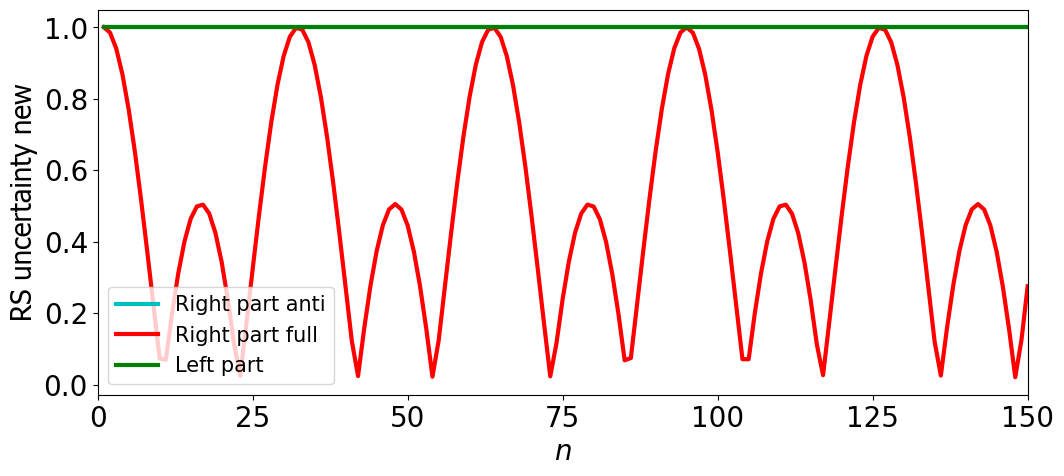

In [365]:
hfont = {'fontname':'Tahoma'}
fig, axes = plt.subplots(1,1,figsize=(12, 5))

p = axes.plot(times, Right_part_anti[number], 'c', linewidth=3.0, label="Right part anti")
p = axes.plot(times, Right_part_full[number], 'r', linewidth=3.0, label="Right part full")
p = axes.plot(times, Left_part[number], 'g', linewidth=3.0, label="Left part")
axes.set_xlabel(r'$n$', fontsize=20, **hfont)
axes.set_ylabel(r'RS uncertainty new', fontsize=20, **hfont)
axes.tick_params(axis='x', labelsize=20)
axes.tick_params(axis='y', labelsize=20)
xmin, xmax = axes.get_xlim()
axes.set_xticks(np.round(np.linspace(0, time_steps, 7), 2))
#axes[5].set_yticks(np.round(np.linspace(0, 0.6, 4), 2))
axes.set_xlim(0.0,time_steps)
axes.legend()

$\sigma_A \sigma_B \ge \frac{1}{2} \langle \{A,B\}\rangle \frac{1}{1+r^+},  r^+ = \frac{ \langle A \rangle  \langle B \rangle}{\sigma_A \sigma_B}$

### Density matrix visualization

In [26]:
def real_imagination(matrix):
    new_re = np.zeros((size(matrix[0]),size(matrix[0])), dtype=np.float)
    new_im = np.zeros((size(matrix[0]),size(matrix[0])), dtype=np.float)
    full = np.zeros((size(matrix[0]),size(matrix[0])), dtype=np.complex)
    for i in arange(size(matrix[0])):
        for j in arange(size(matrix[0])):
            new_re[i][j] = matrix[i][j].real
            new_im[i][j] = matrix[i][j].imag
            full[i][j] = matrix[i][j].real+matrix[i][j].imag*1j
    return new_re, new_im, full    

In [27]:
line = 109
period = 31

print(Observables[line][period])
print(PEntropy[line][period])

-0.640172304039175
0.5890865507876963


In [184]:
Test = RHO[line][period]

In [185]:
matrix_chop(real_imagination(Test)[0])

[[0.505, -0.004, -0.004, 0],
 [-0.004, 0, 0, 0.005],
 [-0.004, 0, 0, 0.005],
 [0, 0.005, 0.005, 0.495]]

In [186]:
matrix_chop(real_imagination(Test)[1])

[[0, 0.005, 0.005, 0.5],
 [-0.005, 0, 0, -0.004],
 [-0.005, 0, 0, -0.004],
 [-0.5, 0.004, 0.004, 0]]

In [187]:
matrix_chop(real_imagination(Test)[2])

[[(0.505+0j), (-0.004+0.005j), (-0.004+0.005j), (-0+0.5j)],
 [(-0.004-0.005j), 0, 0, (0.005-0.004j)],
 [(-0.004-0.005j), 0, 0, (0.005-0.004j)],
 [(-0-0.5j), (0.005+0.004j), (0.005+0.004j), (0.495+0j)]]

In [188]:
Test=matrix_chop(real_imagination(Test)[2])

In [189]:
evals, evecs = la.eig(Test)
Fl_vec = evecs.T
print(chop(real(-1j*log(evals))))
print(matrix_chop(Fl_vec))

[0, 3.142, -0.14, -1.314]
[[(0.711+0j), (-0.006-0.007j), (-0.006-0.007j), -0.704j], [(-0.155+0.193j), (0.659+0j), (0.659+0j), (-0.208-0.167j)], [(-0-0.61j), (0.204-0.415j), (0.168+0.117j), (0.61+0j)], [(0.001-0.004j), (0.709+0j), (-0.706-0.001j), (0.004+0.001j)]]


In [191]:
chop(real(-1j*log(evals)))[1]/chop(real(-1j*log(evals)))[3]

-2.39117199391172

In [195]:
U=Ufunc_all_to_all(nSites,alpha[line],g,T,delta)
evals, evecs = la.eig(U)
Fl_vec = evecs.T
print(chop(real(-1j*log(evals))))
print(matrix_chop(Fl_vec))

[0, -3.091, 2.991, 0.1]
[[(0.707+0j), 0, 0, (-0.707+0j)], [(0.611+0j), (0.355+0.018j), (0.355+0.018j), (0.611+0j)], [(-0.355+0.018j), (0.611+0j), (0.611+0j), (-0.355+0.018j)], [0, (0.707+0j), (-0.707+0j), 0]]


-0.0
0.0465259107165579
0.49734718160466035
0.6930958134821971


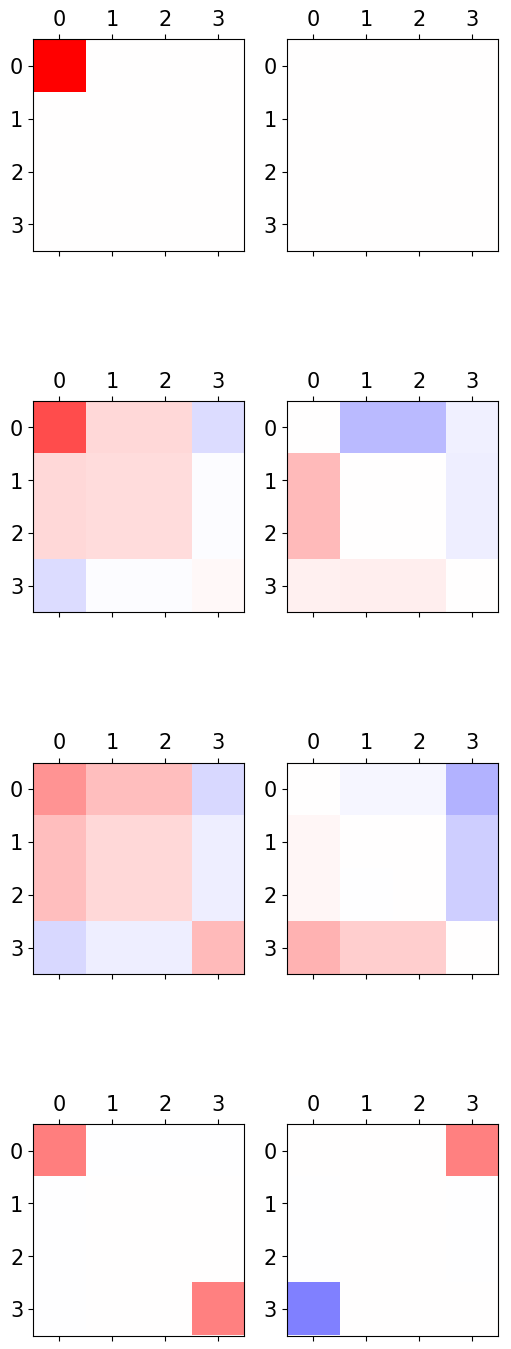

In [193]:
names = ['00', '01', '10', '11']

compare = [5,14,23]    #slope
compare = [0,10,20,31]    #platou

hfont = {'fontname':'Arial'}
fig, ax = plt.subplots(4,2,figsize=(6, 18))
    
cax = ax[0,0].matshow(real_imagination(RHO[line][compare[0]])[0], vmin=-1, vmax=1, cmap=cm.bwr)
cax = ax[0,1].matshow(real_imagination(RHO[line][compare[0]])[1], vmin=-1, vmax=1, cmap=cm.bwr)
print (PEntropy[line][compare[0]])
cax = ax[1,0].matshow(real_imagination(RHO[line][compare[1]])[0], vmin=-1, vmax=1, cmap=cm.bwr)
cax = ax[1,1].matshow(real_imagination(RHO[line][compare[1]])[1], vmin=-1, vmax=1, cmap=cm.bwr)
print (PEntropy[line][compare[1]])
cax = ax[2,0].matshow(real_imagination(RHO[line][compare[2]])[0], vmin=-1, vmax=1, cmap=cm.bwr)
cax = ax[2,1].matshow(real_imagination(RHO[line][compare[2]])[1], vmin=-1, vmax=1, cmap=cm.bwr)
print (PEntropy[line][compare[2]])
cax = ax[3,0].matshow(real_imagination(RHO[line][compare[3]])[0], vmin=-1, vmax=1, cmap=cm.bwr)
cax = ax[3,1].matshow(real_imagination(RHO[line][compare[3]])[1], vmin=-1, vmax=1, cmap=cm.bwr)
print (PEntropy[line][compare[3]])


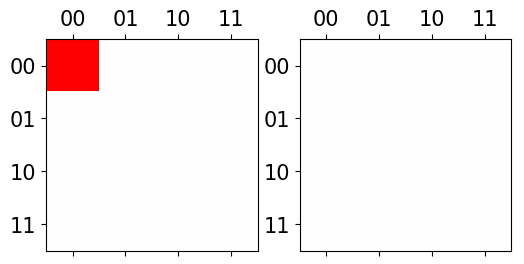

0
-0.0


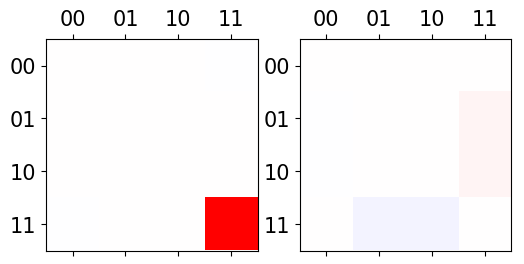

1
-2.18790521511975e-17


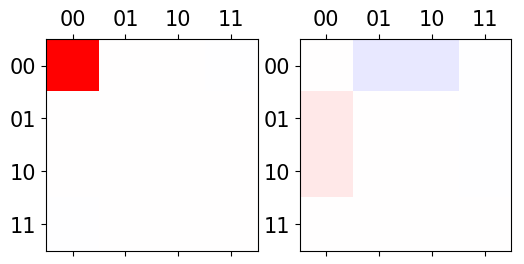

2
2.4201473481357554e-06


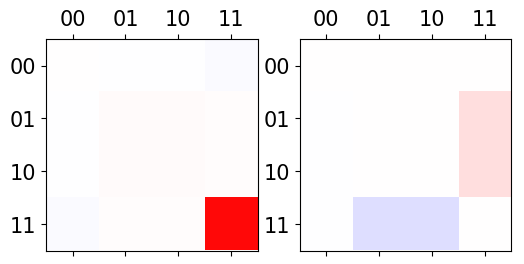

3
4.8076517404391885e-05


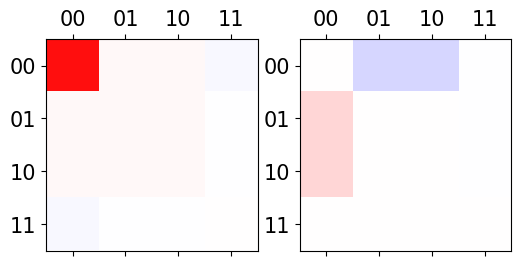

4
0.000311959404798087


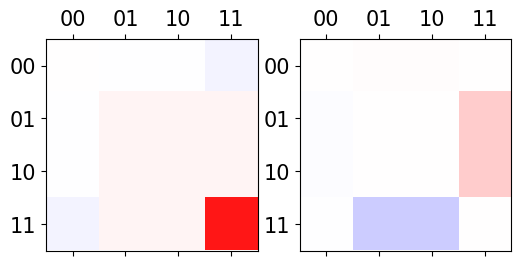

5
0.0012038348447706653


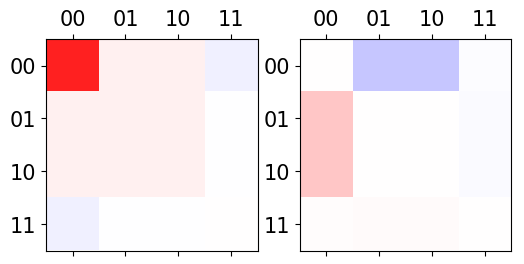

6
0.0034202033917631464


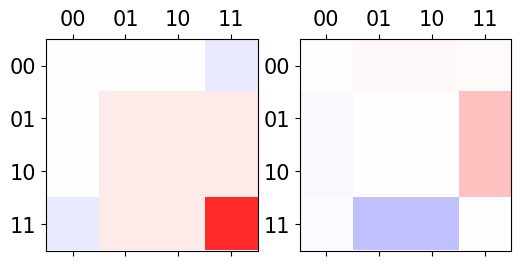

7
0.007923926749861894


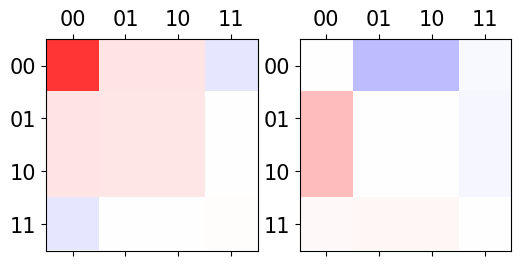

8
0.015852425430669694


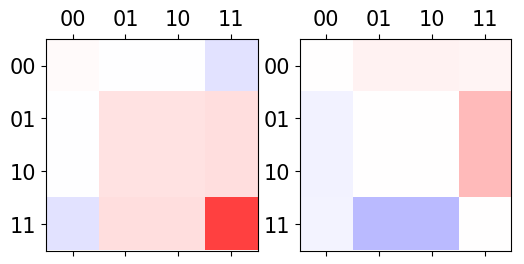

9
0.028374416498423385


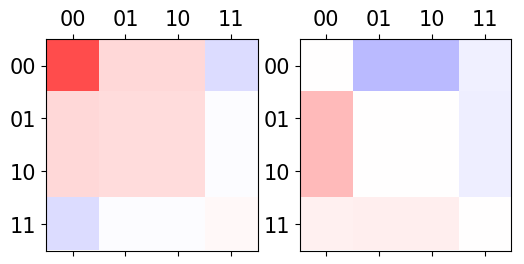

10
0.0465259107165579


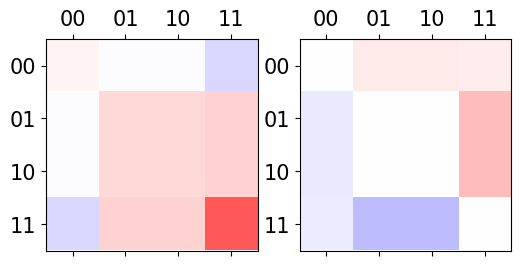

11
0.07105744719613712


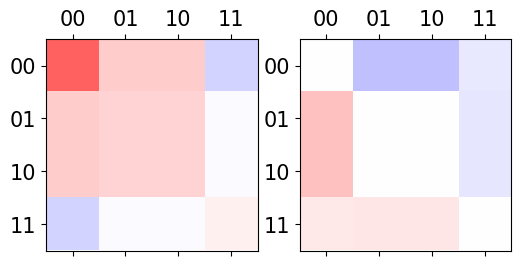

12
0.10231794833916763


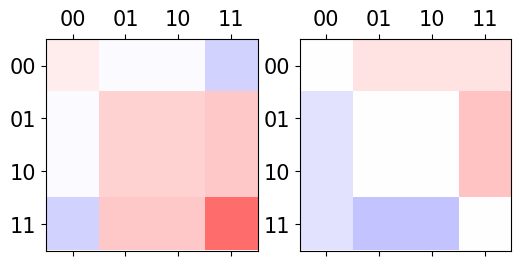

13
0.1401897957062503


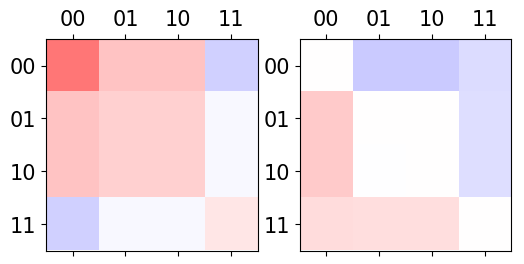

14
0.18407870175887475


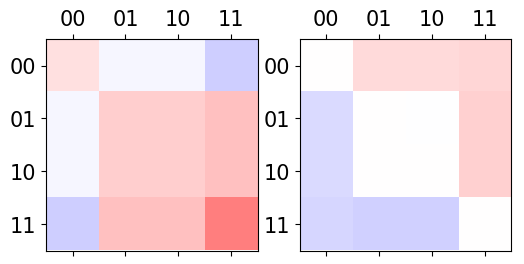

15
0.2329534028673466


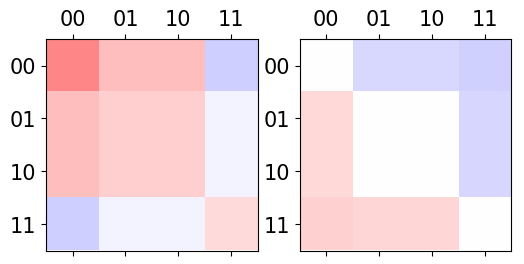

16
0.2854251085199323


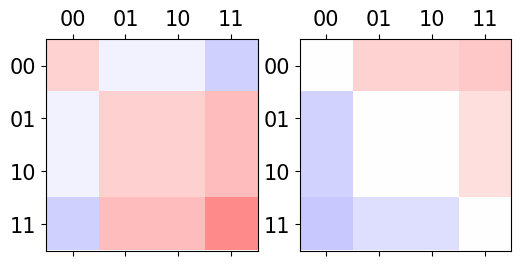

17
0.33985463863755294


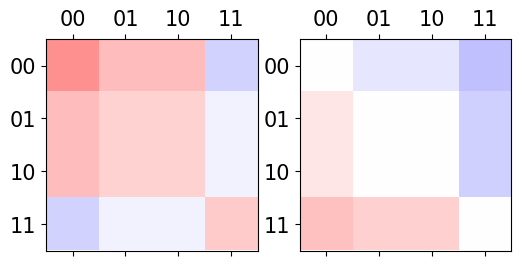

18
0.39447526901837116


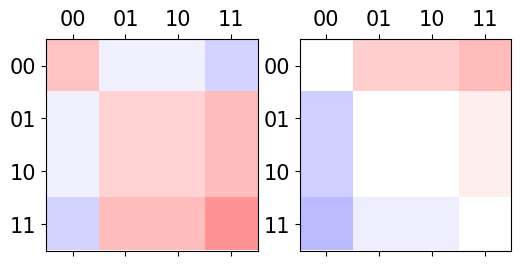

19
0.4475204657771379


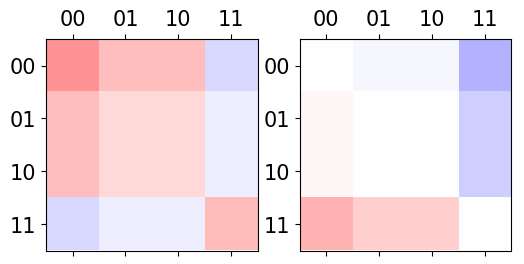

20
0.49734718160466035


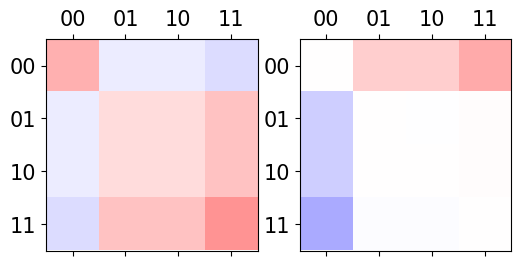

21
0.542546794790792


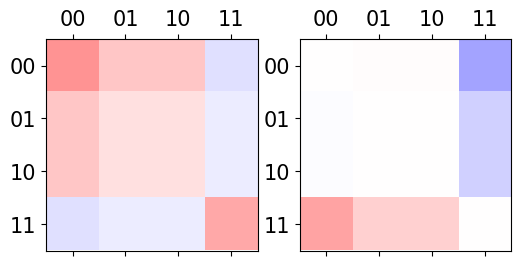

22
0.5820369363665016


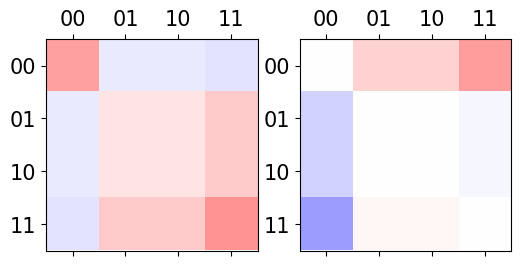

23
0.615128375477945


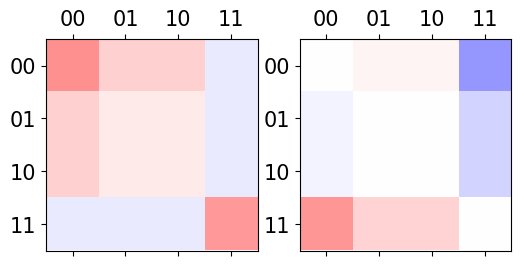

24
0.6415619259935416


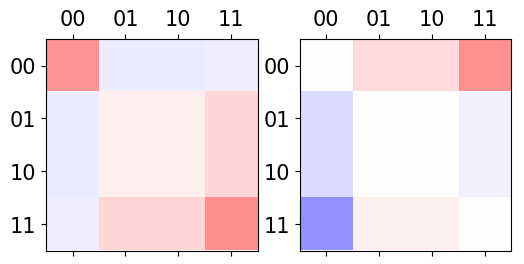

25
0.6615111923132926


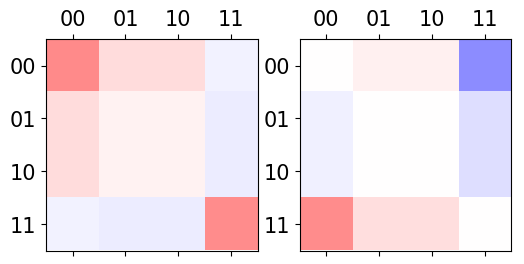

26
0.6755481817911364


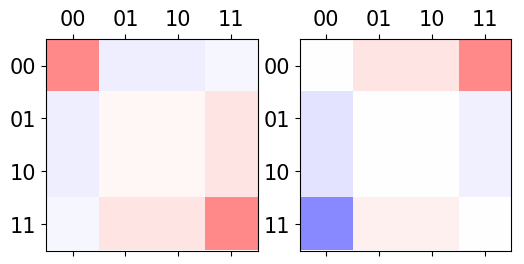

27
0.6845707742429011


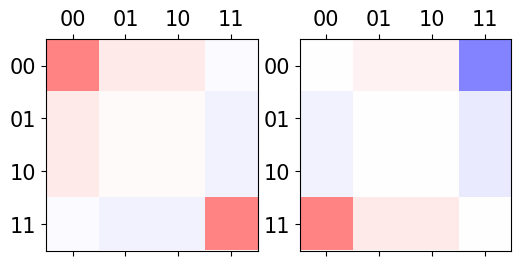

28
0.689694206408809


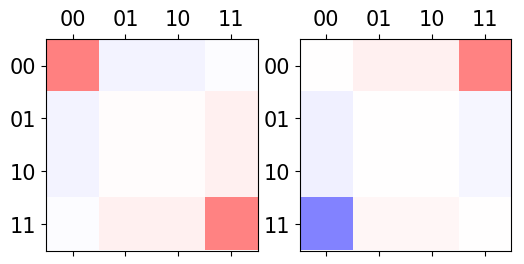

29
0.6921134070591559


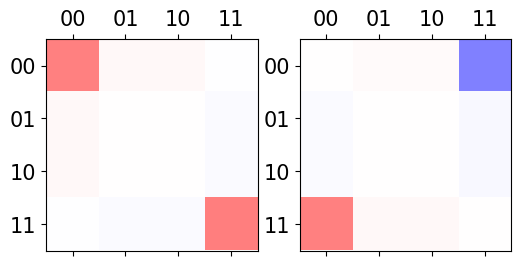

30
0.6929489911017109


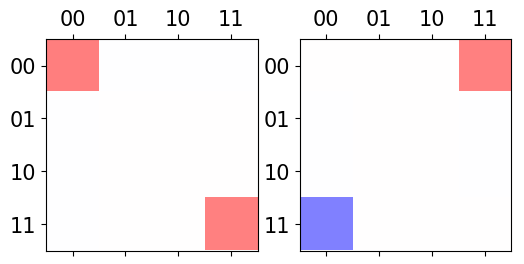

31
0.6930958134821971


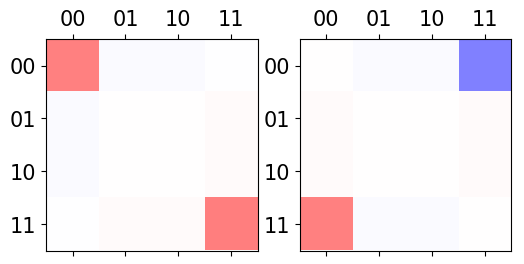

32
0.6930969463287875


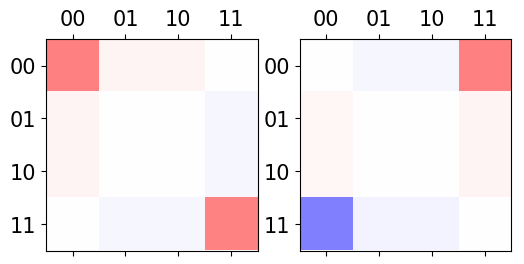

33
0.6930651538710071


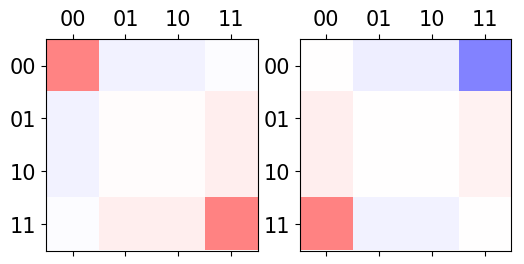

34
0.6926669644228738


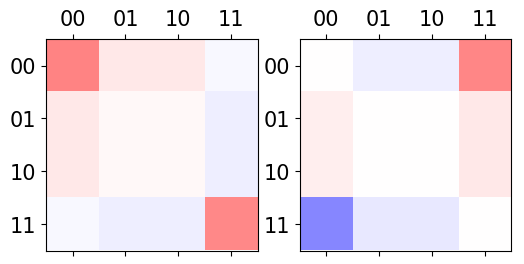

35
0.6911725061037526


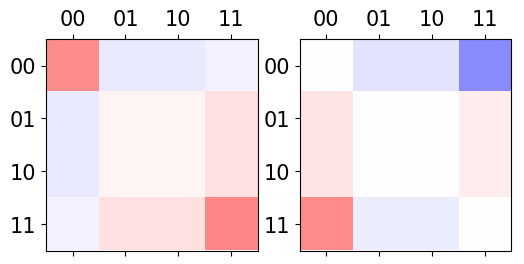

36
0.6875612281664027


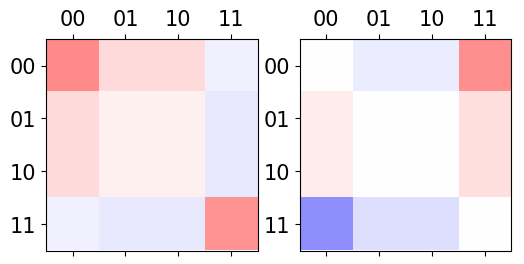

37
0.6806639503485984


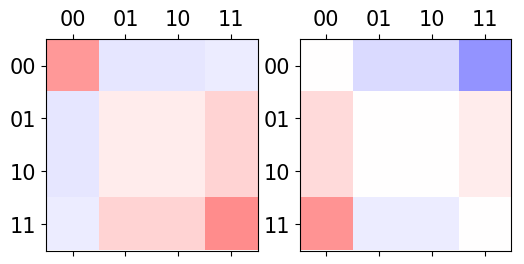

38
0.6693179878920079


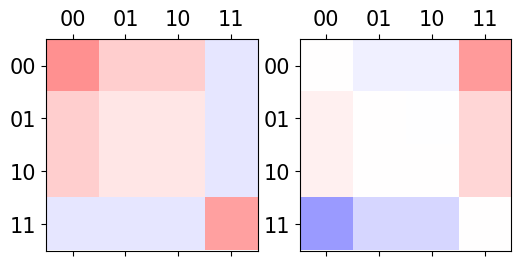

39
0.652514107832725


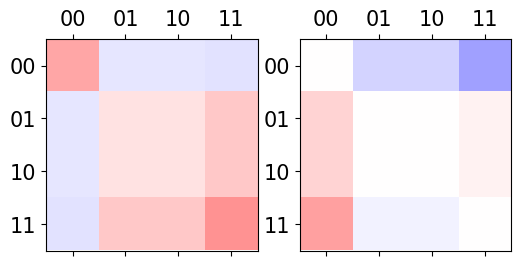

40
0.6295195022066346


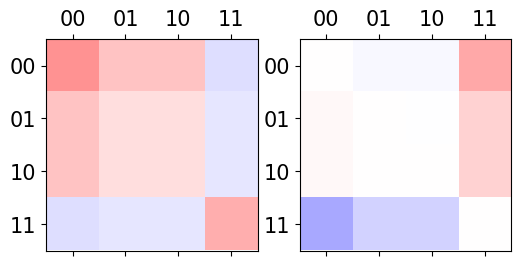

41
0.5999672343918848


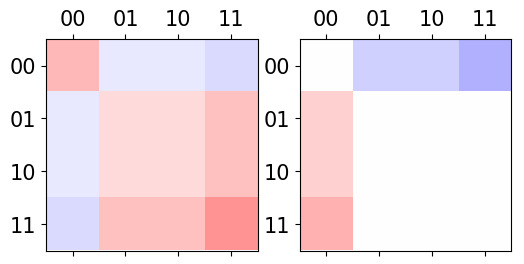

42
0.563908008263191


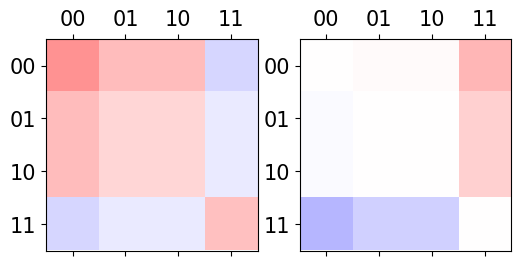

43
0.5218239985111055


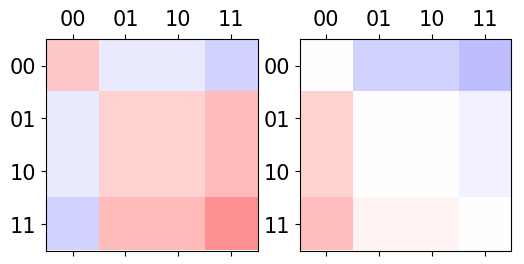

44
0.4746069795401406


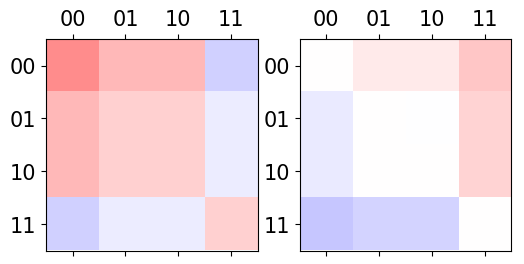

45
0.4235045200525846


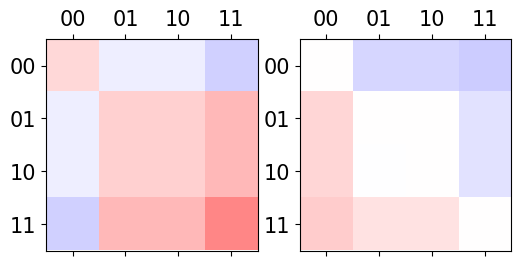

46
0.3700390107601399


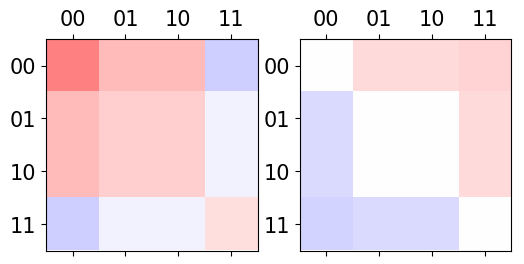

47
0.31590510903917274


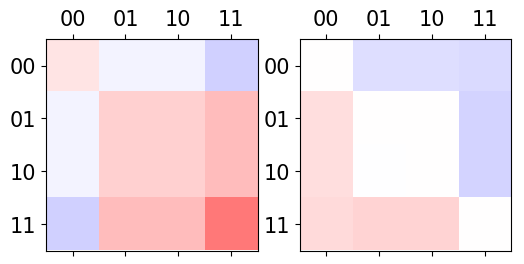

48
0.26285205296376113


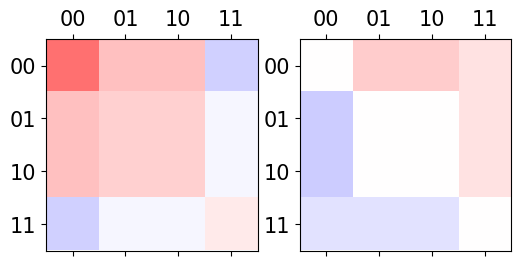

49
0.21255835882198876


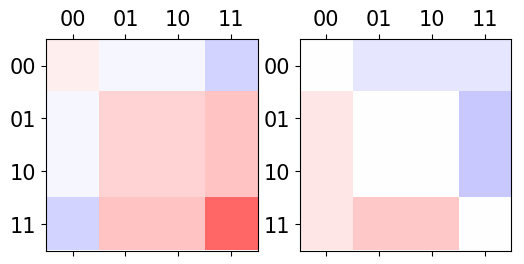

50
0.1665077131770994


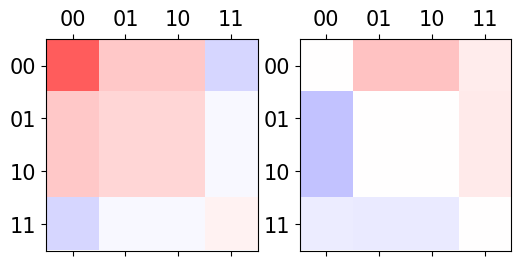

51
0.12587630525967414


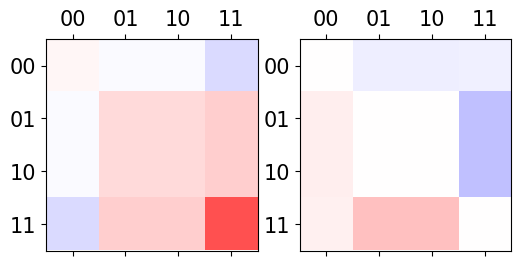

52
0.09144310349662967


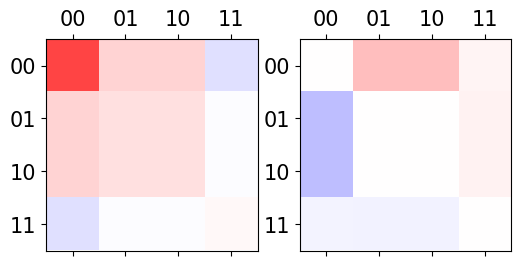

53
0.06353505103161912


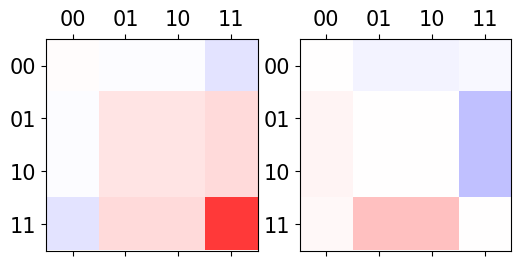

54
0.042017932819161705


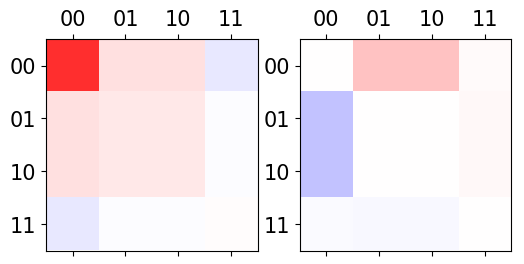

55
0.0263397442932553


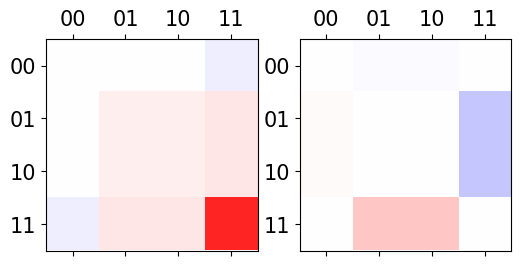

56
0.0156261381127441


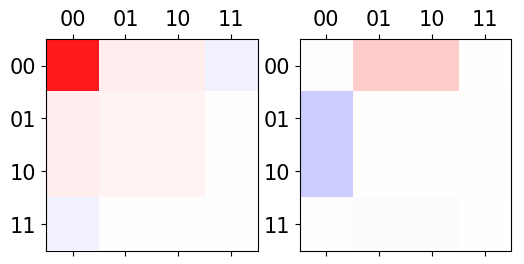

57
0.008817363276707655


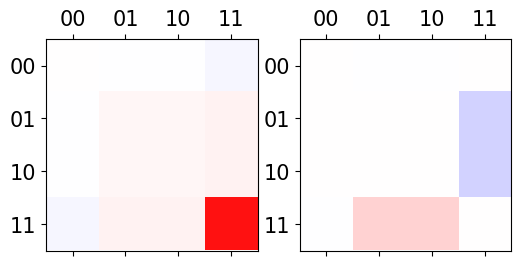

58
0.004825024677212719


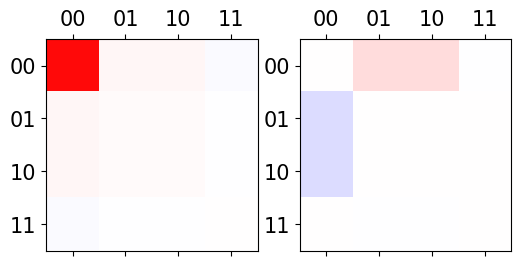

59
0.002678323716147563


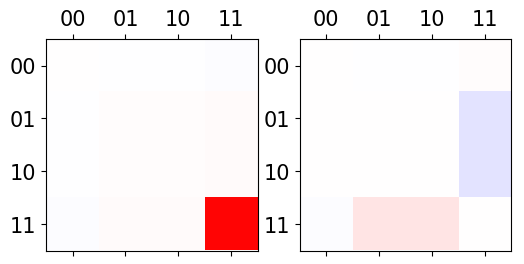

60
0.0016267712041387866


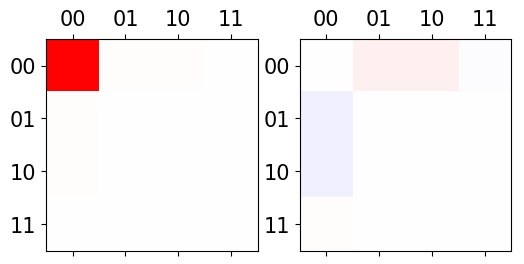

61
0.0011726918147176653


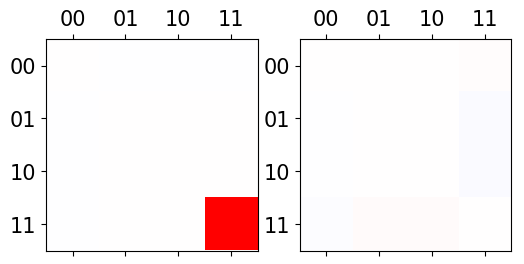

62
0.001026477620585396


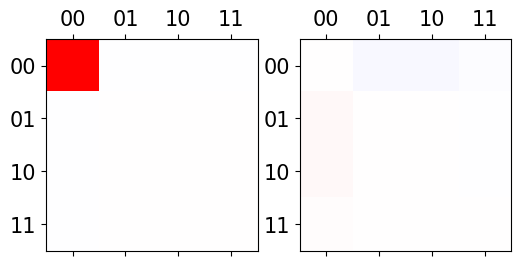

63
0.001013307445930246


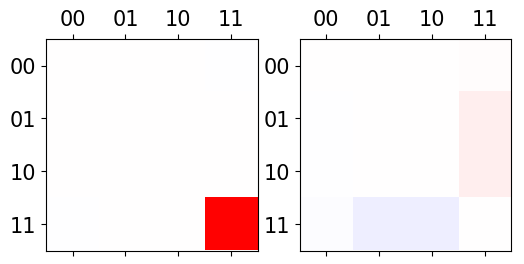

64
0.0009909879126211965


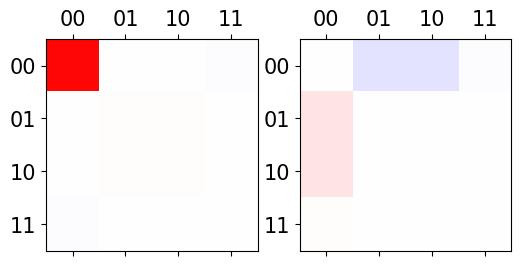

65
0.0008301296753352237


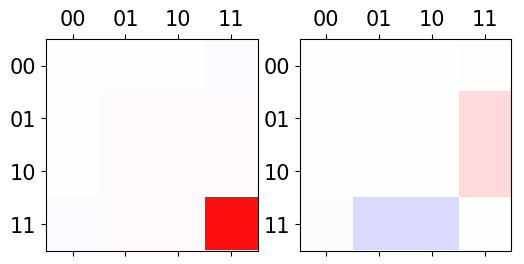

66
0.00047649279804105844


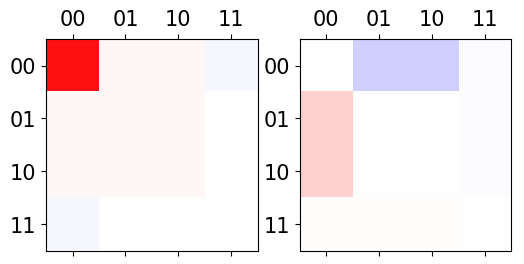

67
0.00012075505025425576


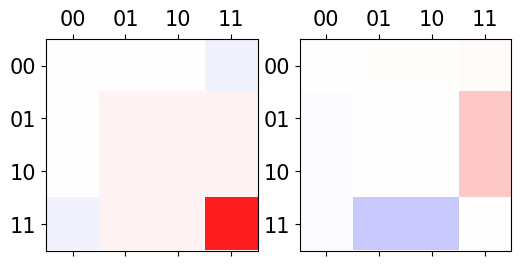

68
0.0005432062181769157


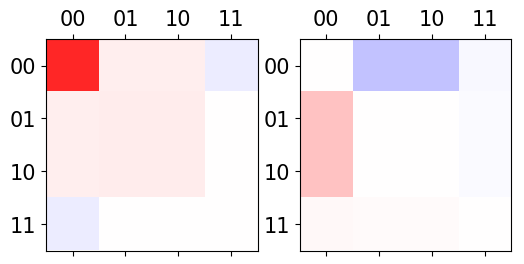

69
0.00277328947848044


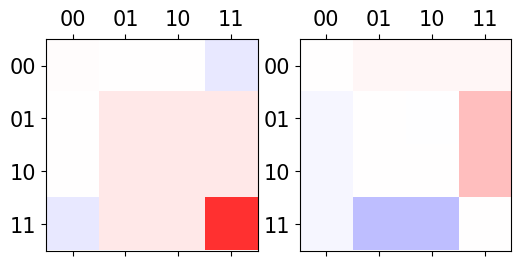

70
0.007922405942587982


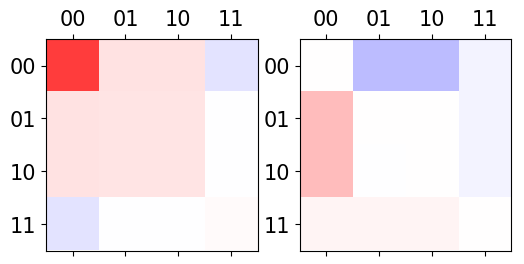

71
0.0172314970719339


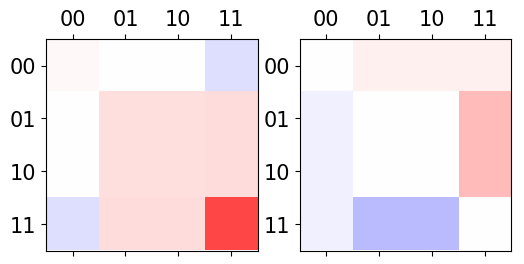

72
0.03187727527623893


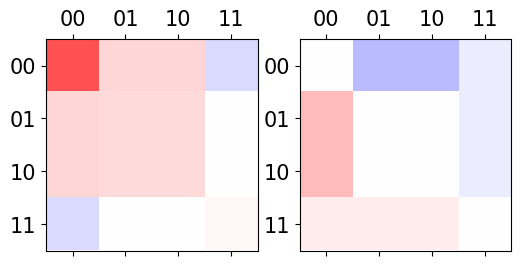

73
0.0527999433299831


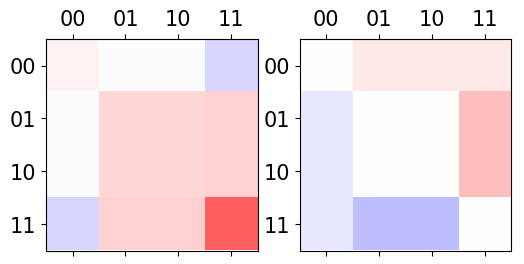

74
0.08056502927969947


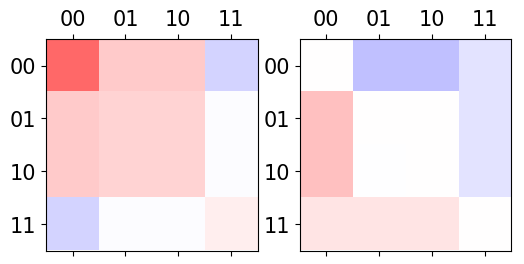

75
0.1152752241573806


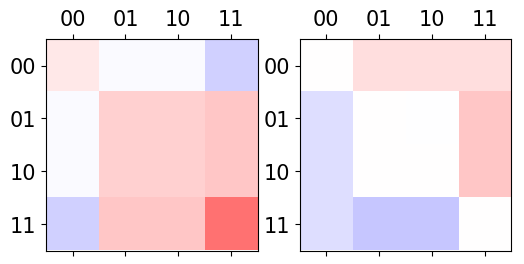

76
0.15653885722781374


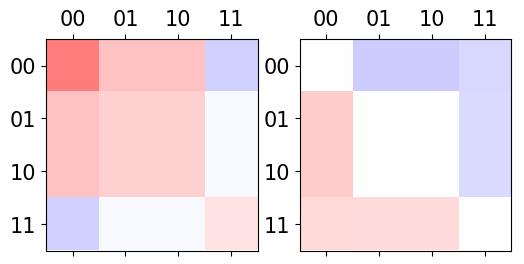

77
0.20349220746323474


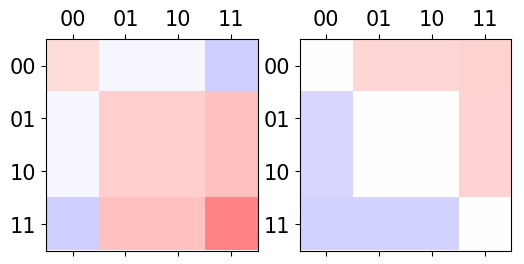

78
0.25486654764265704


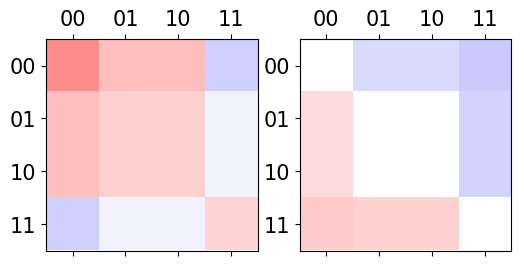

79
0.30908789335312814


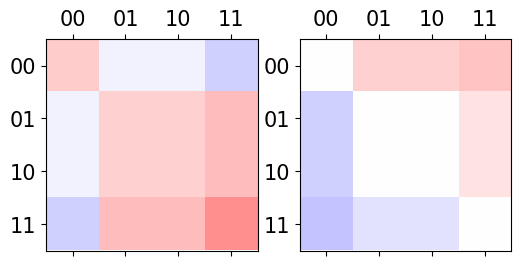

80
0.364397016932589


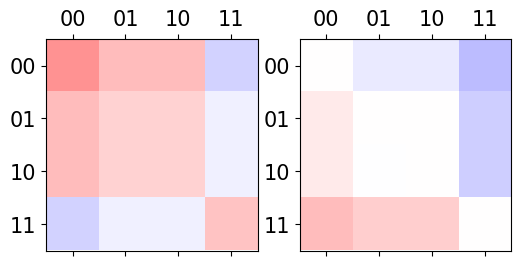

81
0.41897828566985446


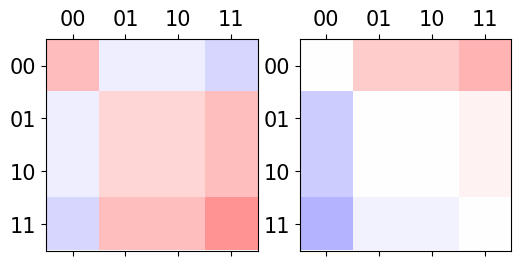

82
0.4710874131331935


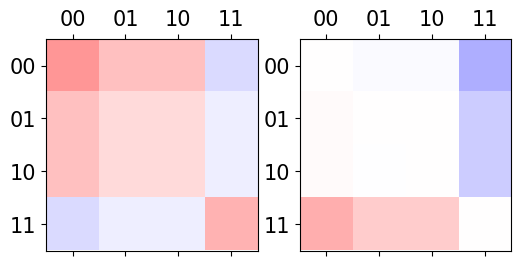

83
0.5191697390107266


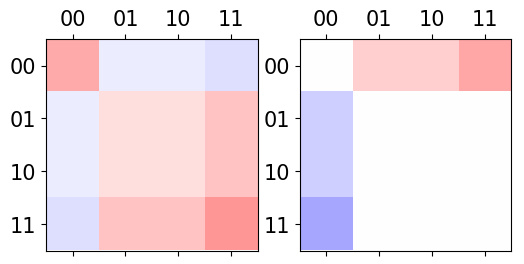

84
0.5619619407693393


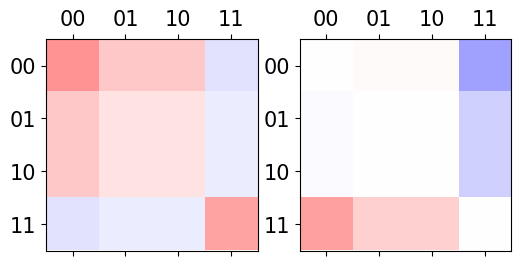

85
0.5985710911044064


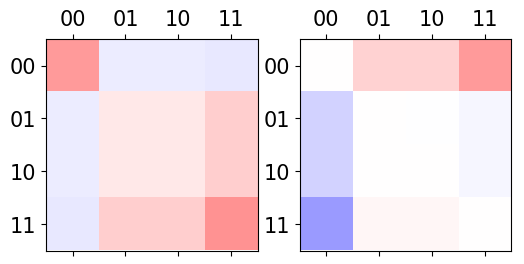

86
0.6285257868230552


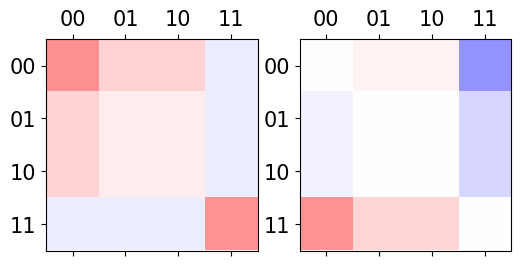

87
0.6517948472053335


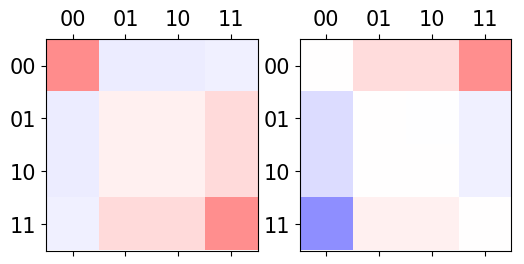

88
0.6687700579018099


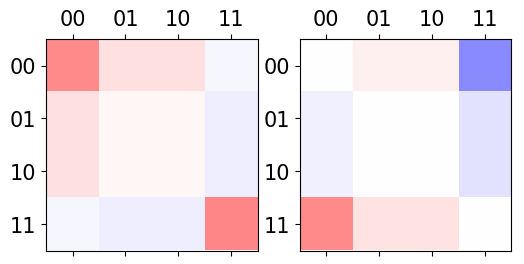

89
0.6802109683069468


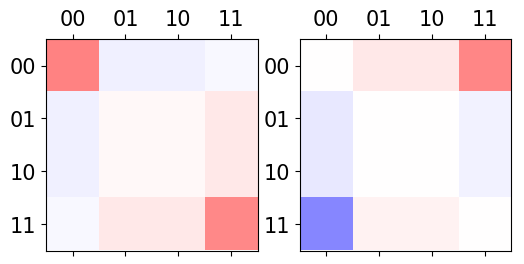

90
0.687152273592612


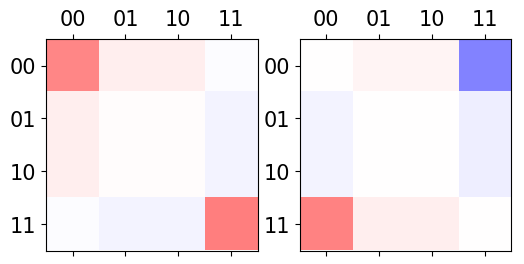

91
0.6907782358318967


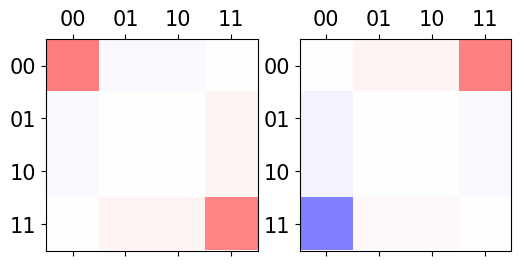

92
0.6922740106844544


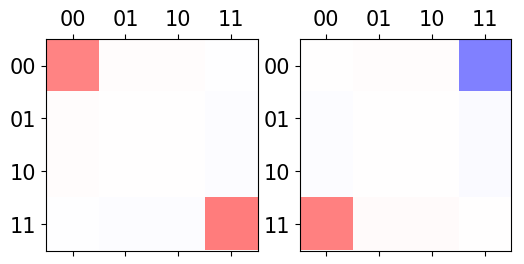

93
0.6926699774870577


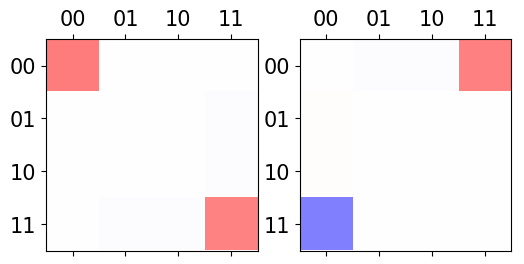

94
0.6927004610441485


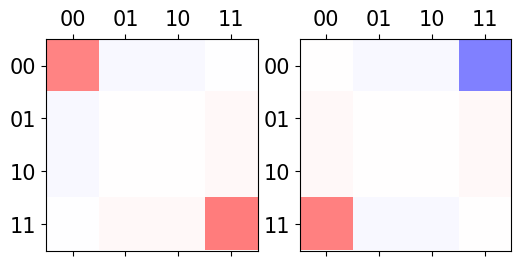

95
0.6926999919352268


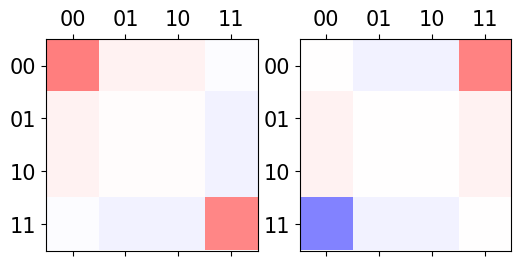

96
0.6925562558183969


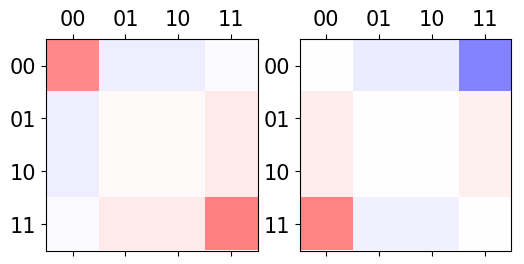

97
0.6917289682566381


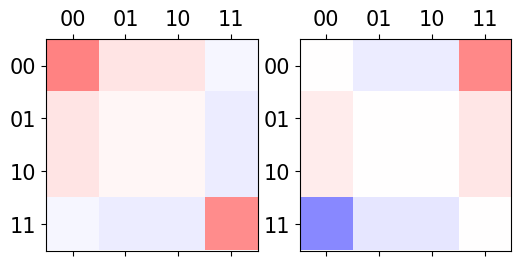

98
0.6893308143626227


In [194]:
names = ['00', '01', '10', '11']

for i in range(0, 99,1):
    hfont = {'fontname':'Arial'}
    fig, ax = plt.subplots(1,2,figsize=(6, 6))
    
    cax = ax[0].matshow(real_imagination(RHO[line][i])[0], vmin=-1, vmax=1, cmap=cm.bwr)
    cax = ax[1].matshow(real_imagination(RHO[line][i])[1], vmin=-1, vmax=1, cmap=cm.bwr)
    #fig.colorbar(cax)
    ticks = numpy.arange(0,4,1)
    ax[0].set_xticks(ticks)
    ax[0].set_yticks(ticks)
    ax[0].set_xticklabels(names)
    ax[0].set_yticklabels(names)
    ax[1].set_xticks(ticks)
    ax[1].set_yticks(ticks)
    ax[1].set_xticklabels(names)
    ax[1].set_yticklabels(names)
    plt.show()
    print (i)
    print (PEntropy[line][i])
    #print (RHO[450][i])
    #print (" ")

# Floquet Eigenvalues analysis

In [242]:
nSites = 2

eps_steps = 500
eps=np.linspace(0.0, 0.2, eps_steps)        #unperfection of pulses
alpha = np.pi/2-eps
w = 0.0                                        #disorder
delta = deltaS(w, nSites)
g = 0.05                            #Interaction
T = 1  

In [276]:
Fl_eig = np.zeros((eps_steps,2**nSites), dtype=np.float)
Fl_vec = np.zeros((eps_steps,2**nSites,2**nSites), dtype=np.complex)
Fl_eig_ent = np.zeros((eps_steps), dtype=np.float)
FL_matrix = np.zeros((eps_steps,2**nSites,2**nSites), dtype=list)

f = IntProgress(min=0, max=eps_steps) # instantiate the bar
display(f) # display the bar
    
for alpha_id, alpha_value in enumerate(alpha): 
    U=Ufunc_all_to_all(nSites,alpha_value,g,T,delta)
    evals, evecs = la.eig(U)
           
    f.value += 1
    Fl_eig[alpha_id] = chop(real(-1j*log(evals)))
    Fl_vec[alpha_id] = evecs.T
    Fl_eig_ent[alpha_id] = Partial_Entropy(evecs.T)
    FL_matrix[alpha_id]  = U

A Jupyter Widget

In [277]:
number =   55     #109  154
print(Fl_eig[number])
print(matrix_chop(Fl_vec[number]))

[ 0.    -3.125  3.025  0.1  ]
[[(0.707+0j), 0, 0, (-0.707+0j)], [(0.661+0j), (0.25+0.013j), (0.25+0.013j), (0.661-0j)], [(-0.25+0.013j), (0.661+0j), (0.661+0j), (-0.25+0.013j)], [0, (0.707+0j), (-0.707-0j), 0]]


In [278]:
Test = FL_matrix[number]

In [279]:
matrix_chop(real_imagination(Test)[0])

[[0.0, -0.002, -0.002, -1.0],
 [0, 0.0, -0.995, 0],
 [0, -0.995, 0.0, 0],
 [-1.0, -0.002, -0.002, 0.0]]

In [280]:
matrix_chop(real_imagination(Test)[1])

[[0, -0.022, -0.022, 0],
 [-0.022, 0.1, 0, -0.022],
 [-0.022, 0, 0.1, -0.022],
 [0, -0.022, -0.022, 0]]

In [281]:
matrix_chop(real_imagination(Test)[2])

[[0j, (-0.002-0.022j), (-0.002-0.022j), (-1+0j)],
 [-0.022j, 0.1j, (-0.995-0j), -0.022j],
 [-0.022j, (-0.995-0j), 0.1j, -0.022j],
 [(-1+0j), (-0.002-0.022j), (-0.002-0.022j), 0j]]

[ 0.    -3.142  3.042  0.1  ]
[ 0.    -3.097  2.997  0.1  ]
[ 0.    -3.024  2.924  0.1  ]
[ 0.    -2.946  2.846  0.1  ]


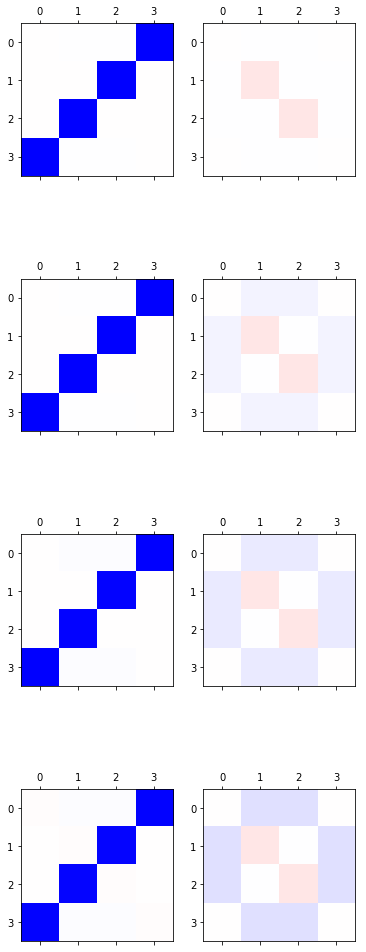

In [295]:
names = ['00', '01', '10', '11']

compare = [5,14,23]    
compare = [1,100,200,300]    

hfont = {'fontname':'Arial'}
fig, ax = plt.subplots(4,2,figsize=(6, 18))
    
cax = ax[0,0].matshow(real_imagination(FL_matrix[compare[0]])[0], vmin=-1, vmax=1, cmap=cm.bwr)
cax = ax[0,1].matshow(real_imagination(FL_matrix[compare[0]])[1], vmin=-1, vmax=1, cmap=cm.bwr)
print (Fl_eig[compare[0]])
cax = ax[1,0].matshow(real_imagination(FL_matrix[compare[1]])[0], vmin=-1, vmax=1, cmap=cm.bwr)
cax = ax[1,1].matshow(real_imagination(FL_matrix[compare[1]])[1], vmin=-1, vmax=1, cmap=cm.bwr)
print (Fl_eig[compare[1]])
cax = ax[2,0].matshow(real_imagination(FL_matrix[compare[2]])[0], vmin=-1, vmax=1, cmap=cm.bwr)
cax = ax[2,1].matshow(real_imagination(FL_matrix[compare[2]])[1], vmin=-1, vmax=1, cmap=cm.bwr)
print (Fl_eig[compare[2]])
cax = ax[3,0].matshow(real_imagination(FL_matrix[compare[3]])[0], vmin=-1, vmax=1, cmap=cm.bwr)
cax = ax[3,1].matshow(real_imagination(FL_matrix[compare[3]])[1], vmin=-1, vmax=1, cmap=cm.bwr)
print (Fl_eig[compare[3]])


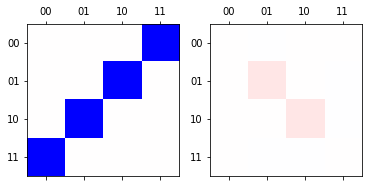

0
[0.    3.142 0.1   3.042]


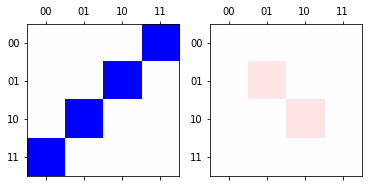

1
[ 0.    -3.142  3.042  0.1  ]


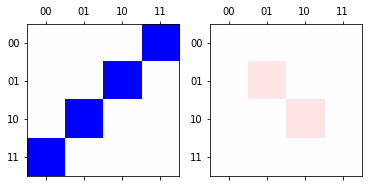

2
[ 0.    -3.142  3.042  0.1  ]


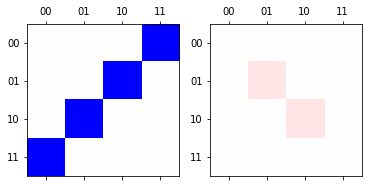

3
[ 0.    -3.142  3.042  0.1  ]


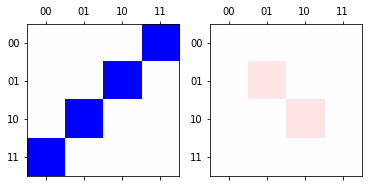

4
[ 0.    -3.141  3.041  0.1  ]


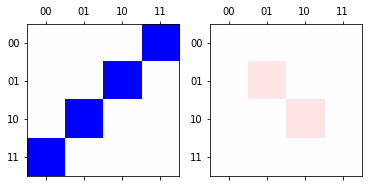

5
[ 0.    -3.141  3.041  0.1  ]


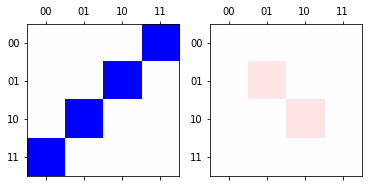

6
[ 0.    -3.141  3.041  0.1  ]


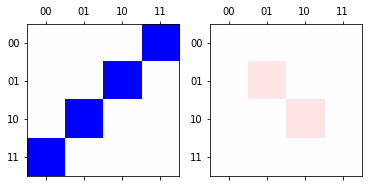

7
[ 0.    -3.141  3.041  0.1  ]


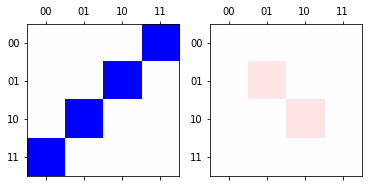

8
[ 0.    -3.141  3.041  0.1  ]


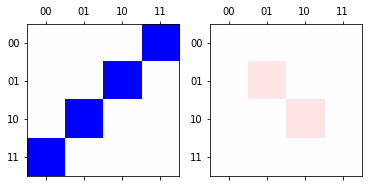

9
[ 0.    -3.141  3.041  0.1  ]


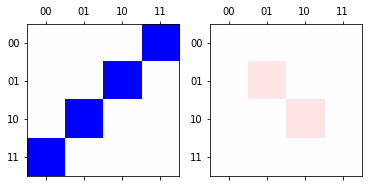

10
[ 0.    -3.141  3.041  0.1  ]


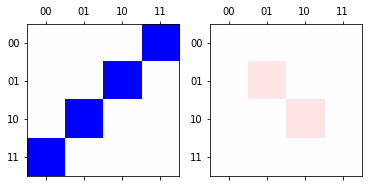

11
[ 0.    -3.141  3.041  0.1  ]


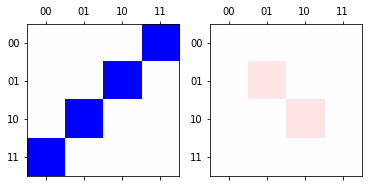

12
[ 0.    -3.141  3.041  0.1  ]


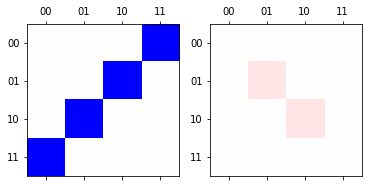

13
[ 0.    -3.141  3.041  0.1  ]


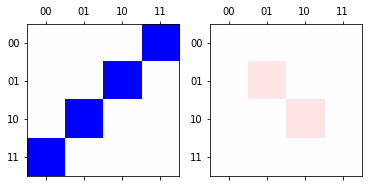

14
[ 0.   -3.14  3.04  0.1 ]


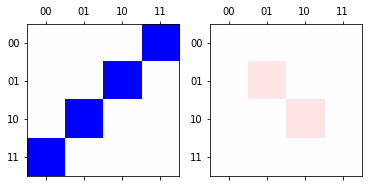

15
[ 0.   -3.14  3.04  0.1 ]


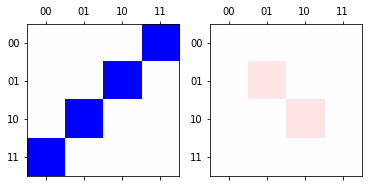

16
[ 0.   -3.14  3.04  0.1 ]


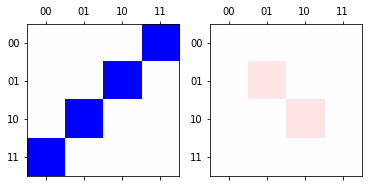

17
[ 0.   -3.14  3.04  0.1 ]


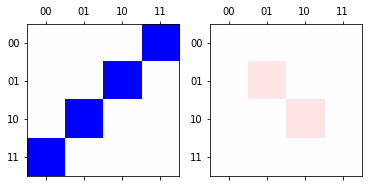

18
[ 0.   -3.14  3.04  0.1 ]


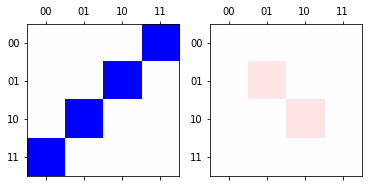

19
[ 0.    -3.139  3.039  0.1  ]


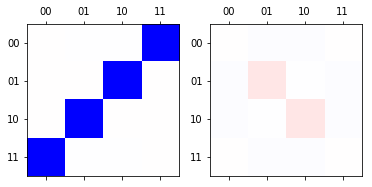

20
[ 0.    -3.139  3.039  0.1  ]


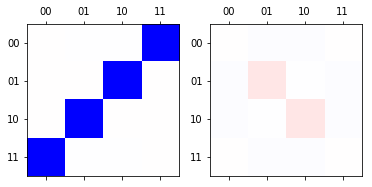

21
[ 0.    -3.139  3.039  0.1  ]


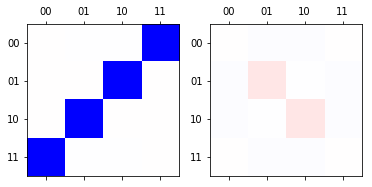

22
[ 0.    -3.139  3.039  0.1  ]


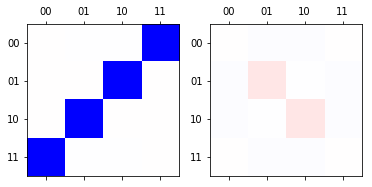

23
[ 0.    -3.138  3.038  0.1  ]


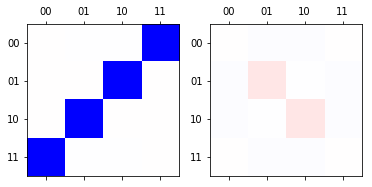

24
[ 0.    -3.138  3.038  0.1  ]


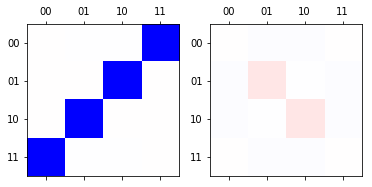

25
[ 0.    -3.138  3.038  0.1  ]


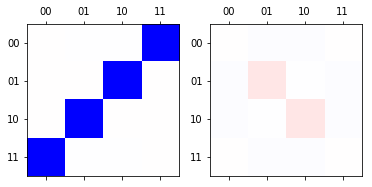

26
[ 0.    -3.137  3.037  0.1  ]


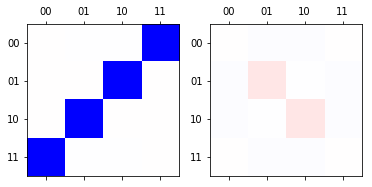

27
[ 0.    -3.137  3.037  0.1  ]


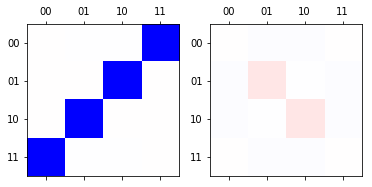

28
[ 0.    -3.137  3.037  0.1  ]


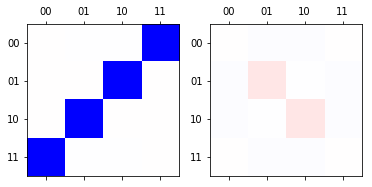

29
[ 0.    -3.136  3.036  0.1  ]


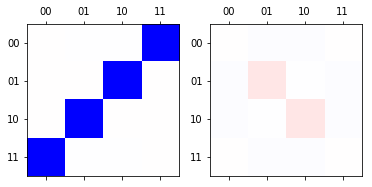

30
[ 0.    -3.136  3.036  0.1  ]


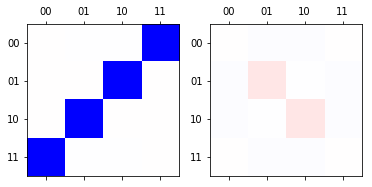

31
[ 0.    -3.136  3.036  0.1  ]


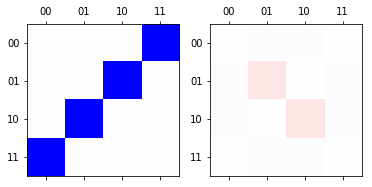

32
[ 0.    -3.135  3.035  0.1  ]


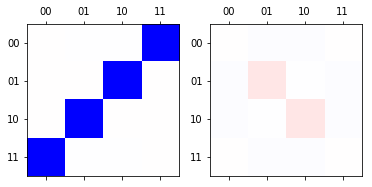

33
[ 0.    -3.135  3.035  0.1  ]


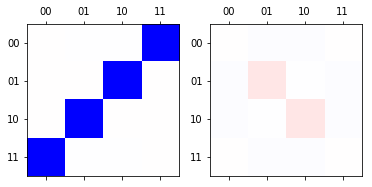

34
[ 0.    -3.135  3.035  0.1  ]


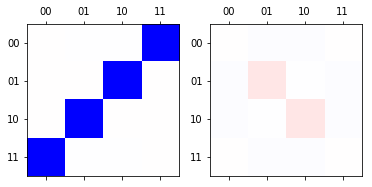

35
[ 0.    -3.134  3.034  0.1  ]


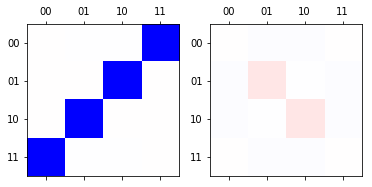

36
[ 0.    -3.134  3.034  0.1  ]


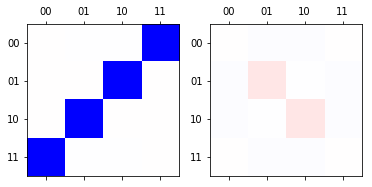

37
[ 0.    -3.133  3.033  0.1  ]


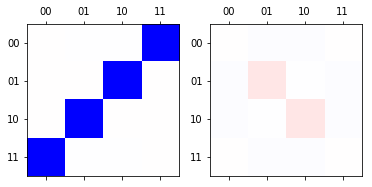

38
[ 0.    -3.133  3.033  0.1  ]


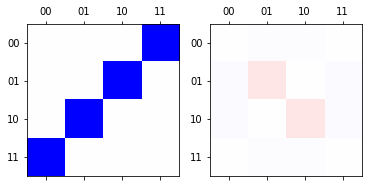

39
[ 0.    -3.133  3.033  0.1  ]


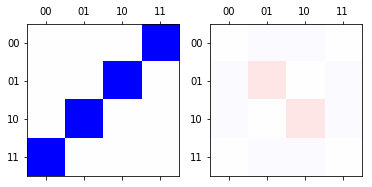

40
[ 0.    -3.132  3.032  0.1  ]


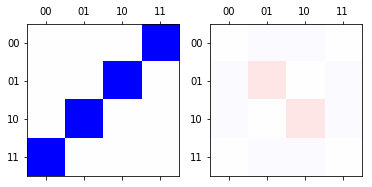

41
[ 0.    -3.132  3.032  0.1  ]


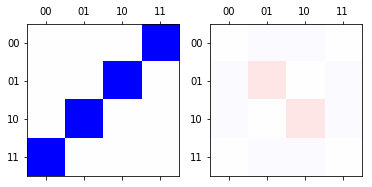

42
[ 0.    -3.131  3.031  0.1  ]


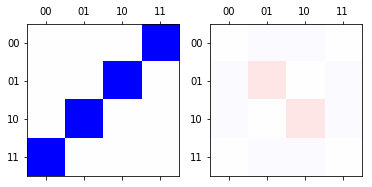

43
[ 0.    -3.131  3.031  0.1  ]


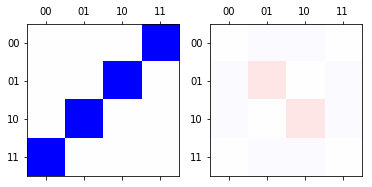

44
[ 0.   -3.13  3.03  0.1 ]


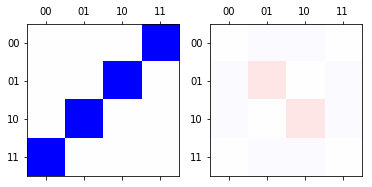

45
[ 0.   -3.13  3.03  0.1 ]


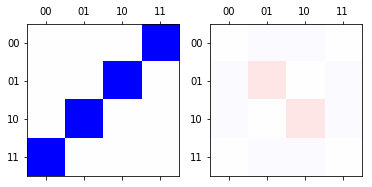

46
[ 0.    -3.129  3.029  0.1  ]


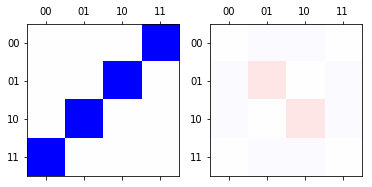

47
[ 0.    -3.129  3.029  0.1  ]


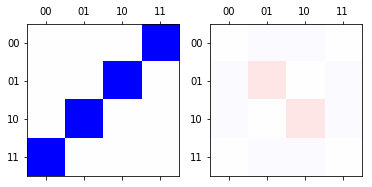

48
[ 0.    -3.129  3.029  0.1  ]


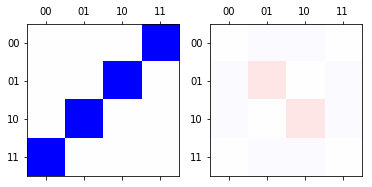

49
[ 0.    -3.128  3.028  0.1  ]


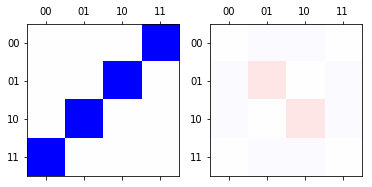

50
[ 0.    -3.128  3.028  0.1  ]


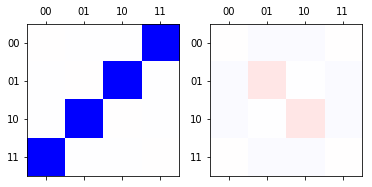

51
[ 0.    -3.127  3.027  0.1  ]


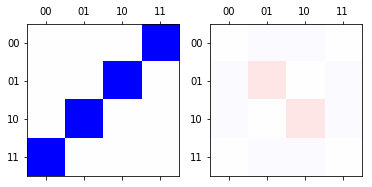

52
[ 0.    -3.127  3.027  0.1  ]


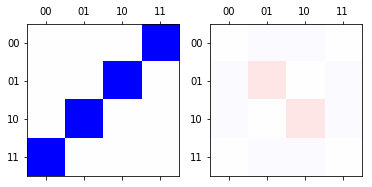

53
[ 0.    -3.126  3.026  0.1  ]


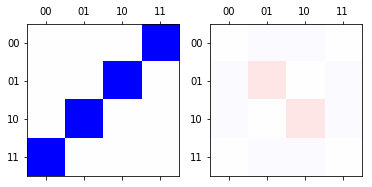

54
[ 0.    -3.125  3.025  0.1  ]


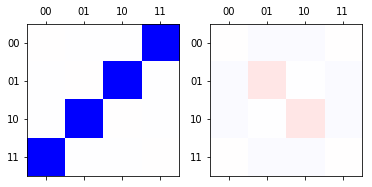

55
[ 0.    -3.125  3.025  0.1  ]


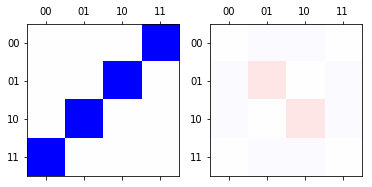

56
[ 0.    -3.124  3.024  0.1  ]


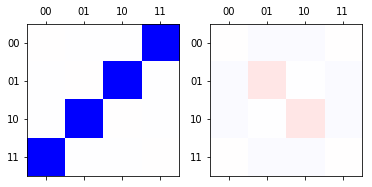

57
[ 0.    -3.124  3.024  0.1  ]


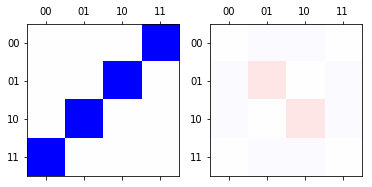

58
[ 0.    -3.123  3.023  0.1  ]


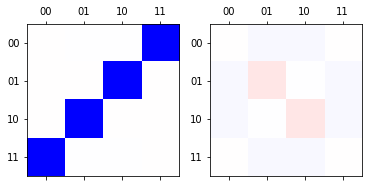

59
[ 0.    -3.123  3.023  0.1  ]


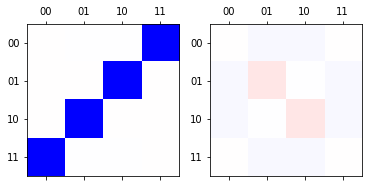

60
[ 0.    -3.122  3.022  0.1  ]


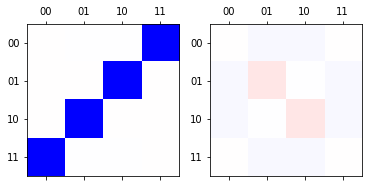

61
[ 0.    -3.122  3.022  0.1  ]


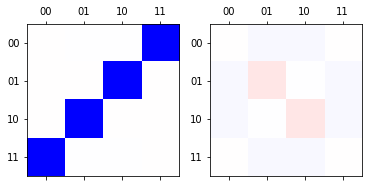

62
[ 0.    -3.121  3.021  0.1  ]


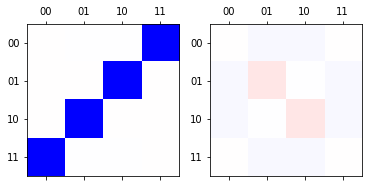

63
[ 0.    -3.121  3.021  0.1  ]


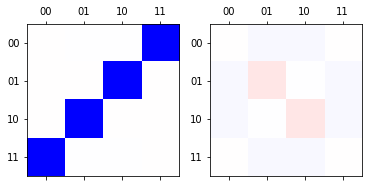

64
[ 0.   -3.12  3.02  0.1 ]


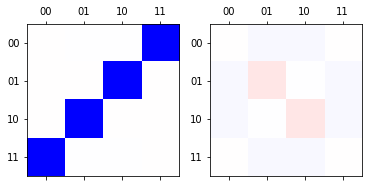

65
[ 0.    -3.119  3.019  0.1  ]


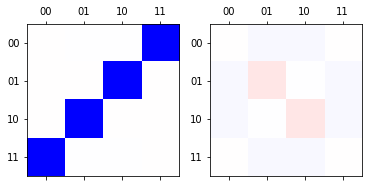

66
[ 0.    -3.119  3.019  0.1  ]


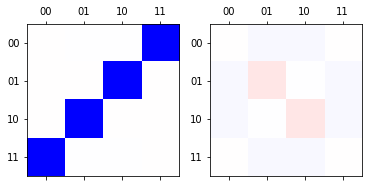

67
[ 0.    -3.118  3.018  0.1  ]


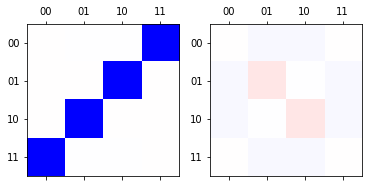

68
[ 0.    -3.118  3.018  0.1  ]


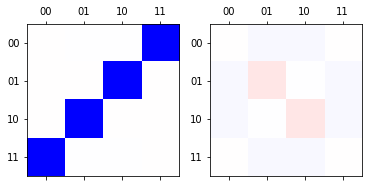

69
[ 0.    -3.117  3.017  0.1  ]


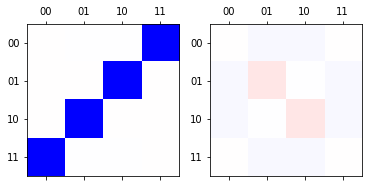

70
[ 0.    -3.116  3.016  0.1  ]


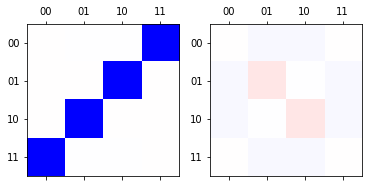

71
[ 0.    -3.116  3.016  0.1  ]


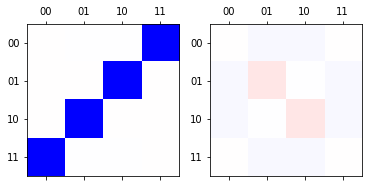

72
[ 0.    -3.115  3.015  0.1  ]


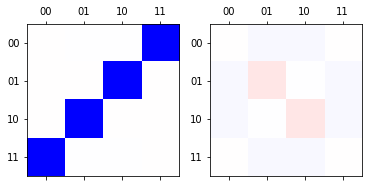

73
[ 0.    -3.115  3.015  0.1  ]


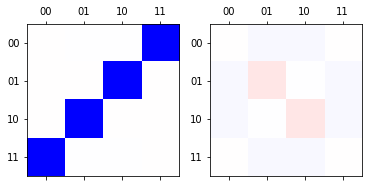

74
[ 0.    -3.114  3.014  0.1  ]


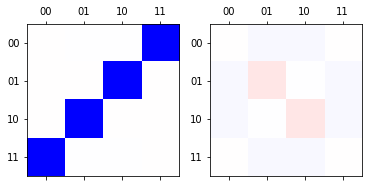

75
[ 0.    -3.113  3.013  0.1  ]


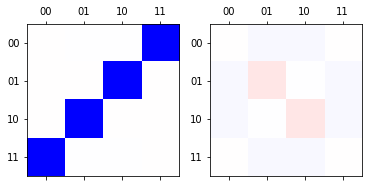

76
[ 0.    -3.113  3.013  0.1  ]


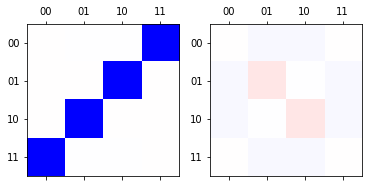

77
[ 0.    -3.112  3.012  0.1  ]


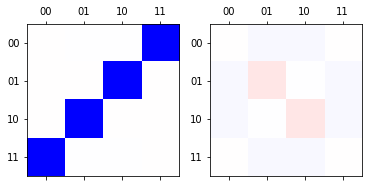

78
[ 0.    -3.112  3.012  0.1  ]


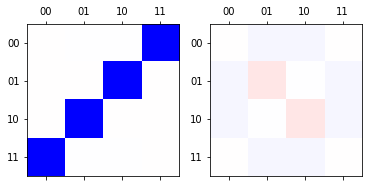

79
[ 0.    -3.111  3.011  0.1  ]


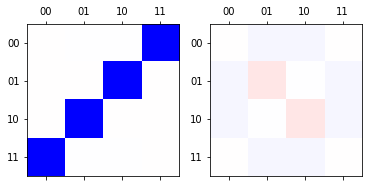

80
[ 0.   -3.11  3.01  0.1 ]


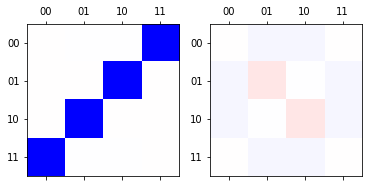

81
[ 0.   -3.11  3.01  0.1 ]


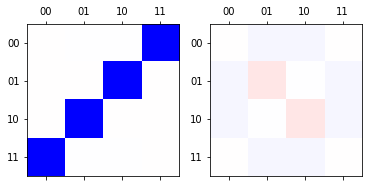

82
[ 0.    -3.109  3.009  0.1  ]


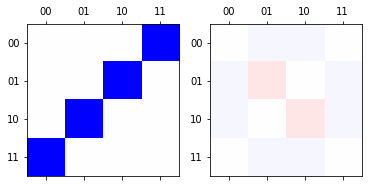

83
[ 0.    -3.108  3.008  0.1  ]


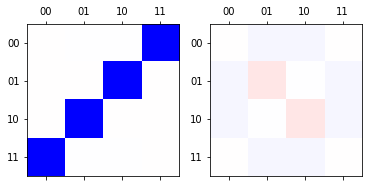

84
[ 0.    -3.108  3.008  0.1  ]


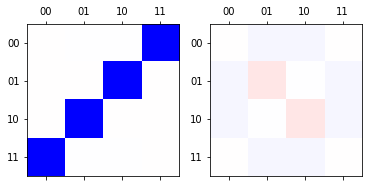

85
[ 0.    -3.107  3.007  0.1  ]


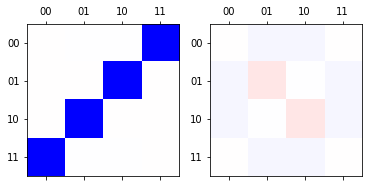

86
[ 0.    -3.106  3.006  0.1  ]


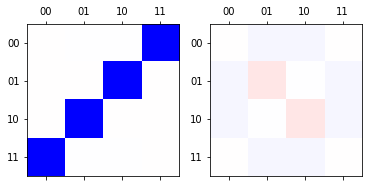

87
[ 0.    -3.106  3.006  0.1  ]


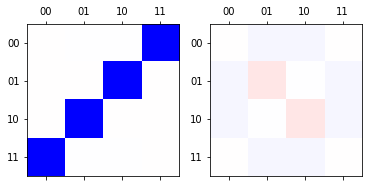

88
[ 0.    -3.105  3.005  0.1  ]


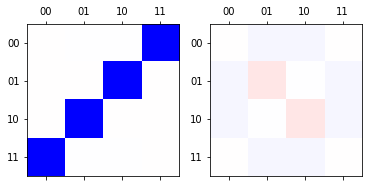

89
[ 0.    -3.104  3.004  0.1  ]


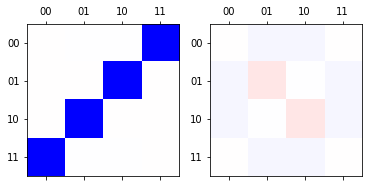

90
[ 0.    -3.104  3.004  0.1  ]


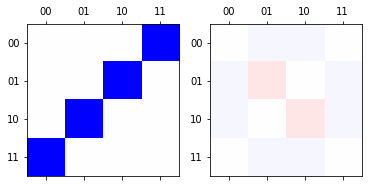

91
[ 0.    -3.103  3.003  0.1  ]


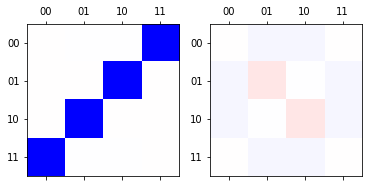

92
[ 0.    -3.103  3.003  0.1  ]


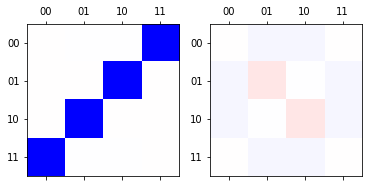

93
[ 0.    -3.102  3.002  0.1  ]


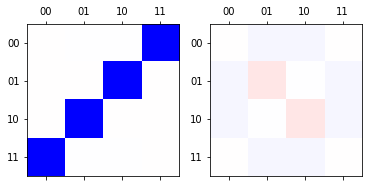

94
[ 0.    -3.101  3.001  0.1  ]


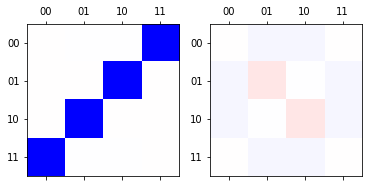

95
[ 0.    -3.101  3.001  0.1  ]


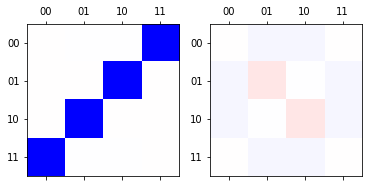

96
[ 0.  -3.1  3.   0.1]


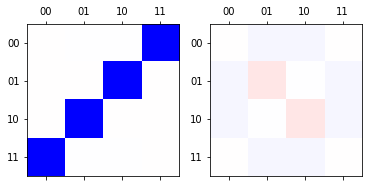

97
[ 0.    -3.099  2.999  0.1  ]


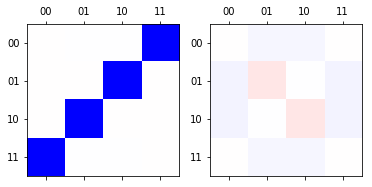

98
[ 0.    -3.099  2.999  0.1  ]


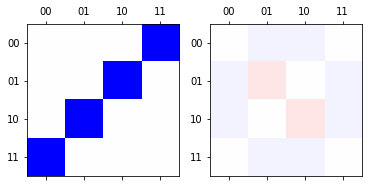

99
[ 0.    -3.098  2.998  0.1  ]


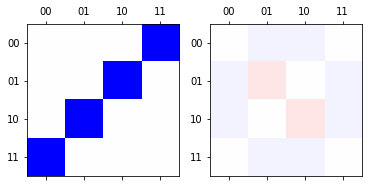

100
[ 0.    -3.097  2.997  0.1  ]


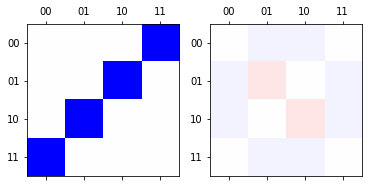

101
[ 0.    -3.096  2.996  0.1  ]


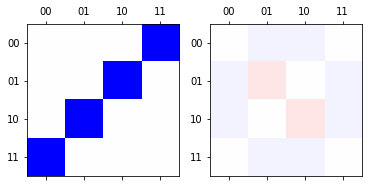

102
[ 0.    -3.096  2.996  0.1  ]


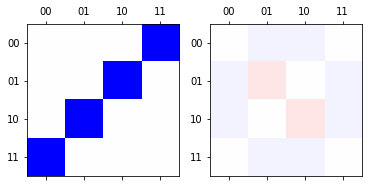

103
[ 0.    -3.095  2.995  0.1  ]


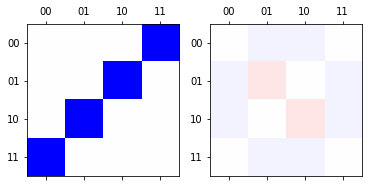

104
[ 0.    -3.094  2.994  0.1  ]


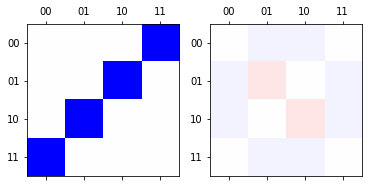

105
[ 0.    -3.094  2.994  0.1  ]


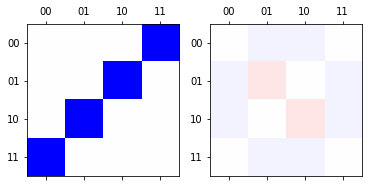

106
[ 0.    -3.093  2.993  0.1  ]


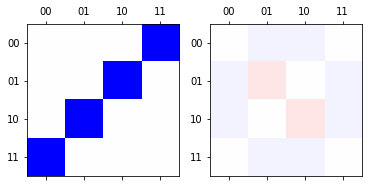

107
[ 0.    -3.092  2.992  0.1  ]


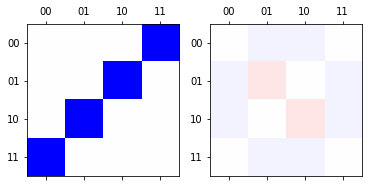

108
[ 0.    -3.092  2.992  0.1  ]


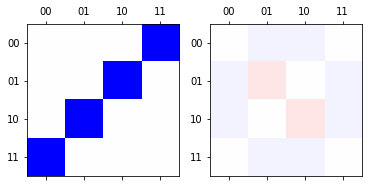

109
[ 0.    -3.091  2.991  0.1  ]


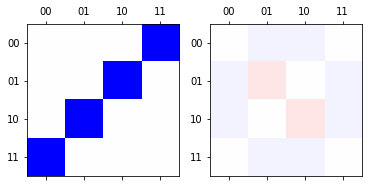

110
[ 0.   -3.09  2.99  0.1 ]


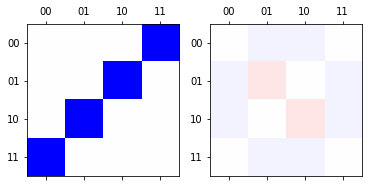

111
[ 0.   -3.09  2.99  0.1 ]


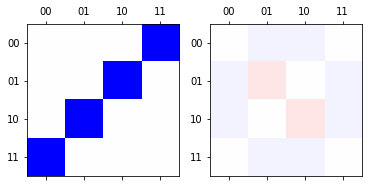

112
[ 0.    -3.089  2.989  0.1  ]


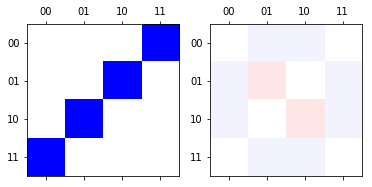

113
[ 0.    -3.088  2.988  0.1  ]


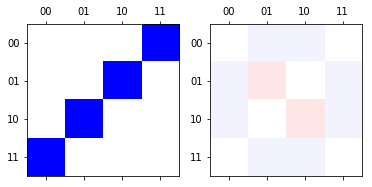

114
[ 0.    -3.087  2.987  0.1  ]


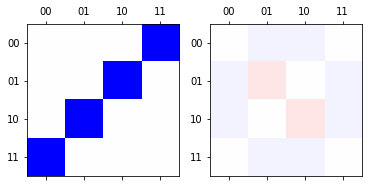

115
[ 0.    -3.087  2.987  0.1  ]


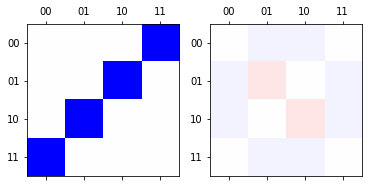

116
[ 0.    -3.086  2.986  0.1  ]


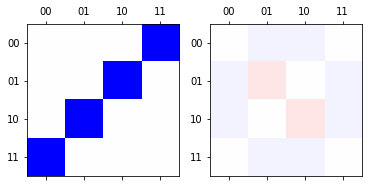

117
[ 0.    -3.085  2.985  0.1  ]


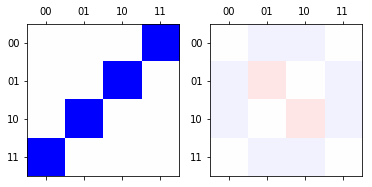

118
[ 0.    -3.085  2.985  0.1  ]


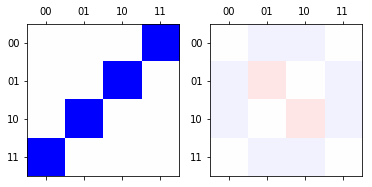

119
[ 0.    -3.084  2.984  0.1  ]


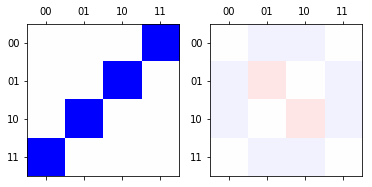

120
[ 0.    -3.083  2.983  0.1  ]


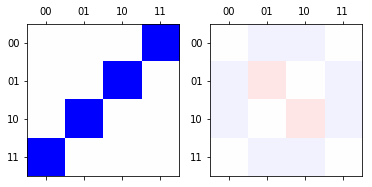

121
[ 0.    -3.083  2.983  0.1  ]


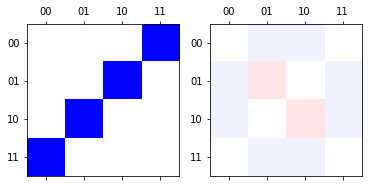

122
[ 0.    -3.082  2.982  0.1  ]


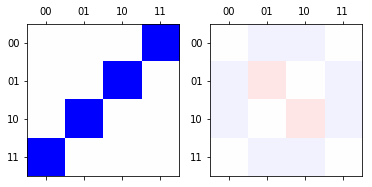

123
[ 0.    -3.081  2.981  0.1  ]


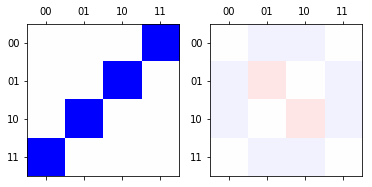

124
[ 0.   -3.08  2.98  0.1 ]


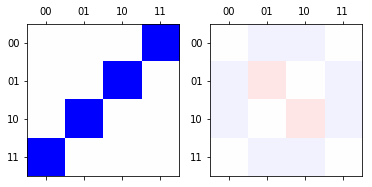

125
[ 0.   -3.08  2.98  0.1 ]


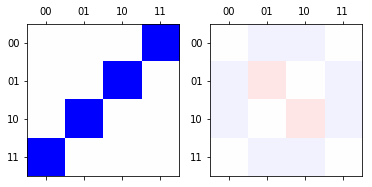

126
[ 0.    -3.079  2.979  0.1  ]


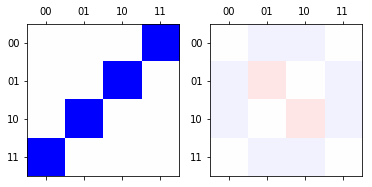

127
[ 0.    -3.078  2.978  0.1  ]


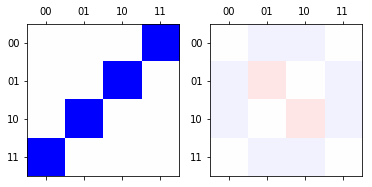

128
[ 0.    -3.077  2.977  0.1  ]


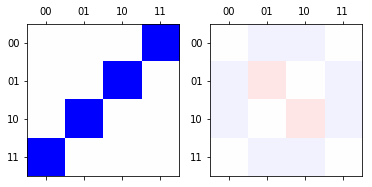

129
[ 0.    -3.077  2.977  0.1  ]


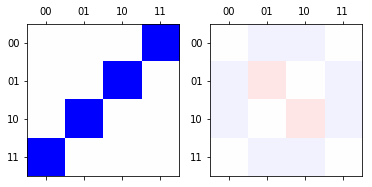

130
[ 0.    -3.076  2.976  0.1  ]


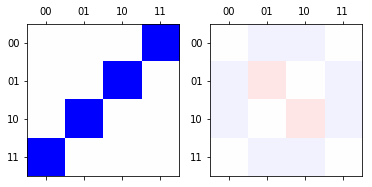

131
[ 0.    -3.075  2.975  0.1  ]


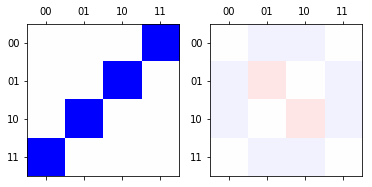

132
[ 0.    -3.075  2.975  0.1  ]


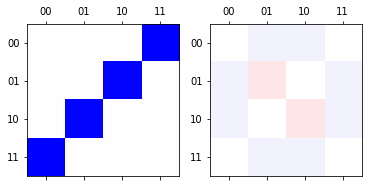

133
[ 0.    -3.074  2.974  0.1  ]


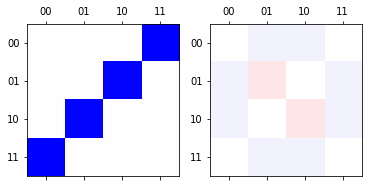

134
[ 0.    -3.073  2.973  0.1  ]


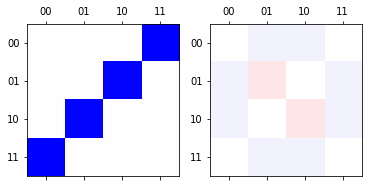

135
[ 0.    -3.072  2.972  0.1  ]


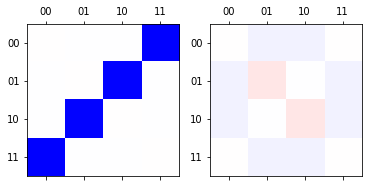

136
[ 0.    -3.072  2.972  0.1  ]


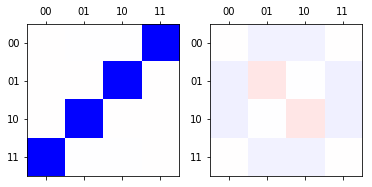

137
[ 0.    -3.071  2.971  0.1  ]


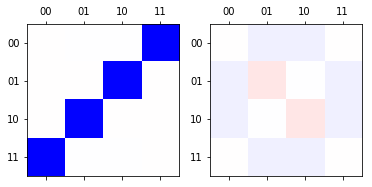

138
[ 0.   -3.07  2.97  0.1 ]


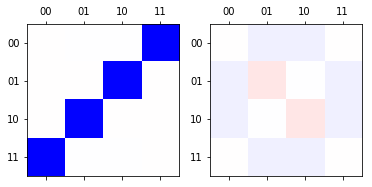

139
[ 0.   -3.07  2.97  0.1 ]


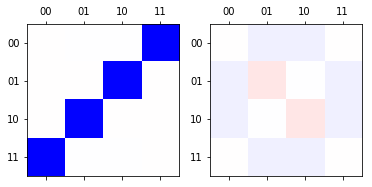

140
[ 0.    -3.069  2.969  0.1  ]


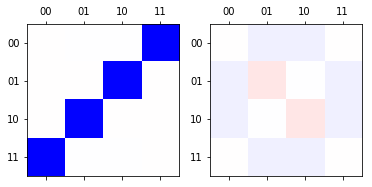

141
[ 0.    -3.068  2.968  0.1  ]


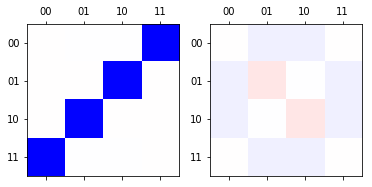

142
[ 0.    -3.067  2.967  0.1  ]


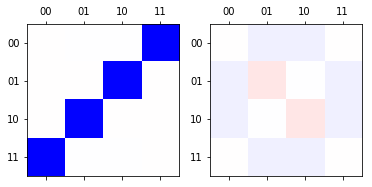

143
[ 0.    -3.067  2.967  0.1  ]


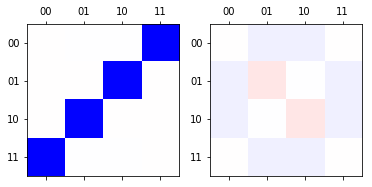

144
[ 0.    -3.066  2.966  0.1  ]


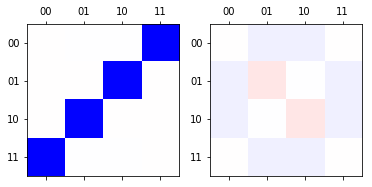

145
[ 0.    -3.065  2.965  0.1  ]


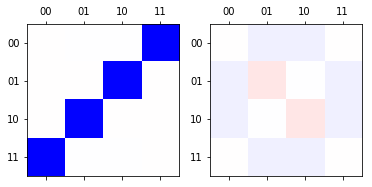

146
[ 0.    -3.064  2.964  0.1  ]


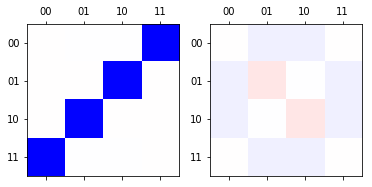

147
[ 0.    -3.064  2.964  0.1  ]


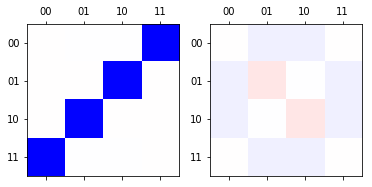

148
[ 0.    -3.063  2.963  0.1  ]


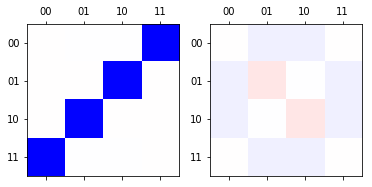

149
[ 0.    -3.062  2.962  0.1  ]


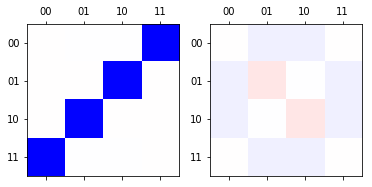

150
[ 0.    -3.061  2.961  0.1  ]


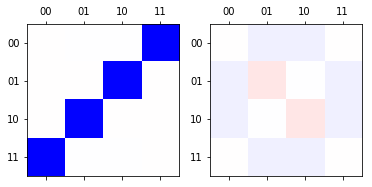

151
[ 0.    -3.061  2.961  0.1  ]


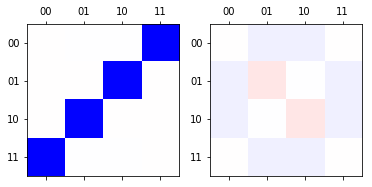

152
[ 0.   -3.06  2.96  0.1 ]


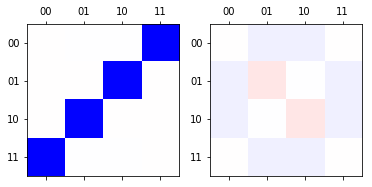

153
[ 0.    -3.059  2.959  0.1  ]


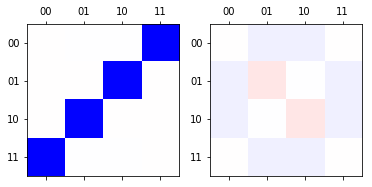

154
[ 0.    -3.058  2.958  0.1  ]


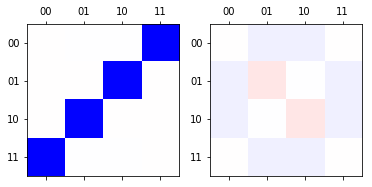

155
[ 0.    -3.058  2.958  0.1  ]


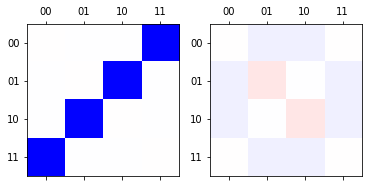

156
[ 0.    -3.057  2.957  0.1  ]


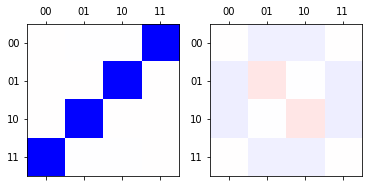

157
[ 0.    -3.056  2.956  0.1  ]


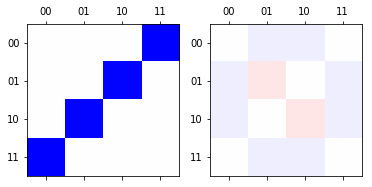

158
[ 0.    -3.055  2.955  0.1  ]


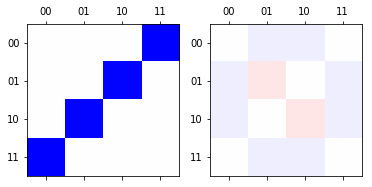

159
[ 0.    -3.055  2.955  0.1  ]


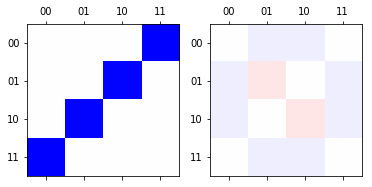

160
[ 0.    -3.054  2.954  0.1  ]


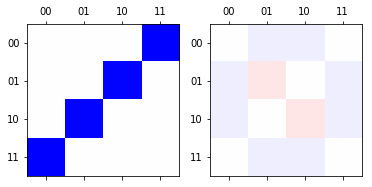

161
[ 0.    -3.053  2.953  0.1  ]


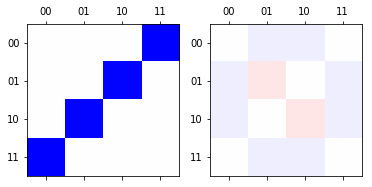

162
[ 0.    -3.052  2.952  0.1  ]


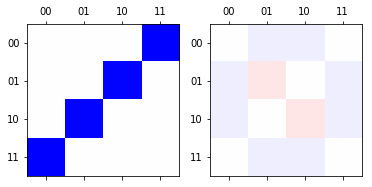

163
[ 0.    -3.052  2.952  0.1  ]


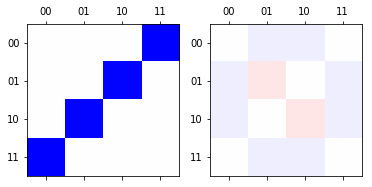

164
[ 0.    -3.051  2.951  0.1  ]


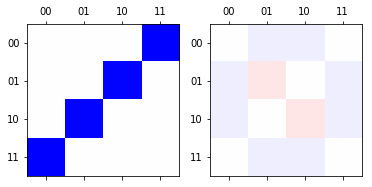

165
[ 0.   -3.05  2.95  0.1 ]


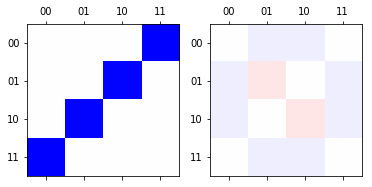

166
[ 0.    -3.049  2.949  0.1  ]


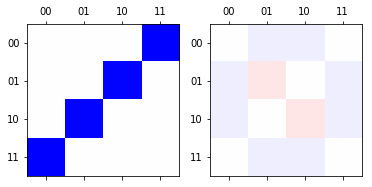

167
[ 0.    -3.049  2.949  0.1  ]


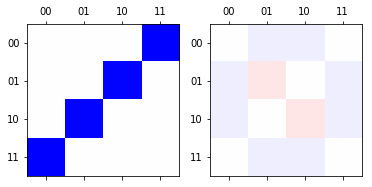

168
[ 0.    -3.048  2.948  0.1  ]


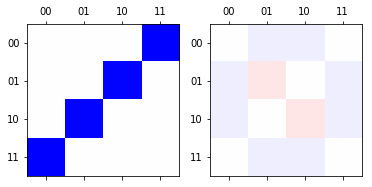

169
[ 0.    -3.047  2.947  0.1  ]


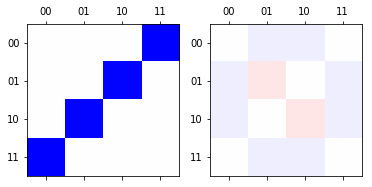

170
[ 0.    -3.046  2.946  0.1  ]


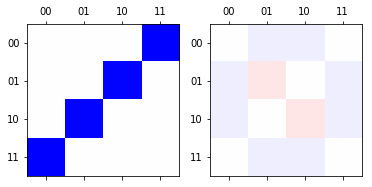

171
[ 0.    -3.046  2.946  0.1  ]


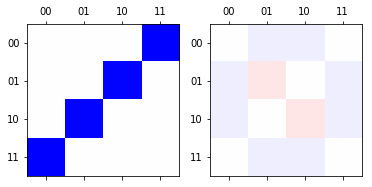

172
[ 0.    -3.045  2.945  0.1  ]


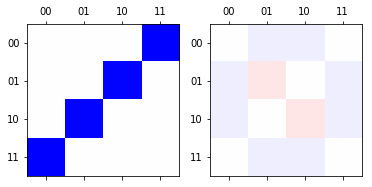

173
[ 0.    -3.044  2.944  0.1  ]


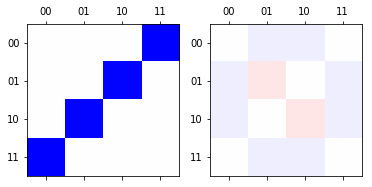

174
[ 0.    -3.043  2.943  0.1  ]


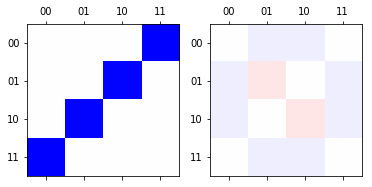

175
[ 0.    -3.043  2.943  0.1  ]


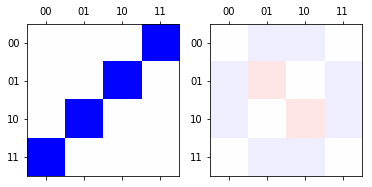

176
[ 0.    -3.042  2.942  0.1  ]


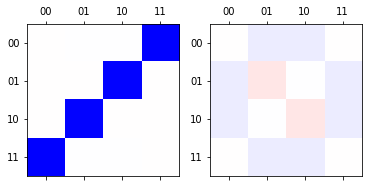

177
[ 0.    -3.041  2.941  0.1  ]


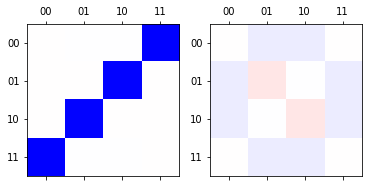

178
[ 0.   -3.04  2.94  0.1 ]


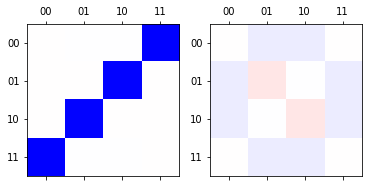

179
[ 0.   -3.04  2.94  0.1 ]


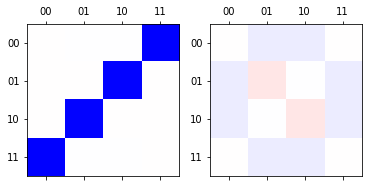

180
[ 0.    -3.039  2.939  0.1  ]


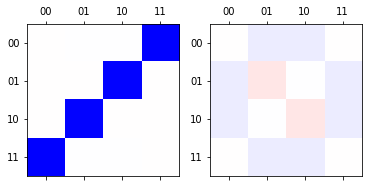

181
[ 0.    -3.038  2.938  0.1  ]


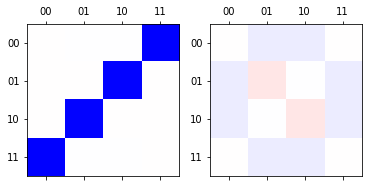

182
[ 0.    -3.037  2.937  0.1  ]


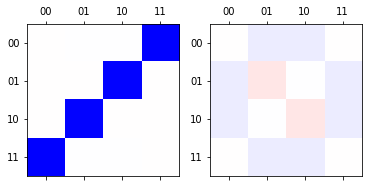

183
[ 0.    -3.037  2.937  0.1  ]


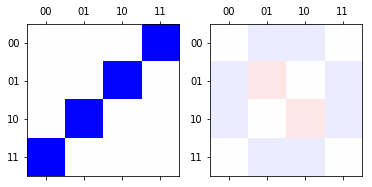

184
[ 0.    -3.036  2.936  0.1  ]


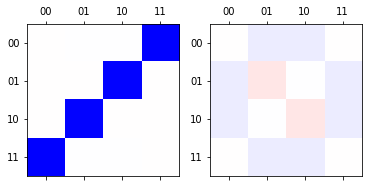

185
[ 0.    -3.035  2.935  0.1  ]


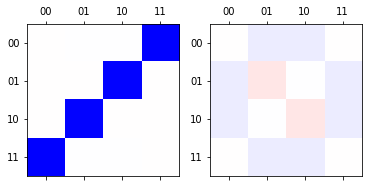

186
[ 0.    -3.034  2.934  0.1  ]


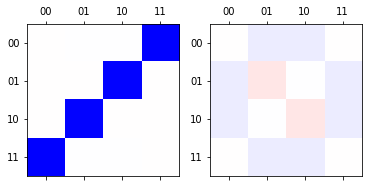

187
[ 0.    -3.034  2.934  0.1  ]


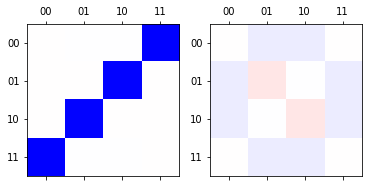

188
[ 0.    -3.033  2.933  0.1  ]


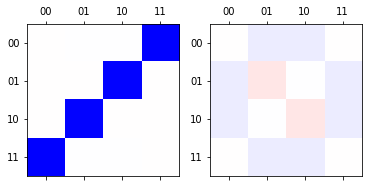

189
[ 0.    -3.032  2.932  0.1  ]


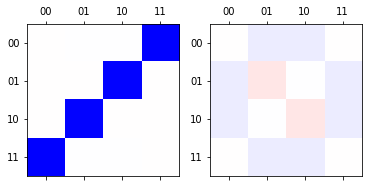

190
[ 0.    -3.031  2.931  0.1  ]


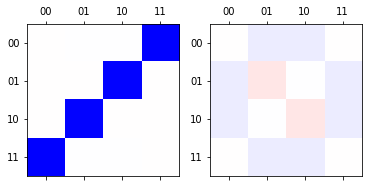

191
[ 0.    -3.031  2.931  0.1  ]


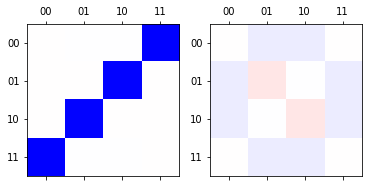

192
[ 0.   -3.03  2.93  0.1 ]


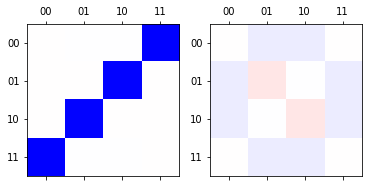

193
[ 0.    -3.029  2.929  0.1  ]


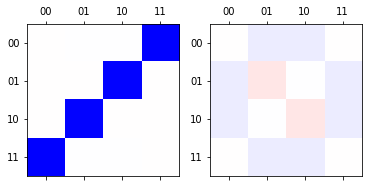

194
[ 0.    -3.028  2.928  0.1  ]


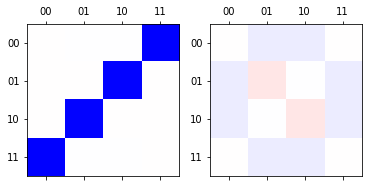

195
[ 0.    -3.028  2.928  0.1  ]


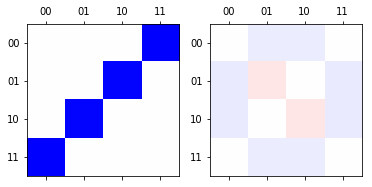

196
[ 0.    -3.027  2.927  0.1  ]


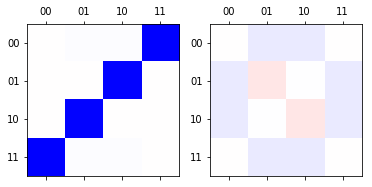

197
[ 0.    -3.026  2.926  0.1  ]


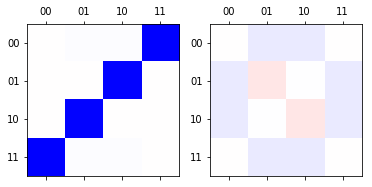

198
[ 0.    -3.025  2.925  0.1  ]


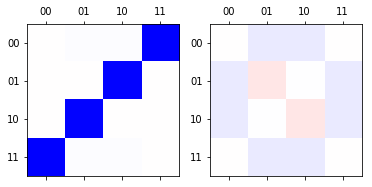

199
[ 0.    -3.024  2.924  0.1  ]


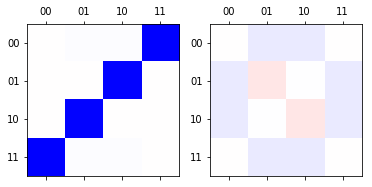

200
[ 0.    -3.024  2.924  0.1  ]


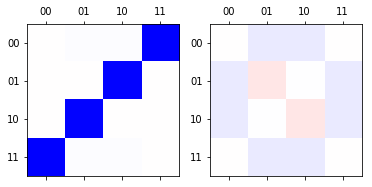

201
[ 0.    -3.023  2.923  0.1  ]


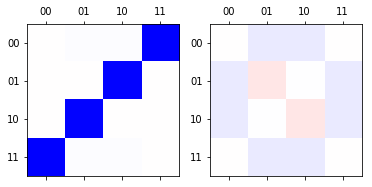

202
[ 0.    -3.022  2.922  0.1  ]


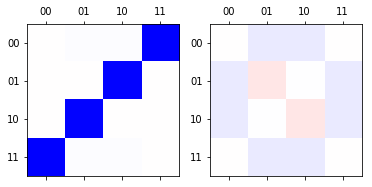

203
[ 0.    -3.021  2.921  0.1  ]


KeyboardInterrupt: 

In [296]:
names = ['00', '01', '10', '11']

for i in range(0, 499,1):
    hfont = {'fontname':'Arial'}
    fig, ax = plt.subplots(1,2,figsize=(6, 6))
    
    cax = ax[0].matshow(real_imagination(FL_matrix[i])[0], vmin=-1, vmax=1, cmap=cm.bwr)
    cax = ax[1].matshow(real_imagination(FL_matrix[i])[1], vmin=-1, vmax=1, cmap=cm.bwr)
    #fig.colorbar(cax)
    ticks = numpy.arange(0,4,1)
    ax[0].set_xticks(ticks)
    ax[0].set_yticks(ticks)
    ax[0].set_xticklabels(names)
    ax[0].set_yticklabels(names)
    ax[1].set_xticks(ticks)
    ax[1].set_yticks(ticks)
    ax[1].set_xticklabels(names)
    ax[1].set_yticklabels(names)
    plt.show()
    print (i)
    print (Fl_eig[i])

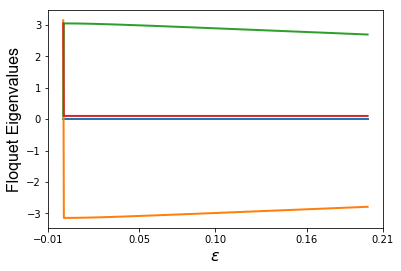

In [299]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,1,figsize=(6, 4))

for i in np.linspace(0,2**nSites-1,2**nSites):

    p = axes.plot(eps, Fl_eig.T[int(i)], linewidth=2.0)

axes.set_xlabel(r'$\epsilon$', fontsize=16, **hfont)
axes.set_ylabel(r'Floquet Eigenvalues', fontsize=16, **hfont)

xmin, xmax = axes.get_xlim()
axes.set_xticks(np.round(np.linspace(xmin, xmax, 5), 2))

# THE QUASIENERGIES OF TWO-INTERACTING QUBITS

In [49]:
def function_F(epsilon,g):
    F = np.zeros((4,4), dtype=np.complex)
    U_e_1 = np.zeros((2,2), dtype=np.complex)
    U_e = np.zeros((4,4), dtype=np.complex)
    U_g = np.zeros((4,4), dtype=np.complex)
    
    U_g[0,0] = 1
    U_g[1,1] = cos(2*g)
    U_g[2,2] = cos(2*g)
    U_g[1,2] = 1j*sin(2*g)
    U_g[2,1] = 1j*sin(2*g)

    U_e_1[0,0] = sin(epsilon)
    U_e_1[1,1] = sin(epsilon)
    U_e_1[0,1] = -1j*cos(epsilon)
    U_e_1[1,0] = -1j*cos(epsilon)

    U_e = np.kron(U_e_1,U_e_1)

    F = np.dot(U_g,U_e)
    
    return F

In [50]:
eps = 0.04
g   = 0.05 

In [53]:
F = function_F(eps,g)
evals, evecs = la.eig(F)

In [72]:
eps_steps = 500
eps=np.linspace(0.001, 0.2, eps_steps)        #unperfection of pulses
g = 0.05                                     #Interaction

In [73]:
eigenenergies = np.zeros((eps_steps,4), dtype=np.complex)
for e_id, e_value in enumerate(eps): 
    evals, evecs = la.eig(function_F(e_value,g))
    eigenenergies[e_id] = evals

C:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


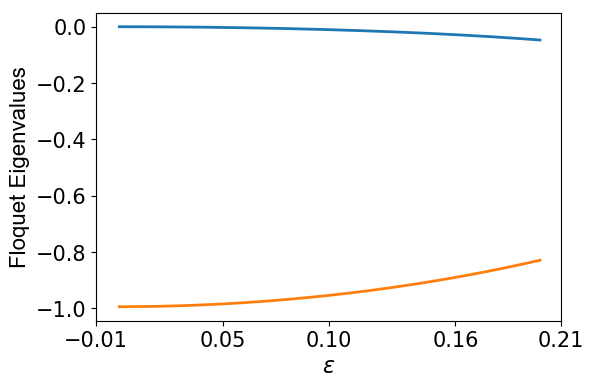

In [82]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,1,figsize=(6, 4))

for i in np.linspace(0,1,2):

    p = axes.plot(eps, eigenenergies.T[int(i)], linewidth=2.0)

axes.set_xlabel(r'$\epsilon$', fontsize=16, **hfont)
axes.set_ylabel(r'Floquet Eigenvalues', fontsize=16, **hfont)

xmin, xmax = axes.get_xlim()
axes.set_xticks(np.round(np.linspace(xmin, xmax, 5), 2))

C:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


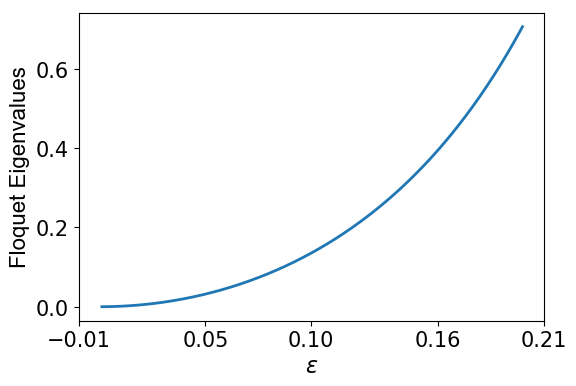

In [95]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,1,figsize=(6, 4))

p = axes.plot(eps, np.pi*4*(eigenenergies.T[0])/eigenenergies.T[1], linewidth=2.0)

axes.set_xlabel(r'$\epsilon$', fontsize=16, **hfont)
axes.set_ylabel(r'Floquet Eigenvalues', fontsize=16, **hfont)

xmin, xmax = axes.get_xlim()
axes.set_xticks(np.round(np.linspace(xmin, xmax, 5), 2))

# Substraction

In [312]:
nSites = 2

eps_steps = 500
eps=np.linspace(0.00, 0.2, eps_steps)        #unperfection of pulses
alpha = np.pi/2-eps
w = 0.00                                        #disorder
delta = deltaF(w, nSites)
g = 0.0                             #Interaction
T = 1  
time_steps = 150
times = np.linspace(1, time_steps, time_steps)

In [313]:
delta

[-0.0, -0.0]

In [314]:
Observables1 = np.zeros((eps_steps,time_steps), dtype=np.float)

f = IntProgress(min=0, max=eps_steps) # instantiate the bar
display(f) # display the bar

sigZOp = tensorize1SiteMatrixKroneker(nSites, 1, 3)
for i in range(2, nSites+1,1):
        sigZOp = sigZOp + tensorize1SiteMatrixKroneker(nSites, i, 3)
    
for alpha_id, alpha_value in enumerate(alpha): 
    U=Ufunc_all_to_all(nSites,alpha_value,g,T,delta)
    phiInitFull = np.full((2**nSites), 0)
    phiInitFull[0] = 1                             ##initial state

    Final = states(phiInitFull,time_steps)                ## Evolution of states

    observables = []
      
    for i in Final:        
        observables.append(np.dot(np.dot(np.conjugate(i).T,sigZOp),i).real)
    f.value += 1
    Observables1[alpha_id] = observables

In [315]:
nSites = 2

eps_steps = 500
eps=np.linspace(0.00, 0.2, eps_steps)        #unperfection of pulses
alpha = np.pi/2-eps
w = 0.00                                        #disorder
delta = deltaS(w, nSites)
g = 0.05                             #Interaction
T = 1  
time_steps = 150
times = np.linspace(1, time_steps, time_steps)

In [316]:
delta

[0, 0.0]

In [317]:
Observables2 = np.zeros((eps_steps,time_steps), dtype=np.float)

f = IntProgress(min=0, max=eps_steps) # instantiate the bar
display(f) # display the bar

sigZOp = tensorize1SiteMatrixKroneker(nSites, 1, 3)
for i in range(2, nSites+1,1):
    sigZOp = sigZOp + tensorize1SiteMatrixKroneker(nSites, i, 3)
    
for alpha_id, alpha_value in enumerate(alpha): 
    U=Ufunc_all_to_all(nSites,alpha_value,g,T,delta)
    phiInitFull = np.full((2**nSites), 0)
    phiInitFull[0] = 1                             ##initial state

    Final = states(phiInitFull,time_steps)                ## Evolution of states
    observables = [] 
    for i in Final:
        observables.append(np.dot(np.dot(np.conjugate(i).T,sigZOp),i).real)
    f.value += 1
    Observables2[alpha_id] = observables

In [318]:
x1=times

x2=np.pi/(x1)/4
x3=np.pi/(x1)/4*3
x4=np.pi/(x1)/4*5
x5=np.pi/(x1)/4*7
x6=np.pi/(x1)/4*9
x7=np.pi/(x1)/4*11
x8=np.pi/(x1)/4*13
x9=np.pi/(x1)/4*15
x10=np.pi/(x1)/4*17
x11=np.pi/(x1)/4*19
x12=np.pi/(x1)/4*21
x13=np.pi/(x1)/4*23
x14=np.pi/(x1)/4*25
x15=np.pi/(x1)/4*27
x16=np.pi/(x1)/4*29
x17=np.pi/(x1)/4*31
x18=np.pi/(x1)/4*33
x19=np.pi/(x1)/4*35
x20=np.pi/(x1)/4*37

XX = [x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20]

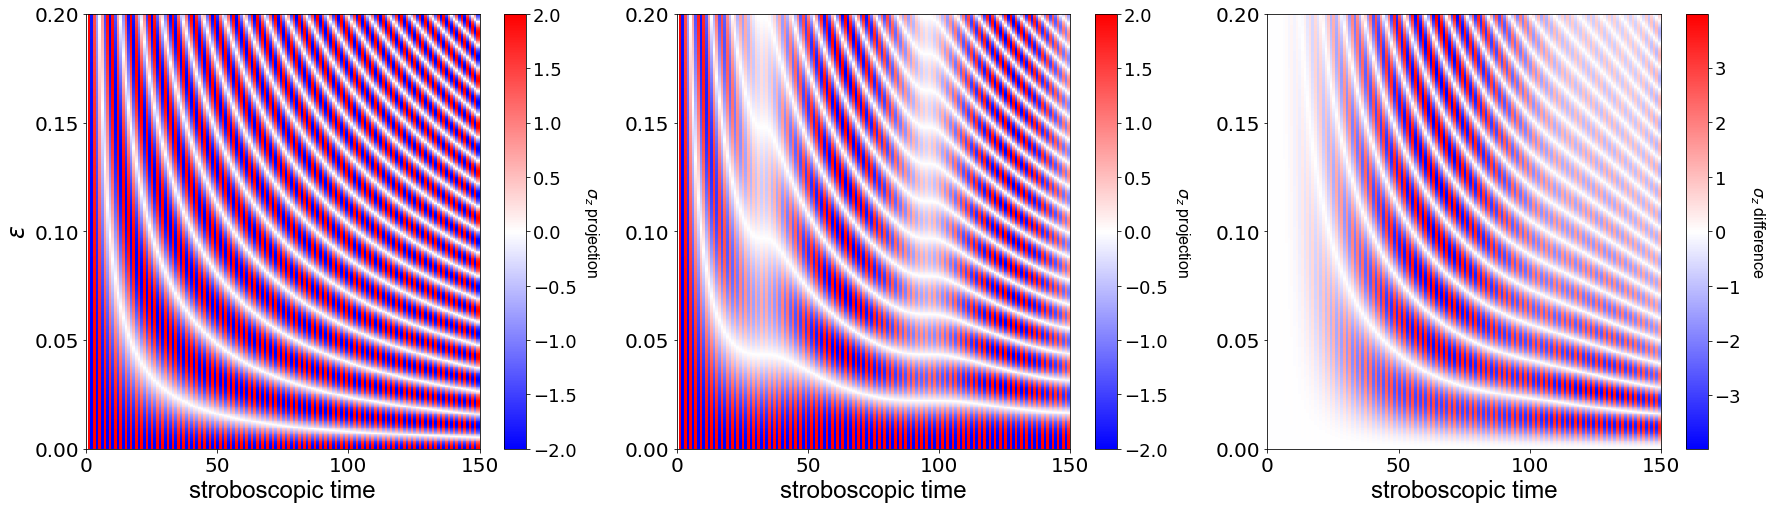

In [319]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,3,figsize=(30, 8))

p = axes[0].pcolor(times, eps, Observables1, cmap=cm.bwr)

axes[0].axis('tight')
axes[0].set_xlabel(r'stroboscopic time', fontsize=24, **hfont)
axes[0].set_ylabel(r'$\epsilon$', fontsize=24, **hfont)


axes[0].tick_params(axis='x', labelsize=20)
axes[0].tick_params(axis='y', labelsize=20)

cb = fig.colorbar(p, ax=axes[0])
cb.set_label(r'$\sigma_z$ projection', labelpad=25, rotation=270, fontsize=16, **hfont)
cb.ax.tick_params(labelsize=18) 

#for i in arange(0,19,1):
#    axes[0].plot(x1,XX[i], '--b' , linewidth=2.0)

#------------------------------------------------------------

p = axes[1].pcolor(times, eps, Observables2, cmap=cm.bwr)

axes[1].axis('tight')
axes[1].set_xlabel(r'stroboscopic time', fontsize=24, **hfont)

axes[1].tick_params(axis='x', labelsize=20)
axes[1].tick_params(axis='y', labelsize=20)

cb = fig.colorbar(p, ax=axes[1])
cb.set_label(r'$\sigma_z$ projection', labelpad=25, rotation=270, fontsize=16, **hfont)
cb.ax.tick_params(labelsize=18) 


#for i in arange(0,19,1):
#    axes[1].plot(x1,XX[i], '--b' , linewidth=2.0)

#--------------------------------------------------------------

p = axes[2].pcolor(times, eps, Observables2-Observables1, cmap=cm.bwr)

axes[2].axis('tight')
axes[2].set_xlabel(r'stroboscopic time', fontsize=24, **hfont)


axes[2].tick_params(axis='x', labelsize=20)
axes[2].tick_params(axis='y', labelsize=20)

cb = fig.colorbar(p, ax=axes[2])
cb.set_label(r'$\sigma_z$ difference', labelpad=25, rotation=270, fontsize=16, **hfont)
cb.ax.tick_params(labelsize=18) 


#for i in arange(0,19,1):
#    axes[2].plot(x1,XX[i], '--b' , linewidth=2.0)

    
ymin, ymax = axes[0].get_ylim()
axes[0].set_yticks(np.round(np.linspace(ymin, ymax, 5), 2))
axes[1].set_yticks(np.round(np.linspace(ymin, ymax, 5), 2))
axes[2].set_yticks(np.round(np.linspace(ymin, ymax, 5), 2))
xmin, xmax = axes[0].get_xlim()
axes[0].set_xticks(np.round(np.linspace(xmin-1, xmax, 4), 2))
axes[1].set_xticks(np.round(np.linspace(xmin-1, xmax, 4), 2))
axes[2].set_xticks(np.round(np.linspace(xmin-1, xmax, 4), 2))


#matplotlib.pyplot.text(0.91, 0.91,'b', fontsize=24, weight="black",  verticalalignment='center', transform=axes.transAxes)
#plt.gcf().set_size_inches(20,8)
#plt.savefig("C:/neon/Simulated Tm_ substraction.pdf", bbox_inches="tight")

# Stationary Time Analizis

An interesting generalization of the Mandelstam–Tamm inequality ($\Delta E \Delta t_A \ge \hbar/2$) was given by Eberly and Singh. The generalization given there is based on the description of the evolution of a closed quantum system in the framework of the quantum Liouville equation for the statistical operator (density matrix) $\rho$

### $i\hbar \frac{\delta\rho}{\delta t} = [H, \rho]$.

In the Heisenberg picture it reads $\delta\rho/\delta t = 0 $ , meaning that the statistical operator is the integral of motion.

Let us introduce ‘the stationarity time’ $T_0$ according to the formula:

### $1/T_0^2 = Tr[(\frac{\delta\rho}{\delta t})^2]$.


<ipython-input-130-571ce4d02a3e>:17: RuntimeWarning: invalid value encountered in true_divide
  p = axes[1].pcolor(times, eps, abs(Stationary_Times[:,:,0]/hbar), cmap=cm.rainbow, shading='auto', vmin=0, vmax=30)
<ipython-input-130-571ce4d02a3e>:30: RuntimeWarning: invalid value encountered in true_divide
  p = axes[2].pcolor(times, eps, abs(Stationary_Times[:,:,1]/hbar), cmap=cm.rainbow, shading='auto', vmin=0, vmax=30)


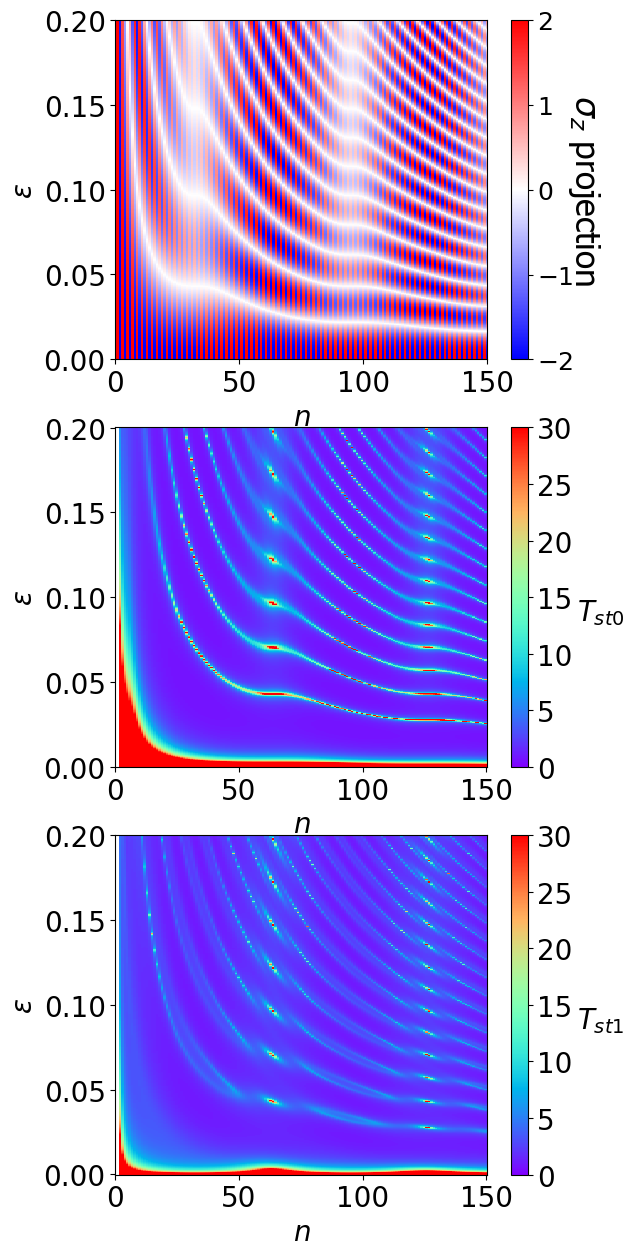

In [130]:
hfont = {'fontname':'Tahoma'}
fig, axes = plt.subplots(3,1,figsize=(6, 15))
p = axes[0].pcolor(times, eps, Observables, cmap=cm.bwr, shading='auto')
axes[0].tick_params(axis='x', labelsize=20)
axes[0].tick_params(axis='y', labelsize=20)
axes[0].set_xlabel(r'$n$', fontsize=20, **hfont)
axes[0].set_ylabel(r'$\epsilon$', fontsize=20, **hfont)
axes[0].set_xlim((1, time_steps))
cb = fig.colorbar(p, ax=axes[0])
cb.set_label(r'$\sigma_z$ projection', labelpad=20, rotation=270, fontsize=24, **hfont)
cb.ax.tick_params(labelsize=18)
ymin, ymax = axes[0].get_ylim()
axes[0].set_yticks(np.round(np.linspace(ymin, ymax, 5), 2))
xmin, xmax = axes[0].get_xlim()
axes[0].set_xticks(np.round(np.linspace(xmin-1, xmax, 4), 2))

p = axes[1].pcolor(times, eps, abs(Stationary_Times[:,:,0]/hbar), cmap=cm.rainbow, shading='auto', vmin=0, vmax=30)
axes[1].tick_params(axis='x', labelsize=20)
axes[1].tick_params(axis='y', labelsize=20)
axes[1].set_xlabel(r'$n$', fontsize=20, **hfont)
axes[1].set_ylabel(r'$\epsilon$', fontsize=20, **hfont)
cb = fig.colorbar(p, ax=axes[1])
cb.set_label(r'$T_{st0}$', labelpad=20, rotation=0, fontsize=20, **hfont)
cb.ax.tick_params(labelsize=20)
ymin, ymax = axes[1].get_ylim()
axes[1].set_yticks(np.round(np.linspace(ymin, ymax, 5), 2))
xmin, xmax = axes[1].get_xlim()
axes[1].set_xticks(np.round(np.linspace(xmin-0.5, xmax-0.5, 4), 2))

p = axes[2].pcolor(times, eps, abs(Stationary_Times[:,:,1]/hbar), cmap=cm.rainbow, shading='auto', vmin=0, vmax=30)
axes[2].tick_params(axis='x', labelsize=20)
axes[2].tick_params(axis='y', labelsize=20)
axes[2].set_xlabel(r'$n$', fontsize=20, **hfont)
axes[2].set_ylabel(r'$\epsilon$', fontsize=20, **hfont)
cb = fig.colorbar(p, ax=axes[2])
cb.set_label(r'$T_{st1}$', labelpad=20, rotation=0, fontsize=20, **hfont)
cb.ax.tick_params(labelsize=20)
ymin, ymax = axes[2].get_ylim()
axes[2].set_yticks(np.round(np.linspace(ymin, ymax, 5), 2))
xmin, xmax = axes[2].get_xlim()
axes[2].set_xticks(np.round(np.linspace(xmin-0.5, xmax-0.5, 4), 2))

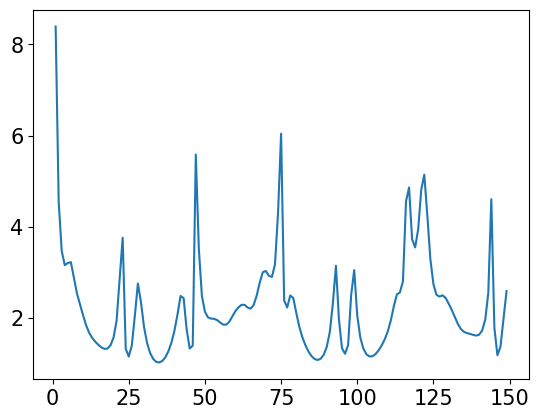

In [133]:
plt.plot(real(Stationary_Times[number*2,:,1])/hbar)

<ipython-input-132-f63cd2b3f497>:12: RuntimeWarning: invalid value encountered in true_divide
  p = axes[1].plot(times, abs(Stationary_Times[number,:,0]/hbar), 'c', linewidth=3.0, label="$T_0$" )
<ipython-input-132-f63cd2b3f497>:13: RuntimeWarning: invalid value encountered in true_divide
  p = axes[1].plot(times, abs(Stationary_Times[number,:,1]/hbar), 'g', linewidth=3.0, label="$T_1$")


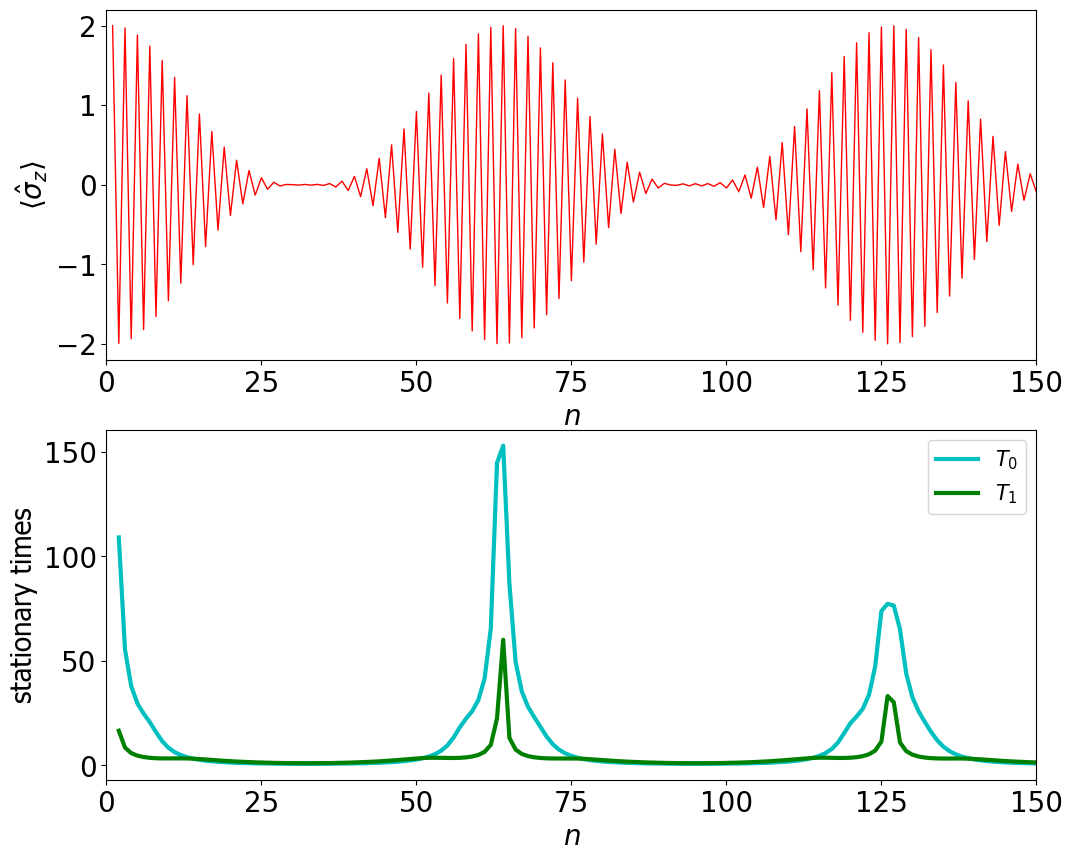

In [132]:
number =  65*2 #65*2 #222 #65  # 55, 109, 154 , 244
hfont = {'fontname':'Tahoma'}
fig, axes = plt.subplots(2,1,figsize=(12, 10))
p = axes[0].plot(times, Observables[number], 'r', linewidth=1.0)
axes[0].set_xlabel(r'$n$', fontsize=20, **hfont)
axes[0].set_ylabel(r'$\langle \hat{\sigma}_z \rangle$', fontsize=20, rotation=90, **hfont)
axes[0].tick_params(axis='x', labelsize=20)
axes[0].tick_params(axis='y', labelsize=20)
axes[0].set_xticks(np.round(np.linspace(0, time_steps, 7), 2))
axes[0].set_xlim(0.0,time_steps)

p = axes[1].plot(times, abs(Stationary_Times[number,:,0]/hbar), 'c', linewidth=3.0, label="$T_0$")
p = axes[1].plot(times, abs(Stationary_Times[number,:,1]/hbar), 'g', linewidth=3.0, label="$T_1$")
axes[1].set_xlabel(r'$n$', fontsize=20, **hfont)
axes[1].set_ylabel(r'stationary times', fontsize=20, **hfont)
axes[1].tick_params(axis='x', labelsize=20)
axes[1].tick_params(axis='y', labelsize=20)
xmin, xmax = axes[1].get_xlim()
axes[1].set_xticks(np.round(np.linspace(0, time_steps, 7), 2))
#axes[1].set_yticks(np.round(np.linspace(0, 0.6, 4), 2))
axes[1].set_xlim(0.0,time_steps)
axes[1].legend()